In [1]:
import pandas as pd
import numpy as np
import random
import math
import argparse
import time
import torch.nn.functional as F
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC,LinearSVC
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self, in_dim = 3, n_hidden = 10, n_layer = 3, out_dim = 3, drop_rate=0.1):
        super(LinearNetwork, self).__init__()
        self.layer1 = nn.Linear(in_dim, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden)
        self.layer4 = nn.Linear(n_hidden, n_hidden)
        self.layer5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, out_dim)
        self.drop_rate = drop_rate
        self.n_layer = n_layer

    def forward1(self, x):
        x = F.dropout(F.relu(self.layer1(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward3(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.dropout(F.relu(self.layer3(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward5(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.dropout(F.relu(self.layer5(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward(self, x):
        if self.n_layer == 1:
            return self.forward1(x)
        elif self.n_layer == 3:
            return self.forward3(x)
        elif self.n_layer == 5:
            return self.forward5(x)
        else:
            raise AssertionError

[Text(-4.0, 0, ''),
 Text(-3.0, 0, ''),
 Text(-2.0, 0, ''),
 Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, '')]

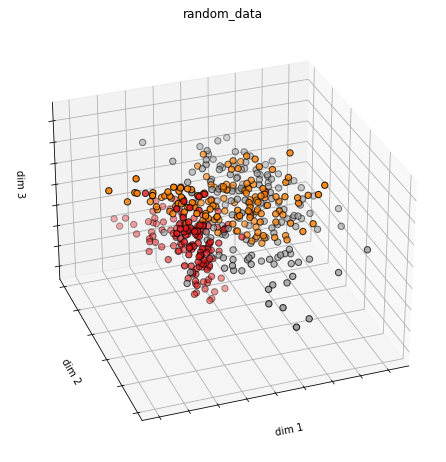

In [3]:
random_data = datasets.make_classification(n_samples=5000, class_sep = 1, random_state = 1,
                                           n_features=3, n_informative = 3, n_redundant = 0, n_classes=3)
random_data_x, random_data_y = random_data[0], random_data[1]

# 数据集可视化
visable_num = 450
fig2 = plt.figure(1, figsize=(8, 6))
ax2 = Axes3D(fig2, elev=-150, azim=110)
ax2.scatter(random_data_x[:visable_num][:, 0], random_data_x[:visable_num][:, 1], 
            random_data_x[:visable_num][:, 2], c=random_data_y[:visable_num],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax2.set_title("random_data")
ax2.set_xlabel("dim 1")
ax2.w_xaxis.set_ticklabels([])
ax2.set_ylabel("dim 2")
ax2.w_yaxis.set_ticklabels([])
ax2.set_zlabel("dim 3")
ax2.w_zaxis.set_ticklabels([])

[Text(-0.8, 0, ''),
 Text(-0.6000000000000001, 0, ''),
 Text(-0.4, 0, ''),
 Text(-0.19999999999999996, 0, ''),
 Text(0.0, 0, ''),
 Text(0.19999999999999996, 0, ''),
 Text(0.40000000000000013, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.8, 0, ''),
 Text(1.0, 0, '')]

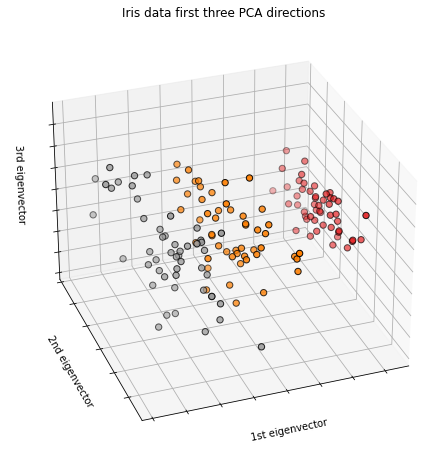

In [4]:
iris = datasets.load_iris()
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
y = iris.target

# 数据集可视化
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("Iris data first three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [5]:
def irisData_loader(x, y, batch_size = 30):

    random_data_idx = np.random.choice(50, 50, replace=False)
    X_train = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[:30],:].reshape(-1,3))
    X_val = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[30:40],:].reshape(-1,3))
    X_test = torch.Tensor(x.reshape(3,50,3)[:,random_data_idx[40:],:].reshape(-1,3))

    y = torch.LongTensor(y)
    y_train = y.reshape(3,50)[:,:30].reshape(-1)
    y_val = y.reshape(3,50)[:,30:40].reshape(-1)
    y_test = y.reshape(3,50)[:,40:].reshape(-1)
    
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
    loader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    return loader

def randomData_loader(x, y, batch_size = 5000):
    random_data_num = len(y)
    X_train = torch.Tensor(x[:int(random_data_num*0.9)])
    X_val = torch.Tensor(x[int(random_data_num*0.9):-int(random_data_num*0.05)])
    X_test = torch.Tensor(x[-int(random_data_num*0.05):])

    y = torch.LongTensor(y)
    y_train = y[:int(random_data_num*0.9)]
    y_val = y[int(random_data_num*0.9):-int(random_data_num*0.05)]
    y_test = y[-int(random_data_num*0.05):]
    
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
    loader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    return loader

np.random.seed(123)
loader = irisData_loader(X_reduced, y)
loader_random = randomData_loader(random_data_x, random_data_y)

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=1234)# 17 17 16

In [67]:
model_iris_3_10 = LinearNetwork().to(device)
model_iris_1_10 = LinearNetwork(n_layer = 1).to(device)
model_iris_5_10 = LinearNetwork(n_layer = 5).to(device)
model_iris_3_05 = LinearNetwork(n_hidden = 5).to(device)
model_iris_3_15 = LinearNetwork(n_hidden = 15).to(device)

# model_random_3_10 = LinearNetwork().to(device)
# model_random_1_10 = LinearNetwork(n_layer = 1).to(device)
# model_random_5_10 = LinearNetwork(n_layer = 5).to(device)
# model_random_3_05 = LinearNetwork(n_hidden = 5).to(device)
# model_random_3_15 = LinearNetwork(n_hidden = 15).to(device)

In [73]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

#     val_acc_history = []
    acc_history = {'train':[], 'val':[], 'test':[]}
    loss_history = {'train':[], 'val':[], 'test':[]}
    f1_history = {'train':[], 'val':[], 'test':[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            preds = np.array(preds.cpu())
            ytest = np.array(labels.data.cpu())
            epoch_f1 = metrics.f1_score(ytest, preds, zero_division=False, average='macro')
            acc_history[phase].append(np.array(epoch_acc.cpu()))
            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(epoch_f1)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history, f1_history

In [74]:
# iris
num_epochs = 500

params_to_update310 = model_iris_3_10.parameters()
params_to_update110 = model_iris_1_10.parameters()
params_to_update510 = model_iris_5_10.parameters()
params_to_update305 = model_iris_3_05.parameters()
params_to_update315 = model_iris_3_15.parameters()

optimizer_ft310 = optim.Adam(params_to_update310, lr=0.001)
optimizer_ft110 = optim.Adam(params_to_update110, lr=0.001)
optimizer_ft510 = optim.Adam(params_to_update510, lr=0.001)
optimizer_ft305 = optim.Adam(params_to_update305, lr=0.001)
optimizer_ft315 = optim.Adam(params_to_update315, lr=0.001)

criterion = nn.CrossEntropyLoss()

model_ft310, hist310, loss310, f1_310 = train_model(model_iris_3_10, loader, criterion, optimizer_ft310, num_epochs=num_epochs)
model_ft110, hist110, loss110, f1_110 = train_model(model_iris_1_10, loader, criterion, optimizer_ft110, num_epochs=num_epochs)
model_ft510, hist510, loss510, f1_510 = train_model(model_iris_5_10, loader, criterion, optimizer_ft510, num_epochs=num_epochs)
model_ft305, hist305, loss305, f1_305 = train_model(model_iris_3_05, loader, criterion, optimizer_ft305, num_epochs=num_epochs)
model_ft315, hist315, loss315, f1_315 = train_model(model_iris_3_15, loader, criterion, optimizer_ft315, num_epochs=num_epochs)

Epoch 0/499
----------
train Loss: 1.0992 Acc: 0.3333
val Loss: 1.0965 Acc: 0.3333
test Loss: 1.0973 Acc: 0.3333
Epoch 1/499
----------
train Loss: 1.0964 Acc: 0.3333
val Loss: 1.0940 Acc: 0.3333
test Loss: 1.0955 Acc: 0.3333
Epoch 2/499
----------
train Loss: 1.0976 Acc: 0.3333
val Loss: 1.0952 Acc: 0.3333
test Loss: 1.0913 Acc: 0.3333
Epoch 3/499
----------
train Loss: 1.0958 Acc: 0.3333
val Loss: 1.0934 Acc: 0.3333
test Loss: 1.0933 Acc: 0.3333
Epoch 4/499
----------
train Loss: 1.0950 Acc: 0.3333
val Loss: 1.0939 Acc: 0.3333
test Loss: 1.0895 Acc: 0.3333
Epoch 5/499
----------
train Loss: 1.0937 Acc: 0.3333
val Loss: 1.0923 Acc: 0.3333
test Loss: 1.0928 Acc: 0.3333
Epoch 6/499
----------
train Loss: 1.0921 Acc: 0.3333
val Loss: 1.0935 Acc: 0.3333
test Loss: 1.0909 Acc: 0.3333
Epoch 7/499
----------
train Loss: 1.0914 Acc: 0.3333
val Loss: 1.0889 Acc: 0.3667
test Loss: 1.0910 Acc: 0.3333
Epoch 8/499
----------
train Loss: 1.0915 Acc: 0.3333
val Loss: 1.0882 Acc: 0.4000
test Loss: 1.

Epoch 85/499
----------
train Loss: 0.8045 Acc: 0.7333
val Loss: 0.8021 Acc: 0.7333
test Loss: 0.8051 Acc: 0.6667
Epoch 86/499
----------
train Loss: 0.8066 Acc: 0.6889
val Loss: 0.7908 Acc: 0.8000
test Loss: 0.7936 Acc: 0.7667
Epoch 87/499
----------
train Loss: 0.7976 Acc: 0.7778
val Loss: 0.7859 Acc: 0.7667
test Loss: 0.8036 Acc: 0.6667
Epoch 88/499
----------
train Loss: 0.7988 Acc: 0.7111
val Loss: 0.7864 Acc: 0.7333
test Loss: 0.7901 Acc: 0.7000
Epoch 89/499
----------
train Loss: 0.7937 Acc: 0.7333
val Loss: 0.7781 Acc: 0.7667
test Loss: 0.7922 Acc: 0.7000
Epoch 90/499
----------
train Loss: 0.7960 Acc: 0.7222
val Loss: 0.7682 Acc: 0.7667
test Loss: 0.7831 Acc: 0.7333
Epoch 91/499
----------
train Loss: 0.7902 Acc: 0.7444
val Loss: 0.7823 Acc: 0.7333
test Loss: 0.7745 Acc: 0.7333
Epoch 92/499
----------
train Loss: 0.7928 Acc: 0.7111
val Loss: 0.7815 Acc: 0.7333
test Loss: 0.7829 Acc: 0.7667
Epoch 93/499
----------
train Loss: 0.7818 Acc: 0.7222
val Loss: 0.7720 Acc: 0.8000
test

train Loss: 0.6261 Acc: 0.9889
val Loss: 0.6119 Acc: 1.0000
test Loss: 0.6775 Acc: 0.9000
Epoch 171/499
----------
train Loss: 0.6262 Acc: 0.9778
val Loss: 0.6032 Acc: 1.0000
test Loss: 0.6531 Acc: 0.9333
Epoch 172/499
----------
train Loss: 0.6188 Acc: 0.9778
val Loss: 0.5975 Acc: 1.0000
test Loss: 0.6466 Acc: 0.9667
Epoch 173/499
----------
train Loss: 0.6219 Acc: 0.9778
val Loss: 0.6025 Acc: 1.0000
test Loss: 0.6483 Acc: 0.9667
Epoch 174/499
----------
train Loss: 0.6238 Acc: 0.9889
val Loss: 0.5922 Acc: 1.0000
test Loss: 0.6466 Acc: 0.9333
Epoch 175/499
----------
train Loss: 0.6191 Acc: 0.9778
val Loss: 0.5979 Acc: 1.0000
test Loss: 0.6563 Acc: 0.9667
Epoch 176/499
----------
train Loss: 0.6243 Acc: 0.9667
val Loss: 0.6004 Acc: 0.9667
test Loss: 0.6624 Acc: 0.9333
Epoch 177/499
----------
train Loss: 0.6142 Acc: 0.9778
val Loss: 0.5925 Acc: 1.0000
test Loss: 0.6407 Acc: 0.9667
Epoch 178/499
----------
train Loss: 0.6130 Acc: 0.9667
val Loss: 0.5795 Acc: 1.0000
test Loss: 0.6441 Ac

train Loss: 0.5887 Acc: 0.9667
val Loss: 0.5566 Acc: 1.0000
test Loss: 0.6235 Acc: 0.9333
Epoch 250/499
----------
train Loss: 0.5722 Acc: 0.9889
val Loss: 0.5595 Acc: 1.0000
test Loss: 0.6113 Acc: 0.9667
Epoch 251/499
----------
train Loss: 0.5779 Acc: 0.9778
val Loss: 0.5582 Acc: 1.0000
test Loss: 0.6346 Acc: 0.9000
Epoch 252/499
----------
train Loss: 0.5762 Acc: 0.9778
val Loss: 0.5611 Acc: 1.0000
test Loss: 0.6065 Acc: 0.9667
Epoch 253/499
----------
train Loss: 0.5835 Acc: 0.9667
val Loss: 0.5579 Acc: 1.0000
test Loss: 0.6070 Acc: 0.9667
Epoch 254/499
----------
train Loss: 0.5664 Acc: 1.0000
val Loss: 0.5564 Acc: 1.0000
test Loss: 0.6180 Acc: 0.9333
Epoch 255/499
----------
train Loss: 0.5778 Acc: 0.9778
val Loss: 0.5747 Acc: 0.9667
test Loss: 0.6171 Acc: 0.9333
Epoch 256/499
----------
train Loss: 0.5809 Acc: 0.9667
val Loss: 0.5615 Acc: 1.0000
test Loss: 0.6224 Acc: 0.9000
Epoch 257/499
----------
train Loss: 0.5813 Acc: 0.9778
val Loss: 0.5567 Acc: 1.0000
test Loss: 0.6092 Ac

train Loss: 0.5770 Acc: 0.9667
val Loss: 0.5526 Acc: 1.0000
test Loss: 0.6205 Acc: 0.9333
Epoch 327/499
----------
train Loss: 0.5721 Acc: 0.9778
val Loss: 0.5534 Acc: 1.0000
test Loss: 0.6231 Acc: 0.9333
Epoch 328/499
----------
train Loss: 0.5723 Acc: 0.9778
val Loss: 0.5530 Acc: 1.0000
test Loss: 0.6278 Acc: 0.9333
Epoch 329/499
----------
train Loss: 0.5624 Acc: 1.0000
val Loss: 0.5705 Acc: 0.9667
test Loss: 0.6220 Acc: 0.9000
Epoch 330/499
----------
train Loss: 0.5635 Acc: 0.9889
val Loss: 0.5580 Acc: 1.0000
test Loss: 0.6079 Acc: 0.9333
Epoch 331/499
----------
train Loss: 0.5708 Acc: 0.9889
val Loss: 0.5540 Acc: 1.0000
test Loss: 0.6110 Acc: 0.9333
Epoch 332/499
----------
train Loss: 0.5637 Acc: 0.9889
val Loss: 0.5522 Acc: 1.0000
test Loss: 0.6187 Acc: 0.9000
Epoch 333/499
----------
train Loss: 0.5661 Acc: 0.9889
val Loss: 0.5533 Acc: 1.0000
test Loss: 0.6109 Acc: 0.9333
Epoch 334/499
----------
train Loss: 0.5783 Acc: 0.9667
val Loss: 0.5553 Acc: 1.0000
test Loss: 0.6070 Ac

train Loss: 0.5611 Acc: 1.0000
val Loss: 0.5519 Acc: 1.0000
test Loss: 0.6272 Acc: 0.9333
Epoch 407/499
----------
train Loss: 0.5589 Acc: 1.0000
val Loss: 0.5525 Acc: 1.0000
test Loss: 0.6193 Acc: 0.9333
Epoch 408/499
----------
train Loss: 0.5582 Acc: 1.0000
val Loss: 0.5518 Acc: 1.0000
test Loss: 0.6163 Acc: 0.9333
Epoch 409/499
----------
train Loss: 0.5576 Acc: 1.0000
val Loss: 0.5517 Acc: 1.0000
test Loss: 0.6033 Acc: 0.9667
Epoch 410/499
----------
train Loss: 0.5693 Acc: 0.9889
val Loss: 0.5552 Acc: 1.0000
test Loss: 0.6152 Acc: 0.9333
Epoch 411/499
----------
train Loss: 0.5610 Acc: 1.0000
val Loss: 0.5523 Acc: 1.0000
test Loss: 0.6170 Acc: 0.9333
Epoch 412/499
----------
train Loss: 0.5649 Acc: 0.9889
val Loss: 0.5705 Acc: 0.9667
test Loss: 0.6267 Acc: 0.9000
Epoch 413/499
----------
train Loss: 0.5731 Acc: 0.9889
val Loss: 0.5521 Acc: 1.0000
test Loss: 0.6105 Acc: 0.9333
Epoch 414/499
----------
train Loss: 0.5645 Acc: 0.9889
val Loss: 0.5529 Acc: 1.0000
test Loss: 0.6018 Ac

train Loss: 0.5561 Acc: 1.0000
val Loss: 0.5518 Acc: 1.0000
test Loss: 0.6392 Acc: 0.9000
Epoch 488/499
----------
train Loss: 0.5556 Acc: 1.0000
val Loss: 0.5527 Acc: 1.0000
test Loss: 0.6051 Acc: 0.9667
Epoch 489/499
----------
train Loss: 0.5571 Acc: 1.0000
val Loss: 0.5517 Acc: 1.0000
test Loss: 0.6310 Acc: 0.9000
Epoch 490/499
----------
train Loss: 0.5659 Acc: 0.9889
val Loss: 0.5520 Acc: 1.0000
test Loss: 0.6196 Acc: 0.9333
Epoch 491/499
----------
train Loss: 0.5563 Acc: 1.0000
val Loss: 0.5690 Acc: 0.9667
test Loss: 0.6433 Acc: 0.9000
Epoch 492/499
----------
train Loss: 0.5568 Acc: 1.0000
val Loss: 0.5550 Acc: 1.0000
test Loss: 0.6158 Acc: 0.9333
Epoch 493/499
----------
train Loss: 0.5591 Acc: 0.9889
val Loss: 0.5519 Acc: 1.0000
test Loss: 0.6385 Acc: 0.9000
Epoch 494/499
----------
train Loss: 0.5567 Acc: 1.0000
val Loss: 0.5526 Acc: 1.0000
test Loss: 0.6187 Acc: 0.9333
Epoch 495/499
----------
train Loss: 0.5584 Acc: 1.0000
val Loss: 0.5523 Acc: 1.0000
test Loss: 0.6180 Ac

val Loss: 0.9491 Acc: 0.6667
test Loss: 0.9539 Acc: 0.6667
Epoch 69/499
----------
train Loss: 0.9474 Acc: 0.6667
val Loss: 0.9445 Acc: 0.6667
test Loss: 0.9504 Acc: 0.6667
Epoch 70/499
----------
train Loss: 0.9499 Acc: 0.6556
val Loss: 0.9409 Acc: 0.6667
test Loss: 0.9513 Acc: 0.6667
Epoch 71/499
----------
train Loss: 0.9438 Acc: 0.6667
val Loss: 0.9428 Acc: 0.6667
test Loss: 0.9455 Acc: 0.6667
Epoch 72/499
----------
train Loss: 0.9462 Acc: 0.6667
val Loss: 0.9390 Acc: 0.6667
test Loss: 0.9401 Acc: 0.6667
Epoch 73/499
----------
train Loss: 0.9421 Acc: 0.6667
val Loss: 0.9425 Acc: 0.6667
test Loss: 0.9424 Acc: 0.6667
Epoch 74/499
----------
train Loss: 0.9467 Acc: 0.6556
val Loss: 0.9303 Acc: 0.6667
test Loss: 0.9389 Acc: 0.6667
Epoch 75/499
----------
train Loss: 0.9374 Acc: 0.6667
val Loss: 0.9403 Acc: 0.6667
test Loss: 0.9522 Acc: 0.6667
Epoch 76/499
----------
train Loss: 0.9433 Acc: 0.6667
val Loss: 0.9306 Acc: 0.6667
test Loss: 0.9388 Acc: 0.6667
Epoch 77/499
----------
train

test Loss: 0.8322 Acc: 0.7333
Epoch 153/499
----------
train Loss: 0.8197 Acc: 0.7333
val Loss: 0.7990 Acc: 0.8333
test Loss: 0.8442 Acc: 0.7667
Epoch 154/499
----------
train Loss: 0.8139 Acc: 0.7444
val Loss: 0.8046 Acc: 0.8333
test Loss: 0.8140 Acc: 0.7667
Epoch 155/499
----------
train Loss: 0.8090 Acc: 0.7444
val Loss: 0.7931 Acc: 0.8333
test Loss: 0.8252 Acc: 0.7667
Epoch 156/499
----------
train Loss: 0.8147 Acc: 0.7222
val Loss: 0.8185 Acc: 0.7667
test Loss: 0.8114 Acc: 0.7667
Epoch 157/499
----------
train Loss: 0.8104 Acc: 0.7333
val Loss: 0.7949 Acc: 0.8667
test Loss: 0.8181 Acc: 0.7667
Epoch 158/499
----------
train Loss: 0.8046 Acc: 0.7667
val Loss: 0.7901 Acc: 0.8000
test Loss: 0.8180 Acc: 0.7667
Epoch 159/499
----------
train Loss: 0.8005 Acc: 0.7778
val Loss: 0.7925 Acc: 0.8000
test Loss: 0.8235 Acc: 0.7667
Epoch 160/499
----------
train Loss: 0.8131 Acc: 0.7444
val Loss: 0.7921 Acc: 0.8333
test Loss: 0.8273 Acc: 0.8000
Epoch 161/499
----------
train Loss: 0.8044 Acc: 0

train Loss: 0.7352 Acc: 0.8778
val Loss: 0.7031 Acc: 0.9000
test Loss: 0.7400 Acc: 0.9000
Epoch 238/499
----------
train Loss: 0.7303 Acc: 0.9000
val Loss: 0.6973 Acc: 0.9000
test Loss: 0.7497 Acc: 0.8667
Epoch 239/499
----------
train Loss: 0.7212 Acc: 0.9111
val Loss: 0.7057 Acc: 0.9000
test Loss: 0.7590 Acc: 0.8667
Epoch 240/499
----------
train Loss: 0.7270 Acc: 0.9000
val Loss: 0.7083 Acc: 0.9333
test Loss: 0.7457 Acc: 0.8333
Epoch 241/499
----------
train Loss: 0.7281 Acc: 0.8556
val Loss: 0.6963 Acc: 0.9000
test Loss: 0.7625 Acc: 0.8000
Epoch 242/499
----------
train Loss: 0.7184 Acc: 0.9000
val Loss: 0.6947 Acc: 0.9333
test Loss: 0.7301 Acc: 0.8667
Epoch 243/499
----------
train Loss: 0.7189 Acc: 0.9111
val Loss: 0.6974 Acc: 0.9333
test Loss: 0.7290 Acc: 0.8667
Epoch 244/499
----------
train Loss: 0.7159 Acc: 0.9111
val Loss: 0.7112 Acc: 0.8667
test Loss: 0.7373 Acc: 0.8333
Epoch 245/499
----------
train Loss: 0.7278 Acc: 0.8889
val Loss: 0.6863 Acc: 0.9000
test Loss: 0.7602 Ac

train Loss: 0.6815 Acc: 0.9222
val Loss: 0.6515 Acc: 0.9333
test Loss: 0.7153 Acc: 0.8333
Epoch 324/499
----------
train Loss: 0.6852 Acc: 0.9333
val Loss: 0.6534 Acc: 0.9667
test Loss: 0.7003 Acc: 0.9000
Epoch 325/499
----------
train Loss: 0.6840 Acc: 0.9111
val Loss: 0.6388 Acc: 0.9667
test Loss: 0.7034 Acc: 0.8667
Epoch 326/499
----------
train Loss: 0.6797 Acc: 0.9444
val Loss: 0.6463 Acc: 0.9333
test Loss: 0.6977 Acc: 0.8667
Epoch 327/499
----------
train Loss: 0.6722 Acc: 0.9556
val Loss: 0.6522 Acc: 0.9667
test Loss: 0.7397 Acc: 0.8667
Epoch 328/499
----------
train Loss: 0.6837 Acc: 0.9333
val Loss: 0.6658 Acc: 0.9333
test Loss: 0.7325 Acc: 0.8667
Epoch 329/499
----------
train Loss: 0.6845 Acc: 0.9333
val Loss: 0.6372 Acc: 0.9667
test Loss: 0.7139 Acc: 0.8333
Epoch 330/499
----------
train Loss: 0.6736 Acc: 0.9556
val Loss: 0.6424 Acc: 0.9667
test Loss: 0.6860 Acc: 0.9333
Epoch 331/499
----------
train Loss: 0.6777 Acc: 0.9444
val Loss: 0.6463 Acc: 0.9667
test Loss: 0.6969 Ac

val Loss: 0.6170 Acc: 0.9667
test Loss: 0.7132 Acc: 0.8667
Epoch 409/499
----------
train Loss: 0.6587 Acc: 0.9333
val Loss: 0.6248 Acc: 0.9333
test Loss: 0.6848 Acc: 0.9333
Epoch 410/499
----------
train Loss: 0.6597 Acc: 0.9444
val Loss: 0.6338 Acc: 0.9667
test Loss: 0.6778 Acc: 0.9000
Epoch 411/499
----------
train Loss: 0.6530 Acc: 0.9222
val Loss: 0.6232 Acc: 0.9667
test Loss: 0.6694 Acc: 0.9333
Epoch 412/499
----------
train Loss: 0.6507 Acc: 0.9444
val Loss: 0.6125 Acc: 1.0000
test Loss: 0.6967 Acc: 0.9000
Epoch 413/499
----------
train Loss: 0.6477 Acc: 0.9667
val Loss: 0.6319 Acc: 0.9667
test Loss: 0.6797 Acc: 0.9000
Epoch 414/499
----------
train Loss: 0.6495 Acc: 0.9222
val Loss: 0.5940 Acc: 1.0000
test Loss: 0.6816 Acc: 0.9000
Epoch 415/499
----------
train Loss: 0.6488 Acc: 0.9444
val Loss: 0.6181 Acc: 0.9333
test Loss: 0.6850 Acc: 0.9000
Epoch 416/499
----------
train Loss: 0.6663 Acc: 0.9333
val Loss: 0.6309 Acc: 0.9667
test Loss: 0.7229 Acc: 0.8333
Epoch 417/499
-------

train Loss: 0.6370 Acc: 0.9556
val Loss: 0.6029 Acc: 0.9667
test Loss: 0.6881 Acc: 0.8333
Epoch 491/499
----------
train Loss: 0.6336 Acc: 0.9667
val Loss: 0.6265 Acc: 0.9333
test Loss: 0.6826 Acc: 0.8667
Epoch 492/499
----------
train Loss: 0.6385 Acc: 0.9333
val Loss: 0.6001 Acc: 0.9667
test Loss: 0.6538 Acc: 0.9333
Epoch 493/499
----------
train Loss: 0.6413 Acc: 0.9444
val Loss: 0.6125 Acc: 0.9333
test Loss: 0.6889 Acc: 0.8667
Epoch 494/499
----------
train Loss: 0.6342 Acc: 0.9444
val Loss: 0.5990 Acc: 0.9667
test Loss: 0.6776 Acc: 0.9333
Epoch 495/499
----------
train Loss: 0.6364 Acc: 0.9444
val Loss: 0.6110 Acc: 0.9667
test Loss: 0.6617 Acc: 0.9000
Epoch 496/499
----------
train Loss: 0.6345 Acc: 0.9556
val Loss: 0.6121 Acc: 1.0000
test Loss: 0.6664 Acc: 0.9000
Epoch 497/499
----------
train Loss: 0.6323 Acc: 0.9444
val Loss: 0.6003 Acc: 1.0000
test Loss: 0.6602 Acc: 0.9000
Epoch 498/499
----------
train Loss: 0.6367 Acc: 0.9667
val Loss: 0.5912 Acc: 1.0000
test Loss: 0.6683 Ac

test Loss: 0.9351 Acc: 0.6333
Epoch 70/499
----------
train Loss: 0.9153 Acc: 0.6556
val Loss: 0.9224 Acc: 0.6667
test Loss: 0.9144 Acc: 0.6667
Epoch 71/499
----------
train Loss: 0.9178 Acc: 0.6667
val Loss: 0.9147 Acc: 0.6667
test Loss: 0.9140 Acc: 0.6667
Epoch 72/499
----------
train Loss: 0.9148 Acc: 0.6667
val Loss: 0.9157 Acc: 0.6667
test Loss: 0.9135 Acc: 0.6667
Epoch 73/499
----------
train Loss: 0.9148 Acc: 0.6667
val Loss: 0.9131 Acc: 0.6667
test Loss: 0.9131 Acc: 0.6667
Epoch 74/499
----------
train Loss: 0.9147 Acc: 0.6667
val Loss: 0.9136 Acc: 0.6667
test Loss: 0.9126 Acc: 0.6667
Epoch 75/499
----------
train Loss: 0.9128 Acc: 0.6667
val Loss: 0.9129 Acc: 0.6667
test Loss: 0.9129 Acc: 0.6667
Epoch 76/499
----------
train Loss: 0.9141 Acc: 0.6667
val Loss: 0.9120 Acc: 0.6667
test Loss: 0.9118 Acc: 0.6667
Epoch 77/499
----------
train Loss: 0.9128 Acc: 0.6667
val Loss: 0.9120 Acc: 0.6667
test Loss: 0.9121 Acc: 0.6667
Epoch 78/499
----------
train Loss: 0.9116 Acc: 0.6667
val

train Loss: 0.8880 Acc: 0.6667
val Loss: 0.8873 Acc: 0.6667
test Loss: 0.8873 Acc: 0.6667
Epoch 153/499
----------
train Loss: 0.8876 Acc: 0.6667
val Loss: 0.8870 Acc: 0.6667
test Loss: 0.8877 Acc: 0.6667
Epoch 154/499
----------
train Loss: 0.8870 Acc: 0.6667
val Loss: 0.8868 Acc: 0.6667
test Loss: 0.8869 Acc: 0.6667
Epoch 155/499
----------
train Loss: 0.8869 Acc: 0.6667
val Loss: 0.8866 Acc: 0.6667
test Loss: 0.8865 Acc: 0.6667
Epoch 156/499
----------
train Loss: 0.8865 Acc: 0.6667
val Loss: 0.8866 Acc: 0.6667
test Loss: 0.8862 Acc: 0.6667
Epoch 157/499
----------
train Loss: 0.8870 Acc: 0.6667
val Loss: 0.8859 Acc: 0.6667
test Loss: 0.8859 Acc: 0.6667
Epoch 158/499
----------
train Loss: 0.8860 Acc: 0.6667
val Loss: 0.8861 Acc: 0.6667
test Loss: 0.8865 Acc: 0.6667
Epoch 159/499
----------
train Loss: 0.8856 Acc: 0.6667
val Loss: 0.8855 Acc: 0.6667
test Loss: 0.8860 Acc: 0.6667
Epoch 160/499
----------
train Loss: 0.8855 Acc: 0.6667
val Loss: 0.8851 Acc: 0.6667
test Loss: 0.8851 Ac

test Loss: 0.8668 Acc: 0.6667
Epoch 234/499
----------
train Loss: 0.8667 Acc: 0.6667
val Loss: 0.8668 Acc: 0.6667
test Loss: 0.8666 Acc: 0.6667
Epoch 235/499
----------
train Loss: 0.8665 Acc: 0.6667
val Loss: 0.8663 Acc: 0.6667
test Loss: 0.8665 Acc: 0.6667
Epoch 236/499
----------
train Loss: 0.8664 Acc: 0.6667
val Loss: 0.8661 Acc: 0.6667
test Loss: 0.8661 Acc: 0.6667
Epoch 237/499
----------
train Loss: 0.8661 Acc: 0.6667
val Loss: 0.8659 Acc: 0.6667
test Loss: 0.8660 Acc: 0.6667
Epoch 238/499
----------
train Loss: 0.8659 Acc: 0.6667
val Loss: 0.8658 Acc: 0.6667
test Loss: 0.8657 Acc: 0.6667
Epoch 239/499
----------
train Loss: 0.8655 Acc: 0.6667
val Loss: 0.8654 Acc: 0.6667
test Loss: 0.8655 Acc: 0.6667
Epoch 240/499
----------
train Loss: 0.8679 Acc: 0.6667
val Loss: 0.8653 Acc: 0.6667
test Loss: 0.8652 Acc: 0.6667
Epoch 241/499
----------
train Loss: 0.8651 Acc: 0.6667
val Loss: 0.8650 Acc: 0.6667
test Loss: 0.8650 Acc: 0.6667
Epoch 242/499
----------
train Loss: 0.8649 Acc: 0

train Loss: 0.8501 Acc: 0.6667
val Loss: 0.8501 Acc: 0.6667
test Loss: 0.8762 Acc: 0.6333
Epoch 315/499
----------
train Loss: 0.8501 Acc: 0.6667
val Loss: 0.8499 Acc: 0.6667
test Loss: 0.8499 Acc: 0.6667
Epoch 316/499
----------
train Loss: 0.8497 Acc: 0.6667
val Loss: 0.8496 Acc: 0.6667
test Loss: 0.8498 Acc: 0.6667
Epoch 317/499
----------
train Loss: 0.8495 Acc: 0.6667
val Loss: 0.8494 Acc: 0.6667
test Loss: 0.8496 Acc: 0.6667
Epoch 318/499
----------
train Loss: 0.8493 Acc: 0.6667
val Loss: 0.8491 Acc: 0.6667
test Loss: 0.8492 Acc: 0.6667
Epoch 319/499
----------
train Loss: 0.8491 Acc: 0.6667
val Loss: 0.8488 Acc: 0.6667
test Loss: 0.8491 Acc: 0.6667
Epoch 320/499
----------
train Loss: 0.8487 Acc: 0.6667
val Loss: 0.8488 Acc: 0.6667
test Loss: 0.8488 Acc: 0.6667
Epoch 321/499
----------
train Loss: 0.8485 Acc: 0.6667
val Loss: 0.8486 Acc: 0.6667
test Loss: 0.8486 Acc: 0.6667
Epoch 322/499
----------
train Loss: 0.8483 Acc: 0.6667
val Loss: 0.8483 Acc: 0.6667
test Loss: 0.8484 Ac

train Loss: 0.7298 Acc: 0.6667
val Loss: 0.7195 Acc: 0.6667
test Loss: 0.7608 Acc: 0.6667
Epoch 395/499
----------
train Loss: 0.7285 Acc: 0.6556
val Loss: 0.7167 Acc: 0.6667
test Loss: 0.7487 Acc: 0.6667
Epoch 396/499
----------
train Loss: 0.7268 Acc: 0.6556
val Loss: 0.7096 Acc: 0.6667
test Loss: 0.7348 Acc: 0.6667
Epoch 397/499
----------
train Loss: 0.7233 Acc: 0.6667
val Loss: 0.7077 Acc: 0.6667
test Loss: 0.7384 Acc: 0.6667
Epoch 398/499
----------
train Loss: 0.7223 Acc: 0.6667
val Loss: 0.7083 Acc: 0.6667
test Loss: 0.7402 Acc: 0.6667
Epoch 399/499
----------
train Loss: 0.7202 Acc: 0.6667
val Loss: 0.7135 Acc: 0.6667
test Loss: 0.7428 Acc: 0.6667
Epoch 400/499
----------
train Loss: 0.7221 Acc: 0.6667
val Loss: 0.7131 Acc: 0.6667
test Loss: 0.7326 Acc: 0.6667
Epoch 401/499
----------
train Loss: 0.7183 Acc: 0.6667
val Loss: 0.7194 Acc: 0.6667
test Loss: 0.7339 Acc: 0.6667
Epoch 402/499
----------
train Loss: 0.7274 Acc: 0.6556
val Loss: 0.7137 Acc: 0.6667
test Loss: 0.7592 Ac

test Loss: 0.7079 Acc: 0.9333
Epoch 467/499
----------
train Loss: 0.6850 Acc: 1.0000
val Loss: 0.6836 Acc: 1.0000
test Loss: 0.7076 Acc: 0.9333
Epoch 468/499
----------
train Loss: 0.6890 Acc: 0.9889
val Loss: 0.6825 Acc: 1.0000
test Loss: 0.7135 Acc: 0.9333
Epoch 469/499
----------
train Loss: 0.6829 Acc: 0.9889
val Loss: 0.6821 Acc: 1.0000
test Loss: 0.7131 Acc: 0.9333
Epoch 470/499
----------
train Loss: 0.6891 Acc: 0.9889
val Loss: 0.6805 Acc: 1.0000
test Loss: 0.7083 Acc: 0.9333
Epoch 471/499
----------
train Loss: 0.6843 Acc: 1.0000
val Loss: 0.6808 Acc: 1.0000
test Loss: 0.7104 Acc: 0.9333
Epoch 472/499
----------
train Loss: 0.6835 Acc: 1.0000
val Loss: 0.6802 Acc: 1.0000
test Loss: 0.7084 Acc: 0.9333
Epoch 473/499
----------
train Loss: 0.6817 Acc: 1.0000
val Loss: 0.6961 Acc: 0.9667
test Loss: 0.7179 Acc: 0.9000
Epoch 474/499
----------
train Loss: 0.6871 Acc: 0.9889
val Loss: 0.6796 Acc: 1.0000
test Loss: 0.7095 Acc: 0.9333
Epoch 475/499
----------
train Loss: 0.6807 Acc: 1

val Loss: 1.0234 Acc: 0.6333
test Loss: 1.0174 Acc: 0.6333
Epoch 39/499
----------
train Loss: 1.0228 Acc: 0.6000
val Loss: 1.0236 Acc: 0.6667
test Loss: 1.0141 Acc: 0.6333
Epoch 40/499
----------
train Loss: 1.0161 Acc: 0.6111
val Loss: 1.0148 Acc: 0.6333
test Loss: 1.0103 Acc: 0.6333
Epoch 41/499
----------
train Loss: 1.0120 Acc: 0.6111
val Loss: 1.0105 Acc: 0.6333
test Loss: 1.0113 Acc: 0.6667
Epoch 42/499
----------
train Loss: 1.0085 Acc: 0.6222
val Loss: 1.0093 Acc: 0.6333
test Loss: 1.0048 Acc: 0.6333
Epoch 43/499
----------
train Loss: 1.0038 Acc: 0.6333
val Loss: 1.0035 Acc: 0.6667
test Loss: 0.9930 Acc: 0.6333
Epoch 44/499
----------
train Loss: 1.0005 Acc: 0.6222
val Loss: 0.9989 Acc: 0.6333
test Loss: 0.9970 Acc: 0.6000
Epoch 45/499
----------
train Loss: 0.9956 Acc: 0.6667
val Loss: 0.9860 Acc: 0.6667
test Loss: 0.9853 Acc: 0.6667
Epoch 46/499
----------
train Loss: 0.9947 Acc: 0.6000
val Loss: 0.9880 Acc: 0.6667
test Loss: 0.9966 Acc: 0.6333
Epoch 47/499
----------
train

train Loss: 0.8059 Acc: 0.7000
val Loss: 0.8099 Acc: 0.7333
test Loss: 0.8296 Acc: 0.5667
Epoch 113/499
----------
train Loss: 0.8047 Acc: 0.7222
val Loss: 0.8124 Acc: 0.6333
test Loss: 0.8086 Acc: 0.6667
Epoch 114/499
----------
train Loss: 0.8025 Acc: 0.6889
val Loss: 0.7987 Acc: 0.7667
test Loss: 0.8106 Acc: 0.6333
Epoch 115/499
----------
train Loss: 0.8187 Acc: 0.6667
val Loss: 0.8094 Acc: 0.7000
test Loss: 0.7995 Acc: 0.7000
Epoch 116/499
----------
train Loss: 0.8103 Acc: 0.6444
val Loss: 0.8039 Acc: 0.7333
test Loss: 0.8126 Acc: 0.6667
Epoch 117/499
----------
train Loss: 0.8017 Acc: 0.6889
val Loss: 0.8188 Acc: 0.6667
test Loss: 0.7947 Acc: 0.6667
Epoch 118/499
----------
train Loss: 0.8040 Acc: 0.6556
val Loss: 0.7937 Acc: 0.7333
test Loss: 0.7960 Acc: 0.6667
Epoch 119/499
----------
train Loss: 0.7967 Acc: 0.7556
val Loss: 0.7871 Acc: 0.7667
test Loss: 0.8058 Acc: 0.6667
Epoch 120/499
----------
train Loss: 0.8025 Acc: 0.7111
val Loss: 0.7928 Acc: 0.7333
test Loss: 0.7787 Ac

train Loss: 0.7595 Acc: 0.6889
val Loss: 0.7402 Acc: 0.7333
test Loss: 0.7590 Acc: 0.7000
Epoch 190/499
----------
train Loss: 0.7608 Acc: 0.6556
val Loss: 0.7387 Acc: 0.7000
test Loss: 0.7636 Acc: 0.6667
Epoch 191/499
----------
train Loss: 0.7611 Acc: 0.6778
val Loss: 0.7439 Acc: 0.7000
test Loss: 0.7562 Acc: 0.6667
Epoch 192/499
----------
train Loss: 0.7566 Acc: 0.6778
val Loss: 0.7293 Acc: 0.7333
test Loss: 0.7526 Acc: 0.6000
Epoch 193/499
----------
train Loss: 0.7746 Acc: 0.6444
val Loss: 0.7674 Acc: 0.6667
test Loss: 0.7618 Acc: 0.6000
Epoch 194/499
----------
train Loss: 0.7551 Acc: 0.6889
val Loss: 0.7468 Acc: 0.7000
test Loss: 0.7513 Acc: 0.6667
Epoch 195/499
----------
train Loss: 0.7610 Acc: 0.6333
val Loss: 0.7580 Acc: 0.7000
test Loss: 0.7541 Acc: 0.7000
Epoch 196/499
----------
train Loss: 0.7539 Acc: 0.6778
val Loss: 0.7463 Acc: 0.6667
test Loss: 0.7641 Acc: 0.6333
Epoch 197/499
----------
train Loss: 0.7515 Acc: 0.6889
val Loss: 0.7494 Acc: 0.7333
test Loss: 0.7569 Ac

train Loss: 0.7146 Acc: 0.6667
val Loss: 0.6983 Acc: 0.6667
test Loss: 0.7324 Acc: 0.6333
Epoch 265/499
----------
train Loss: 0.7038 Acc: 0.6667
val Loss: 0.6995 Acc: 0.6667
test Loss: 0.7203 Acc: 0.6667
Epoch 266/499
----------
train Loss: 0.7133 Acc: 0.6556
val Loss: 0.7023 Acc: 0.6667
test Loss: 0.7311 Acc: 0.6333
Epoch 267/499
----------
train Loss: 0.7090 Acc: 0.6667
val Loss: 0.6937 Acc: 0.6667
test Loss: 0.7177 Acc: 0.6667
Epoch 268/499
----------
train Loss: 0.7155 Acc: 0.6444
val Loss: 0.6910 Acc: 0.6667
test Loss: 0.7113 Acc: 0.6667
Epoch 269/499
----------
train Loss: 0.7070 Acc: 0.6556
val Loss: 0.6909 Acc: 0.6667
test Loss: 0.7177 Acc: 0.6667
Epoch 270/499
----------
train Loss: 0.7117 Acc: 0.6444
val Loss: 0.6874 Acc: 0.6667
test Loss: 0.7080 Acc: 0.6667
Epoch 271/499
----------
train Loss: 0.7131 Acc: 0.6556
val Loss: 0.6842 Acc: 0.6667
test Loss: 0.7453 Acc: 0.6333
Epoch 272/499
----------
train Loss: 0.6979 Acc: 0.6667
val Loss: 0.6832 Acc: 0.6667
test Loss: 0.7253 Ac

train Loss: 0.7023 Acc: 0.6444
val Loss: 0.6696 Acc: 0.6667
test Loss: 0.6990 Acc: 0.6667
Epoch 339/499
----------
train Loss: 0.6904 Acc: 0.6556
val Loss: 0.6851 Acc: 0.6667
test Loss: 0.7364 Acc: 0.6000
Epoch 340/499
----------
train Loss: 0.6927 Acc: 0.6556
val Loss: 0.6820 Acc: 0.6667
test Loss: 0.6947 Acc: 0.6667
Epoch 341/499
----------
train Loss: 0.6876 Acc: 0.6556
val Loss: 0.7120 Acc: 0.6333
test Loss: 0.7142 Acc: 0.6333
Epoch 342/499
----------
train Loss: 0.7066 Acc: 0.6444
val Loss: 0.6708 Acc: 0.6667
test Loss: 0.6926 Acc: 0.6667
Epoch 343/499
----------
train Loss: 0.6818 Acc: 0.6667
val Loss: 0.6877 Acc: 0.6667
test Loss: 0.7012 Acc: 0.6667
Epoch 344/499
----------
train Loss: 0.6949 Acc: 0.6444
val Loss: 0.7079 Acc: 0.6333
test Loss: 0.7133 Acc: 0.6667
Epoch 345/499
----------
train Loss: 0.6913 Acc: 0.6556
val Loss: 0.6770 Acc: 0.6667
test Loss: 0.6954 Acc: 0.6667
Epoch 346/499
----------
train Loss: 0.6905 Acc: 0.6556
val Loss: 0.6895 Acc: 0.6667
test Loss: 0.6988 Ac

test Loss: 0.6846 Acc: 0.6667
Epoch 413/499
----------
train Loss: 0.6773 Acc: 0.6667
val Loss: 0.6681 Acc: 0.6667
test Loss: 0.7077 Acc: 0.6333
Epoch 414/499
----------
train Loss: 0.6774 Acc: 0.6667
val Loss: 0.6818 Acc: 0.6667
test Loss: 0.7067 Acc: 0.6667
Epoch 415/499
----------
train Loss: 0.6806 Acc: 0.6556
val Loss: 0.6719 Acc: 0.6667
test Loss: 0.6918 Acc: 0.6667
Epoch 416/499
----------
train Loss: 0.6698 Acc: 0.6667
val Loss: 0.6691 Acc: 0.6667
test Loss: 0.6968 Acc: 0.6667
Epoch 417/499
----------
train Loss: 0.6756 Acc: 0.6667
val Loss: 0.6761 Acc: 0.6667
test Loss: 0.6947 Acc: 0.6667
Epoch 418/499
----------
train Loss: 0.6772 Acc: 0.6556
val Loss: 0.6761 Acc: 0.6667
test Loss: 0.7124 Acc: 0.6333
Epoch 419/499
----------
train Loss: 0.6819 Acc: 0.6667
val Loss: 0.6728 Acc: 0.6667
test Loss: 0.7128 Acc: 0.6333
Epoch 420/499
----------
train Loss: 0.6757 Acc: 0.6667
val Loss: 0.6702 Acc: 0.6667
test Loss: 0.7153 Acc: 0.6667
Epoch 421/499
----------
train Loss: 0.6780 Acc: 0

train Loss: 0.6796 Acc: 0.6556
val Loss: 0.6639 Acc: 0.6667
test Loss: 0.6878 Acc: 0.6667
Epoch 494/499
----------
train Loss: 0.6644 Acc: 0.6667
val Loss: 0.6629 Acc: 0.6667
test Loss: 0.6947 Acc: 0.6667
Epoch 495/499
----------
train Loss: 0.6919 Acc: 0.6333
val Loss: 0.6886 Acc: 0.6333
test Loss: 0.6974 Acc: 0.6667
Epoch 496/499
----------
train Loss: 0.6668 Acc: 0.6667
val Loss: 0.6698 Acc: 0.6667
test Loss: 0.6792 Acc: 0.6667
Epoch 497/499
----------
train Loss: 0.6747 Acc: 0.6667
val Loss: 0.6757 Acc: 0.6667
test Loss: 0.7154 Acc: 0.6333
Epoch 498/499
----------
train Loss: 0.6724 Acc: 0.6556
val Loss: 0.6637 Acc: 0.6667
test Loss: 0.6923 Acc: 0.6667
Epoch 499/499
----------
train Loss: 0.6856 Acc: 0.6444
val Loss: 0.6666 Acc: 0.6667
test Loss: 0.6973 Acc: 0.6667
Training complete in 0m 6s
Best test Acc: 0.933333
Epoch 0/499
----------
train Loss: 1.1001 Acc: 0.3333
val Loss: 1.0980 Acc: 0.3333
test Loss: 1.0982 Acc: 0.3333
Epoch 1/499
----------
train Loss: 1.0979 Acc: 0.3333
va

train Loss: 0.7619 Acc: 0.8444
val Loss: 0.7638 Acc: 0.8667
test Loss: 0.7683 Acc: 0.8667
Epoch 70/499
----------
train Loss: 0.7646 Acc: 0.8333
val Loss: 0.7573 Acc: 0.9000
test Loss: 0.7641 Acc: 0.8333
Epoch 71/499
----------
train Loss: 0.7590 Acc: 0.8444
val Loss: 0.7540 Acc: 0.9000
test Loss: 0.7567 Acc: 0.8333
Epoch 72/499
----------
train Loss: 0.7621 Acc: 0.8556
val Loss: 0.7577 Acc: 0.8667
test Loss: 0.7602 Acc: 0.8333
Epoch 73/499
----------
train Loss: 0.7561 Acc: 0.8444
val Loss: 0.7498 Acc: 0.9333
test Loss: 0.7481 Acc: 0.8333
Epoch 74/499
----------
train Loss: 0.7524 Acc: 0.8667
val Loss: 0.7547 Acc: 0.8667
test Loss: 0.7471 Acc: 0.9333
Epoch 75/499
----------
train Loss: 0.7482 Acc: 0.9222
val Loss: 0.7417 Acc: 0.8667
test Loss: 0.7566 Acc: 0.8333
Epoch 76/499
----------
train Loss: 0.7497 Acc: 0.9222
val Loss: 0.7392 Acc: 0.9667
test Loss: 0.7697 Acc: 0.8333
Epoch 77/499
----------
train Loss: 0.7450 Acc: 0.9000
val Loss: 0.7340 Acc: 0.9667
test Loss: 0.7586 Acc: 0.833

Epoch 151/499
----------
train Loss: 0.5849 Acc: 0.9778
val Loss: 0.5737 Acc: 1.0000
test Loss: 0.6148 Acc: 0.9667
Epoch 152/499
----------
train Loss: 0.5867 Acc: 0.9889
val Loss: 0.5674 Acc: 1.0000
test Loss: 0.6267 Acc: 0.9333
Epoch 153/499
----------
train Loss: 0.5758 Acc: 0.9889
val Loss: 0.5656 Acc: 1.0000
test Loss: 0.6193 Acc: 0.9667
Epoch 154/499
----------
train Loss: 0.5856 Acc: 0.9889
val Loss: 0.5697 Acc: 1.0000
test Loss: 0.6183 Acc: 0.9333
Epoch 155/499
----------
train Loss: 0.5838 Acc: 0.9889
val Loss: 0.5670 Acc: 1.0000
test Loss: 0.6230 Acc: 0.9667
Epoch 156/499
----------
train Loss: 0.5844 Acc: 0.9889
val Loss: 0.5827 Acc: 1.0000
test Loss: 0.6165 Acc: 0.9667
Epoch 157/499
----------
train Loss: 0.5793 Acc: 0.9889
val Loss: 0.5626 Acc: 1.0000
test Loss: 0.6180 Acc: 0.9667
Epoch 158/499
----------
train Loss: 0.5797 Acc: 0.9889
val Loss: 0.5633 Acc: 1.0000
test Loss: 0.6211 Acc: 0.9667
Epoch 159/499
----------
train Loss: 0.5925 Acc: 0.9667
val Loss: 0.5671 Acc: 1.

Epoch 231/499
----------
train Loss: 0.5781 Acc: 0.9778
val Loss: 0.5576 Acc: 1.0000
test Loss: 0.6459 Acc: 0.9000
Epoch 232/499
----------
train Loss: 0.5684 Acc: 0.9889
val Loss: 0.5563 Acc: 1.0000
test Loss: 0.6281 Acc: 0.9000
Epoch 233/499
----------
train Loss: 0.5688 Acc: 0.9889
val Loss: 0.5558 Acc: 1.0000
test Loss: 0.6124 Acc: 0.9333
Epoch 234/499
----------
train Loss: 0.5722 Acc: 0.9889
val Loss: 0.5584 Acc: 1.0000
test Loss: 0.6081 Acc: 0.9333
Epoch 235/499
----------
train Loss: 0.5697 Acc: 0.9889
val Loss: 0.5553 Acc: 1.0000
test Loss: 0.6188 Acc: 0.9333
Epoch 236/499
----------
train Loss: 0.5676 Acc: 0.9889
val Loss: 0.5566 Acc: 1.0000
test Loss: 0.6157 Acc: 0.9333
Epoch 237/499
----------
train Loss: 0.5683 Acc: 0.9889
val Loss: 0.5758 Acc: 0.9667
test Loss: 0.6157 Acc: 0.9333
Epoch 238/499
----------
train Loss: 0.5767 Acc: 0.9778
val Loss: 0.5573 Acc: 1.0000
test Loss: 0.6385 Acc: 0.9000
Epoch 239/499
----------
train Loss: 0.5734 Acc: 0.9889
val Loss: 0.5558 Acc: 1.

train Loss: 0.5652 Acc: 0.9889
val Loss: 0.5525 Acc: 1.0000
test Loss: 0.6106 Acc: 0.9333
Epoch 306/499
----------
train Loss: 0.5668 Acc: 0.9778
val Loss: 0.5536 Acc: 1.0000
test Loss: 0.6215 Acc: 0.9333
Epoch 307/499
----------
train Loss: 0.5617 Acc: 0.9889
val Loss: 0.5551 Acc: 1.0000
test Loss: 0.6198 Acc: 0.9333
Epoch 308/499
----------
train Loss: 0.5726 Acc: 0.9889
val Loss: 0.5525 Acc: 1.0000
test Loss: 0.6081 Acc: 0.9667
Epoch 309/499
----------
train Loss: 0.5647 Acc: 1.0000
val Loss: 0.5522 Acc: 1.0000
test Loss: 0.6272 Acc: 0.9000
Epoch 310/499
----------
train Loss: 0.5628 Acc: 0.9889
val Loss: 0.5531 Acc: 1.0000
test Loss: 0.6173 Acc: 0.9333
Epoch 311/499
----------
train Loss: 0.5616 Acc: 1.0000
val Loss: 0.5533 Acc: 1.0000
test Loss: 0.6123 Acc: 0.9333
Epoch 312/499
----------
train Loss: 0.5676 Acc: 0.9889
val Loss: 0.5529 Acc: 1.0000
test Loss: 0.6126 Acc: 0.9333
Epoch 313/499
----------
train Loss: 0.5605 Acc: 1.0000
val Loss: 0.5547 Acc: 1.0000
test Loss: 0.6141 Ac

val Loss: 0.5523 Acc: 1.0000
test Loss: 0.6401 Acc: 0.9000
Epoch 391/499
----------
train Loss: 0.5572 Acc: 1.0000
val Loss: 0.5520 Acc: 1.0000
test Loss: 0.6386 Acc: 0.9000
Epoch 392/499
----------
train Loss: 0.5583 Acc: 1.0000
val Loss: 0.5521 Acc: 1.0000
test Loss: 0.6227 Acc: 0.9333
Epoch 393/499
----------
train Loss: 0.5619 Acc: 1.0000
val Loss: 0.5518 Acc: 1.0000
test Loss: 0.6270 Acc: 0.9333
Epoch 394/499
----------
train Loss: 0.5619 Acc: 1.0000
val Loss: 0.5517 Acc: 1.0000
test Loss: 0.6241 Acc: 0.9333
Epoch 395/499
----------
train Loss: 0.5644 Acc: 0.9889
val Loss: 0.5524 Acc: 1.0000
test Loss: 0.6320 Acc: 0.9333
Epoch 396/499
----------
train Loss: 0.5555 Acc: 1.0000
val Loss: 0.5521 Acc: 1.0000
test Loss: 0.6190 Acc: 0.9000
Epoch 397/499
----------
train Loss: 0.5604 Acc: 1.0000
val Loss: 0.5519 Acc: 1.0000
test Loss: 0.6434 Acc: 0.9000
Epoch 398/499
----------
train Loss: 0.5582 Acc: 1.0000
val Loss: 0.5530 Acc: 1.0000
test Loss: 0.6218 Acc: 0.9333
Epoch 399/499
-------

train Loss: 0.5559 Acc: 1.0000
val Loss: 0.5523 Acc: 1.0000
test Loss: 0.6236 Acc: 0.9333
Epoch 470/499
----------
train Loss: 0.5556 Acc: 1.0000
val Loss: 0.5525 Acc: 1.0000
test Loss: 0.6327 Acc: 0.9000
Epoch 471/499
----------
train Loss: 0.5552 Acc: 1.0000
val Loss: 0.5518 Acc: 1.0000
test Loss: 0.6270 Acc: 0.9333
Epoch 472/499
----------
train Loss: 0.5584 Acc: 1.0000
val Loss: 0.5536 Acc: 1.0000
test Loss: 0.6264 Acc: 0.9333
Epoch 473/499
----------
train Loss: 0.5551 Acc: 1.0000
val Loss: 0.5521 Acc: 1.0000
test Loss: 0.6255 Acc: 0.9333
Epoch 474/499
----------
train Loss: 0.5569 Acc: 1.0000
val Loss: 0.5517 Acc: 1.0000
test Loss: 0.6237 Acc: 0.9333
Epoch 475/499
----------
train Loss: 0.5568 Acc: 1.0000
val Loss: 0.5523 Acc: 1.0000
test Loss: 0.6067 Acc: 0.9333
Epoch 476/499
----------
train Loss: 0.5561 Acc: 1.0000
val Loss: 0.5518 Acc: 1.0000
test Loss: 0.6175 Acc: 0.9333
Epoch 477/499
----------
train Loss: 0.5550 Acc: 1.0000
val Loss: 0.5535 Acc: 1.0000
test Loss: 0.6276 Ac

In [10]:
# random
num_epochs_random = 1500

params_to_update310 = model_random_3_10.parameters()
params_to_update110 = model_random_1_10.parameters()
params_to_update510 = model_random_5_10.parameters()
params_to_update305 = model_random_3_05.parameters()
params_to_update315 = model_random_3_15.parameters()

optimizer_ft310 = optim.Adam(params_to_update310, lr=0.001)
optimizer_ft110 = optim.Adam(params_to_update110, lr=0.001)
optimizer_ft510 = optim.Adam(params_to_update510, lr=0.001)
optimizer_ft305 = optim.Adam(params_to_update305, lr=0.001)
optimizer_ft315 = optim.Adam(params_to_update315, lr=0.001)

model_ft310r, hist310r, loss310r, f1_310r = train_model(model_random_3_10, loader_random, criterion, optimizer_ft310, num_epochs=num_epochs_random)
model_ft110r, hist110r, loss110r, f1_110r = train_model(model_random_1_10, loader_random, criterion, optimizer_ft110, num_epochs=num_epochs_random)
model_ft510r, hist510r, loss510r, f1_510r = train_model(model_random_5_10, loader_random, criterion, optimizer_ft510, num_epochs=num_epochs_random)
model_ft305r, hist305r, loss305r, f1_305r = train_model(model_random_3_05, loader_random, criterion, optimizer_ft305, num_epochs=num_epochs_random)
model_ft315r, hist315r, loss315r, f1_315r = train_model(model_random_3_15, loader_random, criterion, optimizer_ft315, num_epochs=num_epochs_random)

Epoch 0/1499
----------
train Loss: 1.1009 Acc: 0.2391
val Loss: 1.0998 Acc: 0.2440
test Loss: 1.1024 Acc: 0.2240
Epoch 1/1499
----------
train Loss: 1.1007 Acc: 0.2493
val Loss: 1.0990 Acc: 0.2280
test Loss: 1.1014 Acc: 0.2480
Epoch 2/1499
----------
train Loss: 1.1004 Acc: 0.2549
val Loss: 1.0989 Acc: 0.2680
test Loss: 1.1010 Acc: 0.2520
Epoch 3/1499
----------
train Loss: 1.1002 Acc: 0.2604
val Loss: 1.0989 Acc: 0.2240
test Loss: 1.1011 Acc: 0.2360
Epoch 4/1499
----------
train Loss: 1.1000 Acc: 0.2633
val Loss: 1.0997 Acc: 0.2440
test Loss: 1.1006 Acc: 0.2440
Epoch 5/1499
----------
train Loss: 1.0998 Acc: 0.2704
val Loss: 1.0990 Acc: 0.2440
test Loss: 1.1008 Acc: 0.2560
Epoch 6/1499
----------
train Loss: 1.0996 Acc: 0.2720
val Loss: 1.0993 Acc: 0.2520
test Loss: 1.1000 Acc: 0.2640
Epoch 7/1499
----------
train Loss: 1.0993 Acc: 0.2822
val Loss: 1.0982 Acc: 0.2880
test Loss: 1.1006 Acc: 0.2560
Epoch 8/1499
----------
train Loss: 1.0991 Acc: 0.2891
val Loss: 1.0980 Acc: 0.2680
test

test Loss: 1.0799 Acc: 0.4720
Epoch 75/1499
----------
train Loss: 1.0794 Acc: 0.4962
val Loss: 1.0783 Acc: 0.5200
test Loss: 1.0792 Acc: 0.4800
Epoch 76/1499
----------
train Loss: 1.0785 Acc: 0.5036
val Loss: 1.0775 Acc: 0.5160
test Loss: 1.0791 Acc: 0.5000
Epoch 77/1499
----------
train Loss: 1.0780 Acc: 0.4987
val Loss: 1.0776 Acc: 0.4920
test Loss: 1.0772 Acc: 0.5000
Epoch 78/1499
----------
train Loss: 1.0772 Acc: 0.5062
val Loss: 1.0771 Acc: 0.5320
test Loss: 1.0767 Acc: 0.5080
Epoch 79/1499
----------
train Loss: 1.0768 Acc: 0.5016
val Loss: 1.0748 Acc: 0.5320
test Loss: 1.0759 Acc: 0.5120
Epoch 80/1499
----------
train Loss: 1.0759 Acc: 0.5024
val Loss: 1.0750 Acc: 0.5320
test Loss: 1.0763 Acc: 0.4960
Epoch 81/1499
----------
train Loss: 1.0752 Acc: 0.5060
val Loss: 1.0738 Acc: 0.5200
test Loss: 1.0760 Acc: 0.4760
Epoch 82/1499
----------
train Loss: 1.0742 Acc: 0.5180
val Loss: 1.0731 Acc: 0.5240
test Loss: 1.0749 Acc: 0.5120
Epoch 83/1499
----------
train Loss: 1.0733 Acc: 0

val Loss: 0.9807 Acc: 0.7640
test Loss: 0.9860 Acc: 0.6760
Epoch 146/1499
----------
train Loss: 0.9830 Acc: 0.7218
val Loss: 0.9796 Acc: 0.7320
test Loss: 0.9819 Acc: 0.7080
Epoch 147/1499
----------
train Loss: 0.9814 Acc: 0.7182
val Loss: 0.9758 Acc: 0.7720
test Loss: 0.9779 Acc: 0.7240
Epoch 148/1499
----------
train Loss: 0.9792 Acc: 0.7202
val Loss: 0.9722 Acc: 0.7480
test Loss: 0.9758 Acc: 0.7360
Epoch 149/1499
----------
train Loss: 0.9782 Acc: 0.7240
val Loss: 0.9792 Acc: 0.7720
test Loss: 0.9764 Acc: 0.7360
Epoch 150/1499
----------
train Loss: 0.9758 Acc: 0.7213
val Loss: 0.9738 Acc: 0.7400
test Loss: 0.9705 Acc: 0.7320
Epoch 151/1499
----------
train Loss: 0.9736 Acc: 0.7242
val Loss: 0.9713 Acc: 0.7480
test Loss: 0.9735 Acc: 0.7160
Epoch 152/1499
----------
train Loss: 0.9727 Acc: 0.7242
val Loss: 0.9653 Acc: 0.7760
test Loss: 0.9763 Acc: 0.7320
Epoch 153/1499
----------
train Loss: 0.9702 Acc: 0.7300
val Loss: 0.9647 Acc: 0.7640
test Loss: 0.9717 Acc: 0.7160
Epoch 154/149

train Loss: 0.8722 Acc: 0.7789
val Loss: 0.8771 Acc: 0.7680
test Loss: 0.8732 Acc: 0.7680
Epoch 218/1499
----------
train Loss: 0.8706 Acc: 0.7864
val Loss: 0.8800 Acc: 0.7560
test Loss: 0.8600 Acc: 0.8080
Epoch 219/1499
----------
train Loss: 0.8664 Acc: 0.7878
val Loss: 0.8693 Acc: 0.7840
test Loss: 0.8618 Acc: 0.7960
Epoch 220/1499
----------
train Loss: 0.8643 Acc: 0.7904
val Loss: 0.8720 Acc: 0.7640
test Loss: 0.8571 Acc: 0.8160
Epoch 221/1499
----------
train Loss: 0.8656 Acc: 0.7811
val Loss: 0.8727 Acc: 0.7720
test Loss: 0.8598 Acc: 0.7960
Epoch 222/1499
----------
train Loss: 0.8638 Acc: 0.7849
val Loss: 0.8685 Acc: 0.7800
test Loss: 0.8637 Acc: 0.7880
Epoch 223/1499
----------
train Loss: 0.8622 Acc: 0.7869
val Loss: 0.8599 Acc: 0.8000
test Loss: 0.8588 Acc: 0.7960
Epoch 224/1499
----------
train Loss: 0.8612 Acc: 0.7871
val Loss: 0.8800 Acc: 0.7480
test Loss: 0.8543 Acc: 0.8240
Epoch 225/1499
----------
train Loss: 0.8590 Acc: 0.7860
val Loss: 0.8573 Acc: 0.7800
test Loss: 0

test Loss: 0.7786 Acc: 0.8400
Epoch 290/1499
----------
train Loss: 0.7837 Acc: 0.8171
val Loss: 0.7912 Acc: 0.7960
test Loss: 0.7706 Acc: 0.8400
Epoch 291/1499
----------
train Loss: 0.7824 Acc: 0.8156
val Loss: 0.7861 Acc: 0.8000
test Loss: 0.7757 Acc: 0.8320
Epoch 292/1499
----------
train Loss: 0.7817 Acc: 0.8158
val Loss: 0.7926 Acc: 0.7960
test Loss: 0.7724 Acc: 0.8320
Epoch 293/1499
----------
train Loss: 0.7795 Acc: 0.8147
val Loss: 0.7936 Acc: 0.8000
test Loss: 0.7789 Acc: 0.8120
Epoch 294/1499
----------
train Loss: 0.7823 Acc: 0.8122
val Loss: 0.7987 Acc: 0.7840
test Loss: 0.7644 Acc: 0.8440
Epoch 295/1499
----------
train Loss: 0.7809 Acc: 0.8142
val Loss: 0.7877 Acc: 0.7920
test Loss: 0.7694 Acc: 0.8160
Epoch 296/1499
----------
train Loss: 0.7767 Acc: 0.8187
val Loss: 0.7880 Acc: 0.7840
test Loss: 0.7728 Acc: 0.8480
Epoch 297/1499
----------
train Loss: 0.7787 Acc: 0.8164
val Loss: 0.7869 Acc: 0.7920
test Loss: 0.7635 Acc: 0.8320
Epoch 298/1499
----------
train Loss: 0.77

train Loss: 0.7361 Acc: 0.8271
val Loss: 0.7440 Acc: 0.8360
test Loss: 0.7262 Acc: 0.8400
Epoch 362/1499
----------
train Loss: 0.7361 Acc: 0.8251
val Loss: 0.7470 Acc: 0.8080
test Loss: 0.7248 Acc: 0.8320
Epoch 363/1499
----------
train Loss: 0.7315 Acc: 0.8300
val Loss: 0.7495 Acc: 0.8240
test Loss: 0.7217 Acc: 0.8520
Epoch 364/1499
----------
train Loss: 0.7328 Acc: 0.8280
val Loss: 0.7485 Acc: 0.8040
test Loss: 0.7329 Acc: 0.8360
Epoch 365/1499
----------
train Loss: 0.7347 Acc: 0.8293
val Loss: 0.7413 Acc: 0.8240
test Loss: 0.7237 Acc: 0.8480
Epoch 366/1499
----------
train Loss: 0.7328 Acc: 0.8278
val Loss: 0.7402 Acc: 0.8320
test Loss: 0.7238 Acc: 0.8480
Epoch 367/1499
----------
train Loss: 0.7353 Acc: 0.8260
val Loss: 0.7489 Acc: 0.8120
test Loss: 0.7228 Acc: 0.8400
Epoch 368/1499
----------
train Loss: 0.7319 Acc: 0.8313
val Loss: 0.7426 Acc: 0.8280
test Loss: 0.7265 Acc: 0.8520
Epoch 369/1499
----------
train Loss: 0.7321 Acc: 0.8273
val Loss: 0.7402 Acc: 0.8280
test Loss: 0

val Loss: 0.7099 Acc: 0.8480
test Loss: 0.6964 Acc: 0.8640
Epoch 435/1499
----------
train Loss: 0.7145 Acc: 0.8444
val Loss: 0.7159 Acc: 0.8400
test Loss: 0.7001 Acc: 0.8640
Epoch 436/1499
----------
train Loss: 0.7146 Acc: 0.8420
val Loss: 0.7310 Acc: 0.8120
test Loss: 0.7029 Acc: 0.8560
Epoch 437/1499
----------
train Loss: 0.7163 Acc: 0.8380
val Loss: 0.7185 Acc: 0.8360
test Loss: 0.7084 Acc: 0.8520
Epoch 438/1499
----------
train Loss: 0.7128 Acc: 0.8431
val Loss: 0.7226 Acc: 0.8200
test Loss: 0.7026 Acc: 0.8520
Epoch 439/1499
----------
train Loss: 0.7154 Acc: 0.8398
val Loss: 0.7188 Acc: 0.8280
test Loss: 0.7049 Acc: 0.8640
Epoch 440/1499
----------
train Loss: 0.7140 Acc: 0.8418
val Loss: 0.7161 Acc: 0.8320
test Loss: 0.7002 Acc: 0.8640
Epoch 441/1499
----------
train Loss: 0.7147 Acc: 0.8367
val Loss: 0.7227 Acc: 0.8200
test Loss: 0.6948 Acc: 0.8680
Epoch 442/1499
----------
train Loss: 0.7143 Acc: 0.8398
val Loss: 0.7180 Acc: 0.8400
test Loss: 0.7002 Acc: 0.8640
Epoch 443/149

train Loss: 0.7013 Acc: 0.8540
val Loss: 0.7048 Acc: 0.8400
test Loss: 0.6882 Acc: 0.8760
Epoch 509/1499
----------
train Loss: 0.7022 Acc: 0.8509
val Loss: 0.6912 Acc: 0.8600
test Loss: 0.6841 Acc: 0.8800
Epoch 510/1499
----------
train Loss: 0.7004 Acc: 0.8511
val Loss: 0.7041 Acc: 0.8480
test Loss: 0.6854 Acc: 0.8960
Epoch 511/1499
----------
train Loss: 0.6998 Acc: 0.8560
val Loss: 0.7039 Acc: 0.8440
test Loss: 0.6888 Acc: 0.8840
Epoch 512/1499
----------
train Loss: 0.6984 Acc: 0.8576
val Loss: 0.7082 Acc: 0.8320
test Loss: 0.6954 Acc: 0.8640
Epoch 513/1499
----------
train Loss: 0.7003 Acc: 0.8547
val Loss: 0.6992 Acc: 0.8440
test Loss: 0.6892 Acc: 0.8680
Epoch 514/1499
----------
train Loss: 0.7001 Acc: 0.8547
val Loss: 0.6930 Acc: 0.8640
test Loss: 0.6912 Acc: 0.8680
Epoch 515/1499
----------
train Loss: 0.6988 Acc: 0.8527
val Loss: 0.6982 Acc: 0.8480
test Loss: 0.6923 Acc: 0.8640
Epoch 516/1499
----------
train Loss: 0.7012 Acc: 0.8522
val Loss: 0.7042 Acc: 0.8360
test Loss: 0

train Loss: 0.6899 Acc: 0.8633
val Loss: 0.6960 Acc: 0.8480
test Loss: 0.6845 Acc: 0.8680
Epoch 583/1499
----------
train Loss: 0.6899 Acc: 0.8638
val Loss: 0.6966 Acc: 0.8400
test Loss: 0.6819 Acc: 0.8800
Epoch 584/1499
----------
train Loss: 0.6906 Acc: 0.8624
val Loss: 0.6781 Acc: 0.8760
test Loss: 0.6731 Acc: 0.8880
Epoch 585/1499
----------
train Loss: 0.6883 Acc: 0.8660
val Loss: 0.6861 Acc: 0.8560
test Loss: 0.6849 Acc: 0.8720
Epoch 586/1499
----------
train Loss: 0.6899 Acc: 0.8627
val Loss: 0.6974 Acc: 0.8400
test Loss: 0.6809 Acc: 0.8640
Epoch 587/1499
----------
train Loss: 0.6887 Acc: 0.8613
val Loss: 0.6879 Acc: 0.8640
test Loss: 0.6791 Acc: 0.8680
Epoch 588/1499
----------
train Loss: 0.6884 Acc: 0.8624
val Loss: 0.6889 Acc: 0.8640
test Loss: 0.6818 Acc: 0.8680
Epoch 589/1499
----------
train Loss: 0.6884 Acc: 0.8636
val Loss: 0.6843 Acc: 0.8720
test Loss: 0.6808 Acc: 0.8800
Epoch 590/1499
----------
train Loss: 0.6884 Acc: 0.8642
val Loss: 0.6947 Acc: 0.8440
test Loss: 0

train Loss: 0.6824 Acc: 0.8724
val Loss: 0.6919 Acc: 0.8560
test Loss: 0.6812 Acc: 0.8760
Epoch 657/1499
----------
train Loss: 0.6829 Acc: 0.8691
val Loss: 0.6822 Acc: 0.8680
test Loss: 0.6784 Acc: 0.8680
Epoch 658/1499
----------
train Loss: 0.6837 Acc: 0.8700
val Loss: 0.6890 Acc: 0.8480
test Loss: 0.6901 Acc: 0.8600
Epoch 659/1499
----------
train Loss: 0.6831 Acc: 0.8687
val Loss: 0.6846 Acc: 0.8520
test Loss: 0.6718 Acc: 0.8840
Epoch 660/1499
----------
train Loss: 0.6802 Acc: 0.8718
val Loss: 0.6794 Acc: 0.8560
test Loss: 0.6741 Acc: 0.8880
Epoch 661/1499
----------
train Loss: 0.6836 Acc: 0.8693
val Loss: 0.6819 Acc: 0.8680
test Loss: 0.6774 Acc: 0.8720
Epoch 662/1499
----------
train Loss: 0.6819 Acc: 0.8713
val Loss: 0.6887 Acc: 0.8440
test Loss: 0.6707 Acc: 0.8840
Epoch 663/1499
----------
train Loss: 0.6817 Acc: 0.8711
val Loss: 0.6767 Acc: 0.8720
test Loss: 0.6818 Acc: 0.8760
Epoch 664/1499
----------
train Loss: 0.6848 Acc: 0.8671
val Loss: 0.6812 Acc: 0.8640
test Loss: 0

val Loss: 0.6796 Acc: 0.8520
test Loss: 0.6686 Acc: 0.8920
Epoch 729/1499
----------
train Loss: 0.6770 Acc: 0.8780
val Loss: 0.6780 Acc: 0.8640
test Loss: 0.6731 Acc: 0.8880
Epoch 730/1499
----------
train Loss: 0.6819 Acc: 0.8696
val Loss: 0.6755 Acc: 0.8680
test Loss: 0.6685 Acc: 0.8880
Epoch 731/1499
----------
train Loss: 0.6779 Acc: 0.8729
val Loss: 0.6729 Acc: 0.8760
test Loss: 0.6731 Acc: 0.8840
Epoch 732/1499
----------
train Loss: 0.6789 Acc: 0.8724
val Loss: 0.6791 Acc: 0.8720
test Loss: 0.6735 Acc: 0.8920
Epoch 733/1499
----------
train Loss: 0.6762 Acc: 0.8762
val Loss: 0.6766 Acc: 0.8680
test Loss: 0.6656 Acc: 0.8880
Epoch 734/1499
----------
train Loss: 0.6764 Acc: 0.8762
val Loss: 0.6751 Acc: 0.8720
test Loss: 0.6678 Acc: 0.8880
Epoch 735/1499
----------
train Loss: 0.6765 Acc: 0.8760
val Loss: 0.6755 Acc: 0.8760
test Loss: 0.6792 Acc: 0.8720
Epoch 736/1499
----------
train Loss: 0.6754 Acc: 0.8796
val Loss: 0.6745 Acc: 0.8720
test Loss: 0.6754 Acc: 0.8760
Epoch 737/149

train Loss: 0.6735 Acc: 0.8762
val Loss: 0.6724 Acc: 0.8760
test Loss: 0.6762 Acc: 0.8680
Epoch 800/1499
----------
train Loss: 0.6716 Acc: 0.8804
val Loss: 0.6715 Acc: 0.8720
test Loss: 0.6695 Acc: 0.8840
Epoch 801/1499
----------
train Loss: 0.6738 Acc: 0.8780
val Loss: 0.6750 Acc: 0.8720
test Loss: 0.6647 Acc: 0.8960
Epoch 802/1499
----------
train Loss: 0.6725 Acc: 0.8767
val Loss: 0.6680 Acc: 0.8840
test Loss: 0.6607 Acc: 0.8920
Epoch 803/1499
----------
train Loss: 0.6723 Acc: 0.8760
val Loss: 0.6697 Acc: 0.8800
test Loss: 0.6706 Acc: 0.8800
Epoch 804/1499
----------
train Loss: 0.6732 Acc: 0.8782
val Loss: 0.6689 Acc: 0.8800
test Loss: 0.6628 Acc: 0.9000
Epoch 805/1499
----------
train Loss: 0.6733 Acc: 0.8769
val Loss: 0.6697 Acc: 0.8760
test Loss: 0.6665 Acc: 0.8880
Epoch 806/1499
----------
train Loss: 0.6742 Acc: 0.8764
val Loss: 0.6622 Acc: 0.8880
test Loss: 0.6661 Acc: 0.8880
Epoch 807/1499
----------
train Loss: 0.6717 Acc: 0.8802
val Loss: 0.6740 Acc: 0.8720
test Loss: 0

train Loss: 0.6692 Acc: 0.8778
val Loss: 0.6835 Acc: 0.8560
test Loss: 0.6659 Acc: 0.8920
Epoch 873/1499
----------
train Loss: 0.6713 Acc: 0.8764
val Loss: 0.6771 Acc: 0.8680
test Loss: 0.6694 Acc: 0.8880
Epoch 874/1499
----------
train Loss: 0.6697 Acc: 0.8804
val Loss: 0.6774 Acc: 0.8640
test Loss: 0.6730 Acc: 0.8800
Epoch 875/1499
----------
train Loss: 0.6701 Acc: 0.8809
val Loss: 0.6739 Acc: 0.8680
test Loss: 0.6684 Acc: 0.8880
Epoch 876/1499
----------
train Loss: 0.6701 Acc: 0.8791
val Loss: 0.6651 Acc: 0.8840
test Loss: 0.6611 Acc: 0.8960
Epoch 877/1499
----------
train Loss: 0.6693 Acc: 0.8802
val Loss: 0.6799 Acc: 0.8680
test Loss: 0.6615 Acc: 0.8960
Epoch 878/1499
----------
train Loss: 0.6698 Acc: 0.8824
val Loss: 0.6711 Acc: 0.8760
test Loss: 0.6557 Acc: 0.9000
Epoch 879/1499
----------
train Loss: 0.6712 Acc: 0.8824
val Loss: 0.6648 Acc: 0.8800
test Loss: 0.6626 Acc: 0.8840
Epoch 880/1499
----------
train Loss: 0.6697 Acc: 0.8798
val Loss: 0.6751 Acc: 0.8720
test Loss: 0

val Loss: 0.6729 Acc: 0.8760
test Loss: 0.6698 Acc: 0.8840
Epoch 947/1499
----------
train Loss: 0.6667 Acc: 0.8813
val Loss: 0.6765 Acc: 0.8600
test Loss: 0.6569 Acc: 0.9000
Epoch 948/1499
----------
train Loss: 0.6652 Acc: 0.8824
val Loss: 0.6630 Acc: 0.8880
test Loss: 0.6723 Acc: 0.8800
Epoch 949/1499
----------
train Loss: 0.6644 Acc: 0.8840
val Loss: 0.6705 Acc: 0.8760
test Loss: 0.6648 Acc: 0.8880
Epoch 950/1499
----------
train Loss: 0.6639 Acc: 0.8853
val Loss: 0.6713 Acc: 0.8720
test Loss: 0.6640 Acc: 0.8920
Epoch 951/1499
----------
train Loss: 0.6675 Acc: 0.8796
val Loss: 0.6766 Acc: 0.8720
test Loss: 0.6687 Acc: 0.8880
Epoch 952/1499
----------
train Loss: 0.6653 Acc: 0.8818
val Loss: 0.6688 Acc: 0.8760
test Loss: 0.6607 Acc: 0.8920
Epoch 953/1499
----------
train Loss: 0.6641 Acc: 0.8853
val Loss: 0.6745 Acc: 0.8680
test Loss: 0.6643 Acc: 0.8920
Epoch 954/1499
----------
train Loss: 0.6673 Acc: 0.8804
val Loss: 0.6743 Acc: 0.8640
test Loss: 0.6688 Acc: 0.8720
Epoch 955/149

train Loss: 0.6656 Acc: 0.8816
val Loss: 0.6751 Acc: 0.8640
test Loss: 0.6646 Acc: 0.8920
Epoch 1020/1499
----------
train Loss: 0.6663 Acc: 0.8811
val Loss: 0.6707 Acc: 0.8720
test Loss: 0.6564 Acc: 0.9000
Epoch 1021/1499
----------
train Loss: 0.6653 Acc: 0.8851
val Loss: 0.6767 Acc: 0.8800
test Loss: 0.6641 Acc: 0.8920
Epoch 1022/1499
----------
train Loss: 0.6663 Acc: 0.8804
val Loss: 0.6796 Acc: 0.8600
test Loss: 0.6583 Acc: 0.8960
Epoch 1023/1499
----------
train Loss: 0.6640 Acc: 0.8849
val Loss: 0.6723 Acc: 0.8720
test Loss: 0.6605 Acc: 0.8920
Epoch 1024/1499
----------
train Loss: 0.6615 Acc: 0.8869
val Loss: 0.6722 Acc: 0.8800
test Loss: 0.6665 Acc: 0.8880
Epoch 1025/1499
----------
train Loss: 0.6643 Acc: 0.8844
val Loss: 0.6787 Acc: 0.8640
test Loss: 0.6633 Acc: 0.8920
Epoch 1026/1499
----------
train Loss: 0.6666 Acc: 0.8793
val Loss: 0.6666 Acc: 0.8760
test Loss: 0.6637 Acc: 0.8920
Epoch 1027/1499
----------
train Loss: 0.6641 Acc: 0.8842
val Loss: 0.6650 Acc: 0.8760
test

val Loss: 0.6670 Acc: 0.8840
test Loss: 0.6651 Acc: 0.8920
Epoch 1091/1499
----------
train Loss: 0.6613 Acc: 0.8871
val Loss: 0.6777 Acc: 0.8680
test Loss: 0.6575 Acc: 0.9000
Epoch 1092/1499
----------
train Loss: 0.6628 Acc: 0.8858
val Loss: 0.6668 Acc: 0.8800
test Loss: 0.6639 Acc: 0.8960
Epoch 1093/1499
----------
train Loss: 0.6625 Acc: 0.8871
val Loss: 0.6699 Acc: 0.8800
test Loss: 0.6737 Acc: 0.8840
Epoch 1094/1499
----------
train Loss: 0.6626 Acc: 0.8853
val Loss: 0.6656 Acc: 0.8840
test Loss: 0.6596 Acc: 0.8920
Epoch 1095/1499
----------
train Loss: 0.6599 Acc: 0.8889
val Loss: 0.6562 Acc: 0.8840
test Loss: 0.6659 Acc: 0.8920
Epoch 1096/1499
----------
train Loss: 0.6637 Acc: 0.8824
val Loss: 0.6634 Acc: 0.8800
test Loss: 0.6610 Acc: 0.8960
Epoch 1097/1499
----------
train Loss: 0.6636 Acc: 0.8838
val Loss: 0.6693 Acc: 0.8760
test Loss: 0.6551 Acc: 0.8960
Epoch 1098/1499
----------
train Loss: 0.6611 Acc: 0.8873
val Loss: 0.6676 Acc: 0.8760
test Loss: 0.6555 Acc: 0.9000
Epoch

test Loss: 0.6653 Acc: 0.8880
Epoch 1162/1499
----------
train Loss: 0.6596 Acc: 0.8871
val Loss: 0.6614 Acc: 0.8760
test Loss: 0.6546 Acc: 0.9040
Epoch 1163/1499
----------
train Loss: 0.6625 Acc: 0.8858
val Loss: 0.6687 Acc: 0.8680
test Loss: 0.6589 Acc: 0.9000
Epoch 1164/1499
----------
train Loss: 0.6610 Acc: 0.8891
val Loss: 0.6783 Acc: 0.8600
test Loss: 0.6651 Acc: 0.8920
Epoch 1165/1499
----------
train Loss: 0.6594 Acc: 0.8889
val Loss: 0.6610 Acc: 0.8840
test Loss: 0.6626 Acc: 0.8880
Epoch 1166/1499
----------
train Loss: 0.6615 Acc: 0.8864
val Loss: 0.6650 Acc: 0.8800
test Loss: 0.6629 Acc: 0.8920
Epoch 1167/1499
----------
train Loss: 0.6612 Acc: 0.8898
val Loss: 0.6576 Acc: 0.8920
test Loss: 0.6584 Acc: 0.9000
Epoch 1168/1499
----------
train Loss: 0.6593 Acc: 0.8882
val Loss: 0.6653 Acc: 0.8840
test Loss: 0.6525 Acc: 0.9040
Epoch 1169/1499
----------
train Loss: 0.6594 Acc: 0.8896
val Loss: 0.6654 Acc: 0.8760
test Loss: 0.6698 Acc: 0.8800
Epoch 1170/1499
----------
train L

train Loss: 0.6571 Acc: 0.8896
val Loss: 0.6744 Acc: 0.8640
test Loss: 0.6572 Acc: 0.8920
Epoch 1234/1499
----------
train Loss: 0.6596 Acc: 0.8847
val Loss: 0.6671 Acc: 0.8800
test Loss: 0.6567 Acc: 0.8960
Epoch 1235/1499
----------
train Loss: 0.6600 Acc: 0.8869
val Loss: 0.6615 Acc: 0.8880
test Loss: 0.6598 Acc: 0.8880
Epoch 1236/1499
----------
train Loss: 0.6594 Acc: 0.8873
val Loss: 0.6599 Acc: 0.8840
test Loss: 0.6544 Acc: 0.8960
Epoch 1237/1499
----------
train Loss: 0.6598 Acc: 0.8878
val Loss: 0.6565 Acc: 0.8920
test Loss: 0.6532 Acc: 0.8920
Epoch 1238/1499
----------
train Loss: 0.6582 Acc: 0.8893
val Loss: 0.6705 Acc: 0.8760
test Loss: 0.6553 Acc: 0.9040
Epoch 1239/1499
----------
train Loss: 0.6601 Acc: 0.8871
val Loss: 0.6674 Acc: 0.8840
test Loss: 0.6654 Acc: 0.8880
Epoch 1240/1499
----------
train Loss: 0.6581 Acc: 0.8904
val Loss: 0.6633 Acc: 0.8760
test Loss: 0.6563 Acc: 0.8920
Epoch 1241/1499
----------
train Loss: 0.6588 Acc: 0.8884
val Loss: 0.6604 Acc: 0.8840
test

train Loss: 0.6568 Acc: 0.8922
val Loss: 0.6572 Acc: 0.8920
test Loss: 0.6606 Acc: 0.8960
Epoch 1308/1499
----------
train Loss: 0.6586 Acc: 0.8876
val Loss: 0.6599 Acc: 0.8880
test Loss: 0.6585 Acc: 0.8920
Epoch 1309/1499
----------
train Loss: 0.6576 Acc: 0.8904
val Loss: 0.6639 Acc: 0.8840
test Loss: 0.6587 Acc: 0.8880
Epoch 1310/1499
----------
train Loss: 0.6563 Acc: 0.8898
val Loss: 0.6608 Acc: 0.8880
test Loss: 0.6548 Acc: 0.9000
Epoch 1311/1499
----------
train Loss: 0.6563 Acc: 0.8938
val Loss: 0.6641 Acc: 0.8760
test Loss: 0.6592 Acc: 0.8960
Epoch 1312/1499
----------
train Loss: 0.6555 Acc: 0.8916
val Loss: 0.6604 Acc: 0.8840
test Loss: 0.6580 Acc: 0.8960
Epoch 1313/1499
----------
train Loss: 0.6565 Acc: 0.8913
val Loss: 0.6620 Acc: 0.8800
test Loss: 0.6554 Acc: 0.9000
Epoch 1314/1499
----------
train Loss: 0.6548 Acc: 0.8938
val Loss: 0.6607 Acc: 0.8880
test Loss: 0.6555 Acc: 0.8920
Epoch 1315/1499
----------
train Loss: 0.6551 Acc: 0.8929
val Loss: 0.6587 Acc: 0.8920
test

val Loss: 0.6614 Acc: 0.8840
test Loss: 0.6638 Acc: 0.8840
Epoch 1381/1499
----------
train Loss: 0.6556 Acc: 0.8916
val Loss: 0.6621 Acc: 0.8840
test Loss: 0.6480 Acc: 0.9080
Epoch 1382/1499
----------
train Loss: 0.6567 Acc: 0.8896
val Loss: 0.6617 Acc: 0.8840
test Loss: 0.6572 Acc: 0.8960
Epoch 1383/1499
----------
train Loss: 0.6544 Acc: 0.8918
val Loss: 0.6649 Acc: 0.8760
test Loss: 0.6586 Acc: 0.8960
Epoch 1384/1499
----------
train Loss: 0.6556 Acc: 0.8922
val Loss: 0.6550 Acc: 0.8920
test Loss: 0.6629 Acc: 0.8920
Epoch 1385/1499
----------
train Loss: 0.6536 Acc: 0.8933
val Loss: 0.6552 Acc: 0.8920
test Loss: 0.6527 Acc: 0.8960
Epoch 1386/1499
----------
train Loss: 0.6551 Acc: 0.8938
val Loss: 0.6647 Acc: 0.8800
test Loss: 0.6645 Acc: 0.8840
Epoch 1387/1499
----------
train Loss: 0.6545 Acc: 0.8913
val Loss: 0.6621 Acc: 0.8720
test Loss: 0.6613 Acc: 0.8920
Epoch 1388/1499
----------
train Loss: 0.6557 Acc: 0.8913
val Loss: 0.6616 Acc: 0.8920
test Loss: 0.6620 Acc: 0.8960
Epoch

val Loss: 0.6602 Acc: 0.8840
test Loss: 0.6578 Acc: 0.8920
Epoch 1451/1499
----------
train Loss: 0.6526 Acc: 0.8933
val Loss: 0.6598 Acc: 0.8880
test Loss: 0.6552 Acc: 0.8960
Epoch 1452/1499
----------
train Loss: 0.6534 Acc: 0.8929
val Loss: 0.6673 Acc: 0.8840
test Loss: 0.6554 Acc: 0.9080
Epoch 1453/1499
----------
train Loss: 0.6546 Acc: 0.8911
val Loss: 0.6573 Acc: 0.8920
test Loss: 0.6593 Acc: 0.8920
Epoch 1454/1499
----------
train Loss: 0.6546 Acc: 0.8924
val Loss: 0.6599 Acc: 0.8760
test Loss: 0.6600 Acc: 0.8920
Epoch 1455/1499
----------
train Loss: 0.6536 Acc: 0.8927
val Loss: 0.6556 Acc: 0.8880
test Loss: 0.6598 Acc: 0.8920
Epoch 1456/1499
----------
train Loss: 0.6527 Acc: 0.8942
val Loss: 0.6530 Acc: 0.8960
test Loss: 0.6670 Acc: 0.8880
Epoch 1457/1499
----------
train Loss: 0.6526 Acc: 0.8936
val Loss: 0.6535 Acc: 0.8960
test Loss: 0.6562 Acc: 0.8920
Epoch 1458/1499
----------
train Loss: 0.6538 Acc: 0.8949
val Loss: 0.6575 Acc: 0.8840
test Loss: 0.6551 Acc: 0.8920
Epoch

val Loss: 1.0732 Acc: 0.3400
test Loss: 1.0661 Acc: 0.3680
Epoch 24/1499
----------
train Loss: 1.0659 Acc: 0.3693
val Loss: 1.0713 Acc: 0.3400
test Loss: 1.0613 Acc: 0.3720
Epoch 25/1499
----------
train Loss: 1.0654 Acc: 0.3640
val Loss: 1.0738 Acc: 0.3280
test Loss: 1.0629 Acc: 0.3800
Epoch 26/1499
----------
train Loss: 1.0653 Acc: 0.3678
val Loss: 1.0723 Acc: 0.3360
test Loss: 1.0576 Acc: 0.3880
Epoch 27/1499
----------
train Loss: 1.0637 Acc: 0.3751
val Loss: 1.0744 Acc: 0.3440
test Loss: 1.0628 Acc: 0.3560
Epoch 28/1499
----------
train Loss: 1.0630 Acc: 0.3787
val Loss: 1.0696 Acc: 0.3520
test Loss: 1.0570 Acc: 0.3920
Epoch 29/1499
----------
train Loss: 1.0624 Acc: 0.3751
val Loss: 1.0682 Acc: 0.3480
test Loss: 1.0590 Acc: 0.3720
Epoch 30/1499
----------
train Loss: 1.0607 Acc: 0.3787
val Loss: 1.0670 Acc: 0.3600
test Loss: 1.0616 Acc: 0.3760
Epoch 31/1499
----------
train Loss: 1.0607 Acc: 0.3831
val Loss: 1.0689 Acc: 0.3680
test Loss: 1.0554 Acc: 0.3920
Epoch 32/1499
-------

test Loss: 1.0053 Acc: 0.6280
Epoch 97/1499
----------
train Loss: 1.0083 Acc: 0.6427
val Loss: 1.0201 Acc: 0.6200
test Loss: 1.0048 Acc: 0.6400
Epoch 98/1499
----------
train Loss: 1.0085 Acc: 0.6438
val Loss: 1.0188 Acc: 0.6080
test Loss: 1.0030 Acc: 0.6360
Epoch 99/1499
----------
train Loss: 1.0072 Acc: 0.6533
val Loss: 1.0177 Acc: 0.6280
test Loss: 1.0036 Acc: 0.6480
Epoch 100/1499
----------
train Loss: 1.0061 Acc: 0.6511
val Loss: 1.0209 Acc: 0.6080
test Loss: 1.0008 Acc: 0.6480
Epoch 101/1499
----------
train Loss: 1.0058 Acc: 0.6531
val Loss: 1.0156 Acc: 0.6360
test Loss: 1.0027 Acc: 0.6520
Epoch 102/1499
----------
train Loss: 1.0047 Acc: 0.6553
val Loss: 1.0153 Acc: 0.6320
test Loss: 0.9988 Acc: 0.6600
Epoch 103/1499
----------
train Loss: 1.0048 Acc: 0.6562
val Loss: 1.0151 Acc: 0.6040
test Loss: 0.9979 Acc: 0.6600
Epoch 104/1499
----------
train Loss: 1.0041 Acc: 0.6536
val Loss: 1.0150 Acc: 0.6000
test Loss: 1.0033 Acc: 0.6360
Epoch 105/1499
----------
train Loss: 1.0018 

val Loss: 0.9645 Acc: 0.6640
test Loss: 0.9486 Acc: 0.6960
Epoch 169/1499
----------
train Loss: 0.9534 Acc: 0.7127
val Loss: 0.9652 Acc: 0.6720
test Loss: 0.9487 Acc: 0.7040
Epoch 170/1499
----------
train Loss: 0.9521 Acc: 0.7158
val Loss: 0.9611 Acc: 0.6800
test Loss: 0.9519 Acc: 0.7120
Epoch 171/1499
----------
train Loss: 0.9516 Acc: 0.7124
val Loss: 0.9612 Acc: 0.7040
test Loss: 0.9376 Acc: 0.7200
Epoch 172/1499
----------
train Loss: 0.9500 Acc: 0.7180
val Loss: 0.9610 Acc: 0.6920
test Loss: 0.9478 Acc: 0.7040
Epoch 173/1499
----------
train Loss: 0.9496 Acc: 0.7136
val Loss: 0.9629 Acc: 0.6960
test Loss: 0.9454 Acc: 0.7360
Epoch 174/1499
----------
train Loss: 0.9475 Acc: 0.7207
val Loss: 0.9630 Acc: 0.6720
test Loss: 0.9433 Acc: 0.7040
Epoch 175/1499
----------
train Loss: 0.9474 Acc: 0.7180
val Loss: 0.9554 Acc: 0.7040
test Loss: 0.9425 Acc: 0.6960
Epoch 176/1499
----------
train Loss: 0.9485 Acc: 0.7140
val Loss: 0.9618 Acc: 0.6800
test Loss: 0.9482 Acc: 0.7080
Epoch 177/149

train Loss: 0.9027 Acc: 0.7400
val Loss: 0.9147 Acc: 0.7200
test Loss: 0.8997 Acc: 0.7360
Epoch 241/1499
----------
train Loss: 0.9005 Acc: 0.7529
val Loss: 0.9166 Acc: 0.7000
test Loss: 0.8983 Acc: 0.7120
Epoch 242/1499
----------
train Loss: 0.9017 Acc: 0.7416
val Loss: 0.9139 Acc: 0.7080
test Loss: 0.8950 Acc: 0.7360
Epoch 243/1499
----------
train Loss: 0.8985 Acc: 0.7442
val Loss: 0.9133 Acc: 0.7080
test Loss: 0.8978 Acc: 0.7240
Epoch 244/1499
----------
train Loss: 0.8995 Acc: 0.7429
val Loss: 0.9140 Acc: 0.7200
test Loss: 0.8912 Acc: 0.7280
Epoch 245/1499
----------
train Loss: 0.8984 Acc: 0.7469
val Loss: 0.9162 Acc: 0.7320
test Loss: 0.8932 Acc: 0.7520
Epoch 246/1499
----------
train Loss: 0.8980 Acc: 0.7447
val Loss: 0.9124 Acc: 0.7120
test Loss: 0.8888 Acc: 0.7680
Epoch 247/1499
----------
train Loss: 0.8962 Acc: 0.7436
val Loss: 0.9161 Acc: 0.7080
test Loss: 0.8861 Acc: 0.7520
Epoch 248/1499
----------
train Loss: 0.8950 Acc: 0.7462
val Loss: 0.9132 Acc: 0.7000
test Loss: 0

train Loss: 0.8599 Acc: 0.7744
val Loss: 0.8732 Acc: 0.7360
test Loss: 0.8491 Acc: 0.7920
Epoch 315/1499
----------
train Loss: 0.8573 Acc: 0.7716
val Loss: 0.8758 Acc: 0.7040
test Loss: 0.8501 Acc: 0.7760
Epoch 316/1499
----------
train Loss: 0.8573 Acc: 0.7687
val Loss: 0.8705 Acc: 0.7200
test Loss: 0.8471 Acc: 0.8120
Epoch 317/1499
----------
train Loss: 0.8575 Acc: 0.7693
val Loss: 0.8808 Acc: 0.6960
test Loss: 0.8574 Acc: 0.7760
Epoch 318/1499
----------
train Loss: 0.8560 Acc: 0.7753
val Loss: 0.8662 Acc: 0.7320
test Loss: 0.8502 Acc: 0.7960
Epoch 319/1499
----------
train Loss: 0.8551 Acc: 0.7760
val Loss: 0.8676 Acc: 0.7400
test Loss: 0.8513 Acc: 0.7920
Epoch 320/1499
----------
train Loss: 0.8540 Acc: 0.7787
val Loss: 0.8699 Acc: 0.7280
test Loss: 0.8490 Acc: 0.7880
Epoch 321/1499
----------
train Loss: 0.8543 Acc: 0.7747
val Loss: 0.8774 Acc: 0.6840
test Loss: 0.8528 Acc: 0.7800
Epoch 322/1499
----------
train Loss: 0.8532 Acc: 0.7760
val Loss: 0.8737 Acc: 0.7080
test Loss: 0

train Loss: 0.8289 Acc: 0.7836
val Loss: 0.8381 Acc: 0.7800
test Loss: 0.8198 Acc: 0.8040
Epoch 389/1499
----------
train Loss: 0.8274 Acc: 0.7887
val Loss: 0.8342 Acc: 0.7720
test Loss: 0.8172 Acc: 0.8280
Epoch 390/1499
----------
train Loss: 0.8259 Acc: 0.7851
val Loss: 0.8429 Acc: 0.7600
test Loss: 0.8136 Acc: 0.8000
Epoch 391/1499
----------
train Loss: 0.8251 Acc: 0.7891
val Loss: 0.8496 Acc: 0.7440
test Loss: 0.8191 Acc: 0.8040
Epoch 392/1499
----------
train Loss: 0.8264 Acc: 0.7862
val Loss: 0.8436 Acc: 0.7440
test Loss: 0.8098 Acc: 0.8080
Epoch 393/1499
----------
train Loss: 0.8252 Acc: 0.7862
val Loss: 0.8388 Acc: 0.7600
test Loss: 0.8218 Acc: 0.8080
Epoch 394/1499
----------
train Loss: 0.8229 Acc: 0.7918
val Loss: 0.8417 Acc: 0.7720
test Loss: 0.8183 Acc: 0.8120
Epoch 395/1499
----------
train Loss: 0.8247 Acc: 0.7907
val Loss: 0.8489 Acc: 0.7600
test Loss: 0.8126 Acc: 0.8160
Epoch 396/1499
----------
train Loss: 0.8230 Acc: 0.7880
val Loss: 0.8476 Acc: 0.7600
test Loss: 0

val Loss: 0.8226 Acc: 0.7640
test Loss: 0.7977 Acc: 0.8280
Epoch 462/1499
----------
train Loss: 0.8033 Acc: 0.7967
val Loss: 0.8303 Acc: 0.7440
test Loss: 0.7983 Acc: 0.8000
Epoch 463/1499
----------
train Loss: 0.8050 Acc: 0.7971
val Loss: 0.8248 Acc: 0.7800
test Loss: 0.7980 Acc: 0.8320
Epoch 464/1499
----------
train Loss: 0.8028 Acc: 0.7967
val Loss: 0.8137 Acc: 0.7720
test Loss: 0.7941 Acc: 0.8040
Epoch 465/1499
----------
train Loss: 0.8036 Acc: 0.8011
val Loss: 0.8239 Acc: 0.7600
test Loss: 0.7981 Acc: 0.7960
Epoch 466/1499
----------
train Loss: 0.8027 Acc: 0.7949
val Loss: 0.8318 Acc: 0.7400
test Loss: 0.7921 Acc: 0.8120
Epoch 467/1499
----------
train Loss: 0.8026 Acc: 0.7909
val Loss: 0.8133 Acc: 0.7680
test Loss: 0.8032 Acc: 0.8240
Epoch 468/1499
----------
train Loss: 0.8008 Acc: 0.7944
val Loss: 0.8218 Acc: 0.7560
test Loss: 0.7927 Acc: 0.8200
Epoch 469/1499
----------
train Loss: 0.8023 Acc: 0.7964
val Loss: 0.8116 Acc: 0.7920
test Loss: 0.7869 Acc: 0.8200
Epoch 470/149

train Loss: 0.7876 Acc: 0.8020
val Loss: 0.7948 Acc: 0.7840
test Loss: 0.7703 Acc: 0.8360
Epoch 533/1499
----------
train Loss: 0.7891 Acc: 0.8044
val Loss: 0.8018 Acc: 0.7920
test Loss: 0.7734 Acc: 0.8320
Epoch 534/1499
----------
train Loss: 0.7885 Acc: 0.7976
val Loss: 0.8087 Acc: 0.7720
test Loss: 0.7824 Acc: 0.8080
Epoch 535/1499
----------
train Loss: 0.7866 Acc: 0.8040
val Loss: 0.7957 Acc: 0.7880
test Loss: 0.7671 Acc: 0.8400
Epoch 536/1499
----------
train Loss: 0.7881 Acc: 0.8013
val Loss: 0.7992 Acc: 0.7680
test Loss: 0.7795 Acc: 0.8240
Epoch 537/1499
----------
train Loss: 0.7853 Acc: 0.8051
val Loss: 0.8009 Acc: 0.7640
test Loss: 0.7693 Acc: 0.8320
Epoch 538/1499
----------
train Loss: 0.7875 Acc: 0.8007
val Loss: 0.8096 Acc: 0.7600
test Loss: 0.7725 Acc: 0.8280
Epoch 539/1499
----------
train Loss: 0.7881 Acc: 0.8007
val Loss: 0.8008 Acc: 0.7880
test Loss: 0.7750 Acc: 0.8280
Epoch 540/1499
----------
train Loss: 0.7892 Acc: 0.7973
val Loss: 0.8057 Acc: 0.7680
test Loss: 0

train Loss: 0.7758 Acc: 0.8009
val Loss: 0.7853 Acc: 0.7760
test Loss: 0.7602 Acc: 0.8160
Epoch 605/1499
----------
train Loss: 0.7748 Acc: 0.8024
val Loss: 0.7869 Acc: 0.7880
test Loss: 0.7652 Acc: 0.8320
Epoch 606/1499
----------
train Loss: 0.7771 Acc: 0.8009
val Loss: 0.7930 Acc: 0.7640
test Loss: 0.7637 Acc: 0.8480
Epoch 607/1499
----------
train Loss: 0.7778 Acc: 0.8000
val Loss: 0.7935 Acc: 0.7800
test Loss: 0.7689 Acc: 0.8120
Epoch 608/1499
----------
train Loss: 0.7765 Acc: 0.7998
val Loss: 0.7869 Acc: 0.7960
test Loss: 0.7579 Acc: 0.8360
Epoch 609/1499
----------
train Loss: 0.7753 Acc: 0.8040
val Loss: 0.7923 Acc: 0.7640
test Loss: 0.7628 Acc: 0.8480
Epoch 610/1499
----------
train Loss: 0.7769 Acc: 0.8029
val Loss: 0.7771 Acc: 0.8000
test Loss: 0.7595 Acc: 0.8160
Epoch 611/1499
----------
train Loss: 0.7765 Acc: 0.8029
val Loss: 0.7866 Acc: 0.7840
test Loss: 0.7549 Acc: 0.8400
Epoch 612/1499
----------
train Loss: 0.7755 Acc: 0.8018
val Loss: 0.7860 Acc: 0.7680
test Loss: 0

val Loss: 0.7763 Acc: 0.7960
test Loss: 0.7509 Acc: 0.8480
Epoch 677/1499
----------
train Loss: 0.7704 Acc: 0.7998
val Loss: 0.7773 Acc: 0.8000
test Loss: 0.7572 Acc: 0.8320
Epoch 678/1499
----------
train Loss: 0.7667 Acc: 0.8047
val Loss: 0.7786 Acc: 0.7960
test Loss: 0.7534 Acc: 0.8440
Epoch 679/1499
----------
train Loss: 0.7691 Acc: 0.8051
val Loss: 0.7863 Acc: 0.7760
test Loss: 0.7495 Acc: 0.8360
Epoch 680/1499
----------
train Loss: 0.7676 Acc: 0.8027
val Loss: 0.7828 Acc: 0.7840
test Loss: 0.7521 Acc: 0.8400
Epoch 681/1499
----------
train Loss: 0.7664 Acc: 0.8060
val Loss: 0.7797 Acc: 0.7880
test Loss: 0.7593 Acc: 0.8280
Epoch 682/1499
----------
train Loss: 0.7662 Acc: 0.8069
val Loss: 0.7849 Acc: 0.7760
test Loss: 0.7595 Acc: 0.8320
Epoch 683/1499
----------
train Loss: 0.7663 Acc: 0.8080
val Loss: 0.7954 Acc: 0.7800
test Loss: 0.7495 Acc: 0.8320
Epoch 684/1499
----------
train Loss: 0.7678 Acc: 0.8024
val Loss: 0.7861 Acc: 0.7920
test Loss: 0.7607 Acc: 0.8200
Epoch 685/149

train Loss: 0.7601 Acc: 0.8051
val Loss: 0.7779 Acc: 0.7760
test Loss: 0.7462 Acc: 0.8200
Epoch 749/1499
----------
train Loss: 0.7617 Acc: 0.8027
val Loss: 0.7652 Acc: 0.8040
test Loss: 0.7470 Acc: 0.8400
Epoch 750/1499
----------
train Loss: 0.7605 Acc: 0.8073
val Loss: 0.7737 Acc: 0.7840
test Loss: 0.7482 Acc: 0.8280
Epoch 751/1499
----------
train Loss: 0.7614 Acc: 0.8071
val Loss: 0.7726 Acc: 0.7880
test Loss: 0.7400 Acc: 0.8520
Epoch 752/1499
----------
train Loss: 0.7604 Acc: 0.8013
val Loss: 0.7755 Acc: 0.7800
test Loss: 0.7408 Acc: 0.8320
Epoch 753/1499
----------
train Loss: 0.7640 Acc: 0.8027
val Loss: 0.7854 Acc: 0.7760
test Loss: 0.7560 Acc: 0.8280
Epoch 754/1499
----------
train Loss: 0.7614 Acc: 0.8031
val Loss: 0.7725 Acc: 0.7800
test Loss: 0.7363 Acc: 0.8400
Epoch 755/1499
----------
train Loss: 0.7595 Acc: 0.8031
val Loss: 0.7674 Acc: 0.7840
test Loss: 0.7404 Acc: 0.8400
Epoch 756/1499
----------
train Loss: 0.7597 Acc: 0.8049
val Loss: 0.7804 Acc: 0.8000
test Loss: 0

test Loss: 0.7418 Acc: 0.8200
Epoch 820/1499
----------
train Loss: 0.7572 Acc: 0.8047
val Loss: 0.7675 Acc: 0.7840
test Loss: 0.7508 Acc: 0.8200
Epoch 821/1499
----------
train Loss: 0.7565 Acc: 0.8062
val Loss: 0.7673 Acc: 0.7840
test Loss: 0.7328 Acc: 0.8440
Epoch 822/1499
----------
train Loss: 0.7594 Acc: 0.7993
val Loss: 0.7757 Acc: 0.7680
test Loss: 0.7319 Acc: 0.8400
Epoch 823/1499
----------
train Loss: 0.7553 Acc: 0.8029
val Loss: 0.7660 Acc: 0.7920
test Loss: 0.7365 Acc: 0.8280
Epoch 824/1499
----------
train Loss: 0.7550 Acc: 0.8051
val Loss: 0.7695 Acc: 0.7840
test Loss: 0.7414 Acc: 0.8160
Epoch 825/1499
----------
train Loss: 0.7572 Acc: 0.8058
val Loss: 0.7697 Acc: 0.7760
test Loss: 0.7390 Acc: 0.8240
Epoch 826/1499
----------
train Loss: 0.7576 Acc: 0.8042
val Loss: 0.7813 Acc: 0.7800
test Loss: 0.7455 Acc: 0.8160
Epoch 827/1499
----------
train Loss: 0.7540 Acc: 0.8073
val Loss: 0.7641 Acc: 0.7800
test Loss: 0.7386 Acc: 0.8360
Epoch 828/1499
----------
train Loss: 0.75

train Loss: 0.7504 Acc: 0.8060
val Loss: 0.7641 Acc: 0.7640
test Loss: 0.7345 Acc: 0.8400
Epoch 895/1499
----------
train Loss: 0.7506 Acc: 0.8078
val Loss: 0.7565 Acc: 0.7920
test Loss: 0.7369 Acc: 0.8320
Epoch 896/1499
----------
train Loss: 0.7498 Acc: 0.8124
val Loss: 0.7656 Acc: 0.7880
test Loss: 0.7359 Acc: 0.8400
Epoch 897/1499
----------
train Loss: 0.7510 Acc: 0.8067
val Loss: 0.7678 Acc: 0.7880
test Loss: 0.7371 Acc: 0.8200
Epoch 898/1499
----------
train Loss: 0.7529 Acc: 0.8029
val Loss: 0.7565 Acc: 0.7960
test Loss: 0.7318 Acc: 0.8400
Epoch 899/1499
----------
train Loss: 0.7519 Acc: 0.8047
val Loss: 0.7744 Acc: 0.7680
test Loss: 0.7301 Acc: 0.8280
Epoch 900/1499
----------
train Loss: 0.7504 Acc: 0.8082
val Loss: 0.7614 Acc: 0.7800
test Loss: 0.7445 Acc: 0.8240
Epoch 901/1499
----------
train Loss: 0.7497 Acc: 0.8131
val Loss: 0.7703 Acc: 0.7760
test Loss: 0.7411 Acc: 0.8280
Epoch 902/1499
----------
train Loss: 0.7507 Acc: 0.8096
val Loss: 0.7677 Acc: 0.7720
test Loss: 0

val Loss: 0.7666 Acc: 0.7680
test Loss: 0.7458 Acc: 0.8240
Epoch 967/1499
----------
train Loss: 0.7462 Acc: 0.8071
val Loss: 0.7593 Acc: 0.8000
test Loss: 0.7378 Acc: 0.8200
Epoch 968/1499
----------
train Loss: 0.7500 Acc: 0.8064
val Loss: 0.7629 Acc: 0.7920
test Loss: 0.7233 Acc: 0.8520
Epoch 969/1499
----------
train Loss: 0.7464 Acc: 0.8096
val Loss: 0.7583 Acc: 0.7840
test Loss: 0.7382 Acc: 0.8080
Epoch 970/1499
----------
train Loss: 0.7459 Acc: 0.8133
val Loss: 0.7678 Acc: 0.7720
test Loss: 0.7368 Acc: 0.8200
Epoch 971/1499
----------
train Loss: 0.7483 Acc: 0.8093
val Loss: 0.7560 Acc: 0.7960
test Loss: 0.7246 Acc: 0.8480
Epoch 972/1499
----------
train Loss: 0.7488 Acc: 0.8038
val Loss: 0.7666 Acc: 0.7760
test Loss: 0.7270 Acc: 0.8360
Epoch 973/1499
----------
train Loss: 0.7463 Acc: 0.8073
val Loss: 0.7760 Acc: 0.7920
test Loss: 0.7306 Acc: 0.8360
Epoch 974/1499
----------
train Loss: 0.7468 Acc: 0.8098
val Loss: 0.7578 Acc: 0.7880
test Loss: 0.7352 Acc: 0.8360
Epoch 975/149

train Loss: 0.7430 Acc: 0.8098
val Loss: 0.7498 Acc: 0.8040
test Loss: 0.7267 Acc: 0.8440
Epoch 1039/1499
----------
train Loss: 0.7443 Acc: 0.8091
val Loss: 0.7568 Acc: 0.7960
test Loss: 0.7385 Acc: 0.8080
Epoch 1040/1499
----------
train Loss: 0.7460 Acc: 0.8060
val Loss: 0.7586 Acc: 0.7840
test Loss: 0.7294 Acc: 0.8240
Epoch 1041/1499
----------
train Loss: 0.7415 Acc: 0.8127
val Loss: 0.7500 Acc: 0.7960
test Loss: 0.7273 Acc: 0.8240
Epoch 1042/1499
----------
train Loss: 0.7441 Acc: 0.8076
val Loss: 0.7464 Acc: 0.8160
test Loss: 0.7307 Acc: 0.8200
Epoch 1043/1499
----------
train Loss: 0.7435 Acc: 0.8104
val Loss: 0.7632 Acc: 0.7800
test Loss: 0.7307 Acc: 0.8400
Epoch 1044/1499
----------
train Loss: 0.7437 Acc: 0.8109
val Loss: 0.7608 Acc: 0.7880
test Loss: 0.7233 Acc: 0.8400
Epoch 1045/1499
----------
train Loss: 0.7428 Acc: 0.8113
val Loss: 0.7578 Acc: 0.7960
test Loss: 0.7233 Acc: 0.8440
Epoch 1046/1499
----------
train Loss: 0.7460 Acc: 0.8071
val Loss: 0.7624 Acc: 0.7800
test

train Loss: 0.7436 Acc: 0.8089
val Loss: 0.7686 Acc: 0.7640
test Loss: 0.7314 Acc: 0.8120
Epoch 1110/1499
----------
train Loss: 0.7415 Acc: 0.8104
val Loss: 0.7566 Acc: 0.8040
test Loss: 0.7311 Acc: 0.8280
Epoch 1111/1499
----------
train Loss: 0.7415 Acc: 0.8082
val Loss: 0.7505 Acc: 0.8120
test Loss: 0.7246 Acc: 0.8280
Epoch 1112/1499
----------
train Loss: 0.7391 Acc: 0.8133
val Loss: 0.7537 Acc: 0.7840
test Loss: 0.7220 Acc: 0.8360
Epoch 1113/1499
----------
train Loss: 0.7392 Acc: 0.8136
val Loss: 0.7548 Acc: 0.7960
test Loss: 0.7259 Acc: 0.8440
Epoch 1114/1499
----------
train Loss: 0.7410 Acc: 0.8082
val Loss: 0.7699 Acc: 0.7640
test Loss: 0.7286 Acc: 0.8320
Epoch 1115/1499
----------
train Loss: 0.7400 Acc: 0.8118
val Loss: 0.7566 Acc: 0.8040
test Loss: 0.7269 Acc: 0.8360
Epoch 1116/1499
----------
train Loss: 0.7425 Acc: 0.8067
val Loss: 0.7533 Acc: 0.7920
test Loss: 0.7167 Acc: 0.8560
Epoch 1117/1499
----------
train Loss: 0.7398 Acc: 0.8096
val Loss: 0.7521 Acc: 0.7920
test

train Loss: 0.7406 Acc: 0.8118
val Loss: 0.7486 Acc: 0.8040
test Loss: 0.7347 Acc: 0.8080
Epoch 1181/1499
----------
train Loss: 0.7413 Acc: 0.8102
val Loss: 0.7572 Acc: 0.7800
test Loss: 0.7206 Acc: 0.8240
Epoch 1182/1499
----------
train Loss: 0.7378 Acc: 0.8133
val Loss: 0.7539 Acc: 0.7960
test Loss: 0.7254 Acc: 0.8240
Epoch 1183/1499
----------
train Loss: 0.7388 Acc: 0.8122
val Loss: 0.7562 Acc: 0.7880
test Loss: 0.7337 Acc: 0.8160
Epoch 1184/1499
----------
train Loss: 0.7371 Acc: 0.8127
val Loss: 0.7570 Acc: 0.7920
test Loss: 0.7206 Acc: 0.8360
Epoch 1185/1499
----------
train Loss: 0.7386 Acc: 0.8149
val Loss: 0.7561 Acc: 0.7960
test Loss: 0.7148 Acc: 0.8400
Epoch 1186/1499
----------
train Loss: 0.7403 Acc: 0.8100
val Loss: 0.7462 Acc: 0.8040
test Loss: 0.7223 Acc: 0.8360
Epoch 1187/1499
----------
train Loss: 0.7384 Acc: 0.8122
val Loss: 0.7588 Acc: 0.7880
test Loss: 0.7285 Acc: 0.8280
Epoch 1188/1499
----------
train Loss: 0.7406 Acc: 0.8087
val Loss: 0.7568 Acc: 0.7760
test

val Loss: 0.7352 Acc: 0.8080
test Loss: 0.7202 Acc: 0.8360
Epoch 1255/1499
----------
train Loss: 0.7376 Acc: 0.8120
val Loss: 0.7533 Acc: 0.7920
test Loss: 0.7080 Acc: 0.8400
Epoch 1256/1499
----------
train Loss: 0.7354 Acc: 0.8138
val Loss: 0.7436 Acc: 0.8040
test Loss: 0.7150 Acc: 0.8440
Epoch 1257/1499
----------
train Loss: 0.7361 Acc: 0.8138
val Loss: 0.7485 Acc: 0.7960
test Loss: 0.7171 Acc: 0.8400
Epoch 1258/1499
----------
train Loss: 0.7371 Acc: 0.8127
val Loss: 0.7418 Acc: 0.8000
test Loss: 0.7354 Acc: 0.8160
Epoch 1259/1499
----------
train Loss: 0.7369 Acc: 0.8107
val Loss: 0.7446 Acc: 0.7920
test Loss: 0.7116 Acc: 0.8440
Epoch 1260/1499
----------
train Loss: 0.7368 Acc: 0.8133
val Loss: 0.7471 Acc: 0.8040
test Loss: 0.7226 Acc: 0.8280
Epoch 1261/1499
----------
train Loss: 0.7353 Acc: 0.8136
val Loss: 0.7581 Acc: 0.7880
test Loss: 0.7236 Acc: 0.8200
Epoch 1262/1499
----------
train Loss: 0.7359 Acc: 0.8113
val Loss: 0.7496 Acc: 0.8040
test Loss: 0.7092 Acc: 0.8440
Epoch

train Loss: 0.7344 Acc: 0.8111
val Loss: 0.7382 Acc: 0.8080
test Loss: 0.7116 Acc: 0.8440
Epoch 1326/1499
----------
train Loss: 0.7326 Acc: 0.8160
val Loss: 0.7414 Acc: 0.7880
test Loss: 0.7208 Acc: 0.8360
Epoch 1327/1499
----------
train Loss: 0.7335 Acc: 0.8160
val Loss: 0.7402 Acc: 0.8000
test Loss: 0.7319 Acc: 0.8120
Epoch 1328/1499
----------
train Loss: 0.7347 Acc: 0.8142
val Loss: 0.7497 Acc: 0.8000
test Loss: 0.7143 Acc: 0.8520
Epoch 1329/1499
----------
train Loss: 0.7381 Acc: 0.8096
val Loss: 0.7342 Acc: 0.8320
test Loss: 0.7080 Acc: 0.8440
Epoch 1330/1499
----------
train Loss: 0.7352 Acc: 0.8136
val Loss: 0.7457 Acc: 0.8000
test Loss: 0.7147 Acc: 0.8360
Epoch 1331/1499
----------
train Loss: 0.7355 Acc: 0.8149
val Loss: 0.7533 Acc: 0.7760
test Loss: 0.7227 Acc: 0.8280
Epoch 1332/1499
----------
train Loss: 0.7334 Acc: 0.8158
val Loss: 0.7327 Acc: 0.8120
test Loss: 0.7209 Acc: 0.8280
Epoch 1333/1499
----------
train Loss: 0.7363 Acc: 0.8111
val Loss: 0.7505 Acc: 0.7840
test

train Loss: 0.7341 Acc: 0.8160
val Loss: 0.7500 Acc: 0.7960
test Loss: 0.7191 Acc: 0.8440
Epoch 1399/1499
----------
train Loss: 0.7336 Acc: 0.8156
val Loss: 0.7457 Acc: 0.7920
test Loss: 0.7193 Acc: 0.8240
Epoch 1400/1499
----------
train Loss: 0.7332 Acc: 0.8129
val Loss: 0.7353 Acc: 0.8080
test Loss: 0.7132 Acc: 0.8360
Epoch 1401/1499
----------
train Loss: 0.7341 Acc: 0.8136
val Loss: 0.7504 Acc: 0.7920
test Loss: 0.7141 Acc: 0.8320
Epoch 1402/1499
----------
train Loss: 0.7306 Acc: 0.8162
val Loss: 0.7478 Acc: 0.8000
test Loss: 0.7110 Acc: 0.8480
Epoch 1403/1499
----------
train Loss: 0.7333 Acc: 0.8144
val Loss: 0.7401 Acc: 0.8080
test Loss: 0.7179 Acc: 0.8360
Epoch 1404/1499
----------
train Loss: 0.7341 Acc: 0.8138
val Loss: 0.7497 Acc: 0.7800
test Loss: 0.7203 Acc: 0.8280
Epoch 1405/1499
----------
train Loss: 0.7334 Acc: 0.8140
val Loss: 0.7478 Acc: 0.8080
test Loss: 0.7150 Acc: 0.8200
Epoch 1406/1499
----------
train Loss: 0.7354 Acc: 0.8102
val Loss: 0.7315 Acc: 0.8160
test

train Loss: 0.7336 Acc: 0.8142
val Loss: 0.7444 Acc: 0.7960
test Loss: 0.7283 Acc: 0.8160
Epoch 1470/1499
----------
train Loss: 0.7337 Acc: 0.8136
val Loss: 0.7493 Acc: 0.7960
test Loss: 0.7183 Acc: 0.8480
Epoch 1471/1499
----------
train Loss: 0.7303 Acc: 0.8191
val Loss: 0.7349 Acc: 0.8240
test Loss: 0.7271 Acc: 0.8200
Epoch 1472/1499
----------
train Loss: 0.7326 Acc: 0.8147
val Loss: 0.7376 Acc: 0.8160
test Loss: 0.7171 Acc: 0.8400
Epoch 1473/1499
----------
train Loss: 0.7305 Acc: 0.8169
val Loss: 0.7493 Acc: 0.7840
test Loss: 0.7288 Acc: 0.8120
Epoch 1474/1499
----------
train Loss: 0.7307 Acc: 0.8196
val Loss: 0.7466 Acc: 0.7920
test Loss: 0.7208 Acc: 0.8320
Epoch 1475/1499
----------
train Loss: 0.7328 Acc: 0.8120
val Loss: 0.7493 Acc: 0.8080
test Loss: 0.7193 Acc: 0.8360
Epoch 1476/1499
----------
train Loss: 0.7345 Acc: 0.8153
val Loss: 0.7367 Acc: 0.8160
test Loss: 0.7099 Acc: 0.8440
Epoch 1477/1499
----------
train Loss: 0.7321 Acc: 0.8167
val Loss: 0.7475 Acc: 0.7880
test

train Loss: 1.0961 Acc: 0.3329
val Loss: 1.0981 Acc: 0.3200
test Loss: 1.0945 Acc: 0.3520
Epoch 41/1499
----------
train Loss: 1.0959 Acc: 0.3329
val Loss: 1.0979 Acc: 0.3200
test Loss: 1.0946 Acc: 0.3520
Epoch 42/1499
----------
train Loss: 1.0958 Acc: 0.3336
val Loss: 1.0977 Acc: 0.3200
test Loss: 1.0941 Acc: 0.3520
Epoch 43/1499
----------
train Loss: 1.0955 Acc: 0.3331
val Loss: 1.0975 Acc: 0.3200
test Loss: 1.0940 Acc: 0.3560
Epoch 44/1499
----------
train Loss: 1.0953 Acc: 0.3336
val Loss: 1.0973 Acc: 0.3200
test Loss: 1.0940 Acc: 0.3520
Epoch 45/1499
----------
train Loss: 1.0949 Acc: 0.3329
val Loss: 1.0970 Acc: 0.3200
test Loss: 1.0932 Acc: 0.3520
Epoch 46/1499
----------
train Loss: 1.0948 Acc: 0.3331
val Loss: 1.0962 Acc: 0.3200
test Loss: 1.0935 Acc: 0.3520
Epoch 47/1499
----------
train Loss: 1.0944 Acc: 0.3333
val Loss: 1.0968 Acc: 0.3200
test Loss: 1.0927 Acc: 0.3560
Epoch 48/1499
----------
train Loss: 1.0942 Acc: 0.3336
val Loss: 1.0962 Acc: 0.3200
test Loss: 1.0930 Ac

train Loss: 1.0183 Acc: 0.6184
val Loss: 1.0221 Acc: 0.5320
test Loss: 1.0124 Acc: 0.6520
Epoch 115/1499
----------
train Loss: 1.0160 Acc: 0.6256
val Loss: 1.0220 Acc: 0.5680
test Loss: 1.0068 Acc: 0.6640
Epoch 116/1499
----------
train Loss: 1.0138 Acc: 0.6260
val Loss: 1.0187 Acc: 0.5560
test Loss: 1.0048 Acc: 0.6880
Epoch 117/1499
----------
train Loss: 1.0112 Acc: 0.6264
val Loss: 1.0177 Acc: 0.5680
test Loss: 1.0008 Acc: 0.6920
Epoch 118/1499
----------
train Loss: 1.0092 Acc: 0.6307
val Loss: 1.0135 Acc: 0.5960
test Loss: 0.9984 Acc: 0.6760
Epoch 119/1499
----------
train Loss: 1.0067 Acc: 0.6269
val Loss: 1.0121 Acc: 0.5640
test Loss: 0.9960 Acc: 0.6840
Epoch 120/1499
----------
train Loss: 1.0039 Acc: 0.6351
val Loss: 1.0092 Acc: 0.5760
test Loss: 0.9937 Acc: 0.7040
Epoch 121/1499
----------
train Loss: 1.0026 Acc: 0.6429
val Loss: 1.0063 Acc: 0.5920
test Loss: 0.9912 Acc: 0.7040
Epoch 122/1499
----------
train Loss: 1.0000 Acc: 0.6447
val Loss: 1.0049 Acc: 0.5800
test Loss: 0

test Loss: 0.8028 Acc: 0.8480
Epoch 187/1499
----------
train Loss: 0.8081 Acc: 0.8398
val Loss: 0.8208 Acc: 0.8160
test Loss: 0.8004 Acc: 0.8400
Epoch 188/1499
----------
train Loss: 0.8062 Acc: 0.8376
val Loss: 0.8166 Acc: 0.8320
test Loss: 0.7948 Acc: 0.8400
Epoch 189/1499
----------
train Loss: 0.8035 Acc: 0.8391
val Loss: 0.8031 Acc: 0.8080
test Loss: 0.7879 Acc: 0.8560
Epoch 190/1499
----------
train Loss: 0.8001 Acc: 0.8387
val Loss: 0.8110 Acc: 0.8200
test Loss: 0.7800 Acc: 0.8720
Epoch 191/1499
----------
train Loss: 0.7967 Acc: 0.8404
val Loss: 0.8106 Acc: 0.8160
test Loss: 0.7827 Acc: 0.8560
Epoch 192/1499
----------
train Loss: 0.7938 Acc: 0.8413
val Loss: 0.7941 Acc: 0.8520
test Loss: 0.7849 Acc: 0.8560
Epoch 193/1499
----------
train Loss: 0.7922 Acc: 0.8471
val Loss: 0.8076 Acc: 0.8200
test Loss: 0.7785 Acc: 0.8520
Epoch 194/1499
----------
train Loss: 0.7902 Acc: 0.8420
val Loss: 0.8009 Acc: 0.8280
test Loss: 0.7659 Acc: 0.8760
Epoch 195/1499
----------
train Loss: 0.78

train Loss: 0.6938 Acc: 0.8727
val Loss: 0.7107 Acc: 0.8560
test Loss: 0.6920 Acc: 0.8640
Epoch 260/1499
----------
train Loss: 0.6937 Acc: 0.8716
val Loss: 0.6982 Acc: 0.8720
test Loss: 0.6954 Acc: 0.8720
Epoch 261/1499
----------
train Loss: 0.6936 Acc: 0.8713
val Loss: 0.6934 Acc: 0.8720
test Loss: 0.6947 Acc: 0.8800
Epoch 262/1499
----------
train Loss: 0.6918 Acc: 0.8713
val Loss: 0.6965 Acc: 0.8680
test Loss: 0.6925 Acc: 0.8800
Epoch 263/1499
----------
train Loss: 0.6912 Acc: 0.8733
val Loss: 0.7001 Acc: 0.8760
test Loss: 0.6965 Acc: 0.8680
Epoch 264/1499
----------
train Loss: 0.6924 Acc: 0.8716
val Loss: 0.6937 Acc: 0.8760
test Loss: 0.6904 Acc: 0.8840
Epoch 265/1499
----------
train Loss: 0.6900 Acc: 0.8740
val Loss: 0.7026 Acc: 0.8520
test Loss: 0.6919 Acc: 0.8720
Epoch 266/1499
----------
train Loss: 0.6889 Acc: 0.8769
val Loss: 0.6956 Acc: 0.8600
test Loss: 0.6912 Acc: 0.8800
Epoch 267/1499
----------
train Loss: 0.6905 Acc: 0.8704
val Loss: 0.6957 Acc: 0.8560
test Loss: 0

train Loss: 0.6720 Acc: 0.8856
val Loss: 0.6806 Acc: 0.8680
test Loss: 0.6773 Acc: 0.8840
Epoch 331/1499
----------
train Loss: 0.6734 Acc: 0.8804
val Loss: 0.6799 Acc: 0.8720
test Loss: 0.6760 Acc: 0.8920
Epoch 332/1499
----------
train Loss: 0.6734 Acc: 0.8804
val Loss: 0.6782 Acc: 0.8800
test Loss: 0.6714 Acc: 0.8960
Epoch 333/1499
----------
train Loss: 0.6727 Acc: 0.8858
val Loss: 0.6769 Acc: 0.8720
test Loss: 0.6705 Acc: 0.8920
Epoch 334/1499
----------
train Loss: 0.6739 Acc: 0.8820
val Loss: 0.6803 Acc: 0.8800
test Loss: 0.6717 Acc: 0.8960
Epoch 335/1499
----------
train Loss: 0.6709 Acc: 0.8831
val Loss: 0.6751 Acc: 0.8800
test Loss: 0.6719 Acc: 0.8880
Epoch 336/1499
----------
train Loss: 0.6714 Acc: 0.8847
val Loss: 0.6805 Acc: 0.8720
test Loss: 0.6709 Acc: 0.8880
Epoch 337/1499
----------
train Loss: 0.6716 Acc: 0.8844
val Loss: 0.6749 Acc: 0.8760
test Loss: 0.6698 Acc: 0.8880
Epoch 338/1499
----------
train Loss: 0.6716 Acc: 0.8836
val Loss: 0.6700 Acc: 0.8880
test Loss: 0

train Loss: 0.6648 Acc: 0.8871
val Loss: 0.6705 Acc: 0.8840
test Loss: 0.6664 Acc: 0.8920
Epoch 405/1499
----------
train Loss: 0.6639 Acc: 0.8876
val Loss: 0.6681 Acc: 0.8880
test Loss: 0.6686 Acc: 0.8880
Epoch 406/1499
----------
train Loss: 0.6642 Acc: 0.8856
val Loss: 0.6632 Acc: 0.9000
test Loss: 0.6579 Acc: 0.9040
Epoch 407/1499
----------
train Loss: 0.6638 Acc: 0.8893
val Loss: 0.6650 Acc: 0.8840
test Loss: 0.6591 Acc: 0.8960
Epoch 408/1499
----------
train Loss: 0.6647 Acc: 0.8864
val Loss: 0.6657 Acc: 0.8960
test Loss: 0.6622 Acc: 0.8960
Epoch 409/1499
----------
train Loss: 0.6642 Acc: 0.8864
val Loss: 0.6648 Acc: 0.8920
test Loss: 0.6653 Acc: 0.8920
Epoch 410/1499
----------
train Loss: 0.6650 Acc: 0.8860
val Loss: 0.6675 Acc: 0.8920
test Loss: 0.6648 Acc: 0.8840
Epoch 411/1499
----------
train Loss: 0.6661 Acc: 0.8833
val Loss: 0.6687 Acc: 0.8880
test Loss: 0.6638 Acc: 0.8960
Epoch 412/1499
----------
train Loss: 0.6648 Acc: 0.8878
val Loss: 0.6663 Acc: 0.8880
test Loss: 0

train Loss: 0.6572 Acc: 0.8920
val Loss: 0.6579 Acc: 0.8920
test Loss: 0.6597 Acc: 0.8960
Epoch 479/1499
----------
train Loss: 0.6594 Acc: 0.8916
val Loss: 0.6638 Acc: 0.8880
test Loss: 0.6570 Acc: 0.9000
Epoch 480/1499
----------
train Loss: 0.6590 Acc: 0.8909
val Loss: 0.6691 Acc: 0.8840
test Loss: 0.6583 Acc: 0.9000
Epoch 481/1499
----------
train Loss: 0.6578 Acc: 0.8920
val Loss: 0.6602 Acc: 0.8960
test Loss: 0.6605 Acc: 0.8920
Epoch 482/1499
----------
train Loss: 0.6582 Acc: 0.8896
val Loss: 0.6529 Acc: 0.9040
test Loss: 0.6658 Acc: 0.8880
Epoch 483/1499
----------
train Loss: 0.6590 Acc: 0.8904
val Loss: 0.6578 Acc: 0.8920
test Loss: 0.6683 Acc: 0.8840
Epoch 484/1499
----------
train Loss: 0.6587 Acc: 0.8898
val Loss: 0.6624 Acc: 0.8920
test Loss: 0.6614 Acc: 0.8920
Epoch 485/1499
----------
train Loss: 0.6580 Acc: 0.8913
val Loss: 0.6599 Acc: 0.8840
test Loss: 0.6649 Acc: 0.8920
Epoch 486/1499
----------
train Loss: 0.6573 Acc: 0.8924
val Loss: 0.6572 Acc: 0.8920
test Loss: 0

train Loss: 0.6546 Acc: 0.8960
val Loss: 0.6569 Acc: 0.8880
test Loss: 0.6645 Acc: 0.8880
Epoch 553/1499
----------
train Loss: 0.6537 Acc: 0.8967
val Loss: 0.6567 Acc: 0.8840
test Loss: 0.6587 Acc: 0.8960
Epoch 554/1499
----------
train Loss: 0.6550 Acc: 0.8962
val Loss: 0.6516 Acc: 0.8880
test Loss: 0.6616 Acc: 0.8960
Epoch 555/1499
----------
train Loss: 0.6543 Acc: 0.8956
val Loss: 0.6603 Acc: 0.8960
test Loss: 0.6558 Acc: 0.8920
Epoch 556/1499
----------
train Loss: 0.6561 Acc: 0.8936
val Loss: 0.6494 Acc: 0.9000
test Loss: 0.6595 Acc: 0.8920
Epoch 557/1499
----------
train Loss: 0.6534 Acc: 0.8947
val Loss: 0.6558 Acc: 0.9000
test Loss: 0.6601 Acc: 0.8920
Epoch 558/1499
----------
train Loss: 0.6529 Acc: 0.8953
val Loss: 0.6584 Acc: 0.8880
test Loss: 0.6562 Acc: 0.8960
Epoch 559/1499
----------
train Loss: 0.6532 Acc: 0.8964
val Loss: 0.6508 Acc: 0.9040
test Loss: 0.6583 Acc: 0.8920
Epoch 560/1499
----------
train Loss: 0.6549 Acc: 0.8947
val Loss: 0.6510 Acc: 0.9040
test Loss: 0

train Loss: 0.6494 Acc: 0.8998
val Loss: 0.6566 Acc: 0.9000
test Loss: 0.6574 Acc: 0.9000
Epoch 627/1499
----------
train Loss: 0.6490 Acc: 0.8989
val Loss: 0.6539 Acc: 0.9040
test Loss: 0.6568 Acc: 0.8960
Epoch 628/1499
----------
train Loss: 0.6485 Acc: 0.9000
val Loss: 0.6526 Acc: 0.9000
test Loss: 0.6560 Acc: 0.8920
Epoch 629/1499
----------
train Loss: 0.6509 Acc: 0.8984
val Loss: 0.6504 Acc: 0.9040
test Loss: 0.6606 Acc: 0.9000
Epoch 630/1499
----------
train Loss: 0.6501 Acc: 0.8998
val Loss: 0.6529 Acc: 0.9080
test Loss: 0.6560 Acc: 0.8960
Epoch 631/1499
----------
train Loss: 0.6497 Acc: 0.9000
val Loss: 0.6513 Acc: 0.9000
test Loss: 0.6598 Acc: 0.8920
Epoch 632/1499
----------
train Loss: 0.6494 Acc: 0.8971
val Loss: 0.6503 Acc: 0.9000
test Loss: 0.6567 Acc: 0.8960
Epoch 633/1499
----------
train Loss: 0.6495 Acc: 0.8989
val Loss: 0.6547 Acc: 0.9040
test Loss: 0.6604 Acc: 0.8880
Epoch 634/1499
----------
train Loss: 0.6496 Acc: 0.9009
val Loss: 0.6557 Acc: 0.8960
test Loss: 0

train Loss: 0.6459 Acc: 0.9042
val Loss: 0.6488 Acc: 0.9040
test Loss: 0.6541 Acc: 0.9000
Epoch 701/1499
----------
train Loss: 0.6468 Acc: 0.9051
val Loss: 0.6522 Acc: 0.9000
test Loss: 0.6542 Acc: 0.8920
Epoch 702/1499
----------
train Loss: 0.6476 Acc: 0.8996
val Loss: 0.6462 Acc: 0.9080
test Loss: 0.6553 Acc: 0.9000
Epoch 703/1499
----------
train Loss: 0.6446 Acc: 0.9058
val Loss: 0.6467 Acc: 0.9080
test Loss: 0.6592 Acc: 0.8960
Epoch 704/1499
----------
train Loss: 0.6471 Acc: 0.9024
val Loss: 0.6492 Acc: 0.9040
test Loss: 0.6537 Acc: 0.8920
Epoch 705/1499
----------
train Loss: 0.6468 Acc: 0.9002
val Loss: 0.6482 Acc: 0.9040
test Loss: 0.6664 Acc: 0.8880
Epoch 706/1499
----------
train Loss: 0.6449 Acc: 0.9038
val Loss: 0.6497 Acc: 0.9000
test Loss: 0.6594 Acc: 0.8880
Epoch 707/1499
----------
train Loss: 0.6465 Acc: 0.9036
val Loss: 0.6495 Acc: 0.9120
test Loss: 0.6595 Acc: 0.8960
Epoch 708/1499
----------
train Loss: 0.6450 Acc: 0.9031
val Loss: 0.6532 Acc: 0.8960
test Loss: 0

train Loss: 0.6415 Acc: 0.9107
val Loss: 0.6560 Acc: 0.8920
test Loss: 0.6579 Acc: 0.8880
Epoch 775/1499
----------
train Loss: 0.6412 Acc: 0.9109
val Loss: 0.6496 Acc: 0.9000
test Loss: 0.6519 Acc: 0.9040
Epoch 776/1499
----------
train Loss: 0.6415 Acc: 0.9122
val Loss: 0.6476 Acc: 0.8960
test Loss: 0.6558 Acc: 0.8920
Epoch 777/1499
----------
train Loss: 0.6422 Acc: 0.9084
val Loss: 0.6487 Acc: 0.9000
test Loss: 0.6589 Acc: 0.8880
Epoch 778/1499
----------
train Loss: 0.6411 Acc: 0.9107
val Loss: 0.6505 Acc: 0.8960
test Loss: 0.6584 Acc: 0.8880
Epoch 779/1499
----------
train Loss: 0.6419 Acc: 0.9109
val Loss: 0.6506 Acc: 0.8920
test Loss: 0.6616 Acc: 0.8920
Epoch 780/1499
----------
train Loss: 0.6425 Acc: 0.9102
val Loss: 0.6521 Acc: 0.8960
test Loss: 0.6562 Acc: 0.8960
Epoch 781/1499
----------
train Loss: 0.6416 Acc: 0.9087
val Loss: 0.6475 Acc: 0.8960
test Loss: 0.6558 Acc: 0.8960
Epoch 782/1499
----------
train Loss: 0.6409 Acc: 0.9100
val Loss: 0.6512 Acc: 0.8920
test Loss: 0

train Loss: 0.6400 Acc: 0.9127
val Loss: 0.6432 Acc: 0.8960
test Loss: 0.6531 Acc: 0.8960
Epoch 849/1499
----------
train Loss: 0.6394 Acc: 0.9120
val Loss: 0.6462 Acc: 0.9000
test Loss: 0.6532 Acc: 0.8920
Epoch 850/1499
----------
train Loss: 0.6402 Acc: 0.9133
val Loss: 0.6458 Acc: 0.9000
test Loss: 0.6517 Acc: 0.9040
Epoch 851/1499
----------
train Loss: 0.6401 Acc: 0.9109
val Loss: 0.6491 Acc: 0.8880
test Loss: 0.6555 Acc: 0.8960
Epoch 852/1499
----------
train Loss: 0.6395 Acc: 0.9120
val Loss: 0.6476 Acc: 0.8920
test Loss: 0.6576 Acc: 0.8960
Epoch 853/1499
----------
train Loss: 0.6392 Acc: 0.9116
val Loss: 0.6500 Acc: 0.9040
test Loss: 0.6585 Acc: 0.8960
Epoch 854/1499
----------
train Loss: 0.6397 Acc: 0.9131
val Loss: 0.6479 Acc: 0.9000
test Loss: 0.6514 Acc: 0.9000
Epoch 855/1499
----------
train Loss: 0.6378 Acc: 0.9127
val Loss: 0.6437 Acc: 0.9000
test Loss: 0.6554 Acc: 0.8960
Epoch 856/1499
----------
train Loss: 0.6399 Acc: 0.9113
val Loss: 0.6474 Acc: 0.9000
test Loss: 0

train Loss: 0.6375 Acc: 0.9127
val Loss: 0.6512 Acc: 0.8960
test Loss: 0.6486 Acc: 0.9000
Epoch 923/1499
----------
train Loss: 0.6381 Acc: 0.9127
val Loss: 0.6451 Acc: 0.8960
test Loss: 0.6512 Acc: 0.9000
Epoch 924/1499
----------
train Loss: 0.6375 Acc: 0.9133
val Loss: 0.6443 Acc: 0.9080
test Loss: 0.6526 Acc: 0.8920
Epoch 925/1499
----------
train Loss: 0.6371 Acc: 0.9144
val Loss: 0.6477 Acc: 0.9000
test Loss: 0.6523 Acc: 0.8960
Epoch 926/1499
----------
train Loss: 0.6364 Acc: 0.9149
val Loss: 0.6405 Acc: 0.9080
test Loss: 0.6541 Acc: 0.9000
Epoch 927/1499
----------
train Loss: 0.6367 Acc: 0.9156
val Loss: 0.6373 Acc: 0.9080
test Loss: 0.6518 Acc: 0.9000
Epoch 928/1499
----------
train Loss: 0.6356 Acc: 0.9167
val Loss: 0.6484 Acc: 0.9000
test Loss: 0.6523 Acc: 0.8960
Epoch 929/1499
----------
train Loss: 0.6385 Acc: 0.9118
val Loss: 0.6455 Acc: 0.8920
test Loss: 0.6460 Acc: 0.9000
Epoch 930/1499
----------
train Loss: 0.6366 Acc: 0.9149
val Loss: 0.6462 Acc: 0.9080
test Loss: 0

train Loss: 0.6342 Acc: 0.9180
val Loss: 0.6434 Acc: 0.9160
test Loss: 0.6516 Acc: 0.8920
Epoch 994/1499
----------
train Loss: 0.6350 Acc: 0.9184
val Loss: 0.6410 Acc: 0.9040
test Loss: 0.6449 Acc: 0.9040
Epoch 995/1499
----------
train Loss: 0.6347 Acc: 0.9182
val Loss: 0.6419 Acc: 0.9080
test Loss: 0.6502 Acc: 0.8960
Epoch 996/1499
----------
train Loss: 0.6341 Acc: 0.9171
val Loss: 0.6471 Acc: 0.9000
test Loss: 0.6495 Acc: 0.9000
Epoch 997/1499
----------
train Loss: 0.6343 Acc: 0.9173
val Loss: 0.6396 Acc: 0.9160
test Loss: 0.6507 Acc: 0.9000
Epoch 998/1499
----------
train Loss: 0.6362 Acc: 0.9180
val Loss: 0.6419 Acc: 0.9040
test Loss: 0.6528 Acc: 0.9000
Epoch 999/1499
----------
train Loss: 0.6342 Acc: 0.9178
val Loss: 0.6421 Acc: 0.9080
test Loss: 0.6471 Acc: 0.9040
Epoch 1000/1499
----------
train Loss: 0.6352 Acc: 0.9182
val Loss: 0.6480 Acc: 0.9000
test Loss: 0.6490 Acc: 0.9000
Epoch 1001/1499
----------
train Loss: 0.6344 Acc: 0.9167
val Loss: 0.6459 Acc: 0.9080
test Loss:

test Loss: 0.6454 Acc: 0.9080
Epoch 1066/1499
----------
train Loss: 0.6340 Acc: 0.9153
val Loss: 0.6390 Acc: 0.9080
test Loss: 0.6487 Acc: 0.8920
Epoch 1067/1499
----------
train Loss: 0.6320 Acc: 0.9176
val Loss: 0.6539 Acc: 0.8960
test Loss: 0.6447 Acc: 0.9080
Epoch 1068/1499
----------
train Loss: 0.6326 Acc: 0.9184
val Loss: 0.6476 Acc: 0.9080
test Loss: 0.6487 Acc: 0.9080
Epoch 1069/1499
----------
train Loss: 0.6338 Acc: 0.9178
val Loss: 0.6492 Acc: 0.9080
test Loss: 0.6456 Acc: 0.9040
Epoch 1070/1499
----------
train Loss: 0.6330 Acc: 0.9184
val Loss: 0.6459 Acc: 0.9040
test Loss: 0.6431 Acc: 0.9040
Epoch 1071/1499
----------
train Loss: 0.6317 Acc: 0.9200
val Loss: 0.6418 Acc: 0.9080
test Loss: 0.6473 Acc: 0.9000
Epoch 1072/1499
----------
train Loss: 0.6329 Acc: 0.9193
val Loss: 0.6427 Acc: 0.9040
test Loss: 0.6463 Acc: 0.9160
Epoch 1073/1499
----------
train Loss: 0.6327 Acc: 0.9189
val Loss: 0.6394 Acc: 0.9040
test Loss: 0.6473 Acc: 0.9040
Epoch 1074/1499
----------
train L

val Loss: 0.6428 Acc: 0.9040
test Loss: 0.6459 Acc: 0.9040
Epoch 1139/1499
----------
train Loss: 0.6318 Acc: 0.9209
val Loss: 0.6413 Acc: 0.9080
test Loss: 0.6449 Acc: 0.8960
Epoch 1140/1499
----------
train Loss: 0.6328 Acc: 0.9211
val Loss: 0.6450 Acc: 0.9000
test Loss: 0.6432 Acc: 0.9080
Epoch 1141/1499
----------
train Loss: 0.6315 Acc: 0.9193
val Loss: 0.6425 Acc: 0.9040
test Loss: 0.6470 Acc: 0.9080
Epoch 1142/1499
----------
train Loss: 0.6320 Acc: 0.9196
val Loss: 0.6424 Acc: 0.9120
test Loss: 0.6420 Acc: 0.9160
Epoch 1143/1499
----------
train Loss: 0.6320 Acc: 0.9193
val Loss: 0.6424 Acc: 0.9080
test Loss: 0.6454 Acc: 0.9120
Epoch 1144/1499
----------
train Loss: 0.6323 Acc: 0.9211
val Loss: 0.6429 Acc: 0.9040
test Loss: 0.6476 Acc: 0.9080
Epoch 1145/1499
----------
train Loss: 0.6323 Acc: 0.9189
val Loss: 0.6445 Acc: 0.9040
test Loss: 0.6453 Acc: 0.9080
Epoch 1146/1499
----------
train Loss: 0.6320 Acc: 0.9191
val Loss: 0.6417 Acc: 0.9040
test Loss: 0.6442 Acc: 0.9080
Epoch

train Loss: 0.6309 Acc: 0.9220
val Loss: 0.6431 Acc: 0.9000
test Loss: 0.6456 Acc: 0.9040
Epoch 1213/1499
----------
train Loss: 0.6303 Acc: 0.9222
val Loss: 0.6435 Acc: 0.9000
test Loss: 0.6415 Acc: 0.9080
Epoch 1214/1499
----------
train Loss: 0.6309 Acc: 0.9189
val Loss: 0.6453 Acc: 0.9000
test Loss: 0.6422 Acc: 0.9120
Epoch 1215/1499
----------
train Loss: 0.6302 Acc: 0.9211
val Loss: 0.6427 Acc: 0.9080
test Loss: 0.6438 Acc: 0.9000
Epoch 1216/1499
----------
train Loss: 0.6319 Acc: 0.9193
val Loss: 0.6428 Acc: 0.9120
test Loss: 0.6449 Acc: 0.9000
Epoch 1217/1499
----------
train Loss: 0.6318 Acc: 0.9187
val Loss: 0.6403 Acc: 0.9120
test Loss: 0.6457 Acc: 0.9080
Epoch 1218/1499
----------
train Loss: 0.6305 Acc: 0.9191
val Loss: 0.6426 Acc: 0.9080
test Loss: 0.6420 Acc: 0.9080
Epoch 1219/1499
----------
train Loss: 0.6308 Acc: 0.9204
val Loss: 0.6453 Acc: 0.9080
test Loss: 0.6457 Acc: 0.9080
Epoch 1220/1499
----------
train Loss: 0.6314 Acc: 0.9207
val Loss: 0.6450 Acc: 0.9080
test

val Loss: 0.6387 Acc: 0.9080
test Loss: 0.6465 Acc: 0.9040
Epoch 1284/1499
----------
train Loss: 0.6303 Acc: 0.9211
val Loss: 0.6382 Acc: 0.9120
test Loss: 0.6462 Acc: 0.8960
Epoch 1285/1499
----------
train Loss: 0.6316 Acc: 0.9216
val Loss: 0.6445 Acc: 0.8960
test Loss: 0.6413 Acc: 0.9080
Epoch 1286/1499
----------
train Loss: 0.6312 Acc: 0.9202
val Loss: 0.6395 Acc: 0.9120
test Loss: 0.6430 Acc: 0.9040
Epoch 1287/1499
----------
train Loss: 0.6313 Acc: 0.9189
val Loss: 0.6369 Acc: 0.9160
test Loss: 0.6456 Acc: 0.9080
Epoch 1288/1499
----------
train Loss: 0.6302 Acc: 0.9209
val Loss: 0.6410 Acc: 0.9040
test Loss: 0.6439 Acc: 0.9000
Epoch 1289/1499
----------
train Loss: 0.6316 Acc: 0.9191
val Loss: 0.6453 Acc: 0.9040
test Loss: 0.6427 Acc: 0.9160
Epoch 1290/1499
----------
train Loss: 0.6304 Acc: 0.9202
val Loss: 0.6450 Acc: 0.9040
test Loss: 0.6449 Acc: 0.9000
Epoch 1291/1499
----------
train Loss: 0.6310 Acc: 0.9191
val Loss: 0.6389 Acc: 0.9080
test Loss: 0.6441 Acc: 0.9000
Epoch

train Loss: 0.6306 Acc: 0.9193
val Loss: 0.6408 Acc: 0.9080
test Loss: 0.6418 Acc: 0.9080
Epoch 1357/1499
----------
train Loss: 0.6299 Acc: 0.9204
val Loss: 0.6407 Acc: 0.9120
test Loss: 0.6398 Acc: 0.9080
Epoch 1358/1499
----------
train Loss: 0.6304 Acc: 0.9216
val Loss: 0.6403 Acc: 0.9080
test Loss: 0.6442 Acc: 0.9080
Epoch 1359/1499
----------
train Loss: 0.6300 Acc: 0.9200
val Loss: 0.6434 Acc: 0.9080
test Loss: 0.6435 Acc: 0.9120
Epoch 1360/1499
----------
train Loss: 0.6295 Acc: 0.9222
val Loss: 0.6438 Acc: 0.9080
test Loss: 0.6482 Acc: 0.9040
Epoch 1361/1499
----------
train Loss: 0.6303 Acc: 0.9202
val Loss: 0.6420 Acc: 0.9080
test Loss: 0.6436 Acc: 0.9080
Epoch 1362/1499
----------
train Loss: 0.6293 Acc: 0.9209
val Loss: 0.6382 Acc: 0.9160
test Loss: 0.6422 Acc: 0.9120
Epoch 1363/1499
----------
train Loss: 0.6299 Acc: 0.9198
val Loss: 0.6395 Acc: 0.9160
test Loss: 0.6431 Acc: 0.9160
Epoch 1364/1499
----------
train Loss: 0.6297 Acc: 0.9184
val Loss: 0.6425 Acc: 0.9040
test

train Loss: 0.6284 Acc: 0.9229
val Loss: 0.6433 Acc: 0.9120
test Loss: 0.6444 Acc: 0.9040
Epoch 1430/1499
----------
train Loss: 0.6284 Acc: 0.9222
val Loss: 0.6397 Acc: 0.9080
test Loss: 0.6450 Acc: 0.9080
Epoch 1431/1499
----------
train Loss: 0.6296 Acc: 0.9220
val Loss: 0.6432 Acc: 0.9080
test Loss: 0.6459 Acc: 0.9040
Epoch 1432/1499
----------
train Loss: 0.6295 Acc: 0.9209
val Loss: 0.6435 Acc: 0.9000
test Loss: 0.6437 Acc: 0.9040
Epoch 1433/1499
----------
train Loss: 0.6287 Acc: 0.9229
val Loss: 0.6490 Acc: 0.9040
test Loss: 0.6454 Acc: 0.9120
Epoch 1434/1499
----------
train Loss: 0.6293 Acc: 0.9220
val Loss: 0.6460 Acc: 0.9040
test Loss: 0.6488 Acc: 0.8960
Epoch 1435/1499
----------
train Loss: 0.6287 Acc: 0.9224
val Loss: 0.6440 Acc: 0.9080
test Loss: 0.6428 Acc: 0.9080
Epoch 1436/1499
----------
train Loss: 0.6291 Acc: 0.9222
val Loss: 0.6458 Acc: 0.9000
test Loss: 0.6450 Acc: 0.9040
Epoch 1437/1499
----------
train Loss: 0.6302 Acc: 0.9218
val Loss: 0.6371 Acc: 0.9120
test

train Loss: 1.1011 Acc: 0.3349
val Loss: 1.0971 Acc: 0.3680
test Loss: 1.0991 Acc: 0.3160
Epoch 4/1499
----------
train Loss: 1.1007 Acc: 0.3347
val Loss: 1.0967 Acc: 0.3720
test Loss: 1.0989 Acc: 0.3440
Epoch 5/1499
----------
train Loss: 1.1006 Acc: 0.3369
val Loss: 1.0961 Acc: 0.3600
test Loss: 1.0991 Acc: 0.3280
Epoch 6/1499
----------
train Loss: 1.1004 Acc: 0.3333
val Loss: 1.0967 Acc: 0.3680
test Loss: 1.0990 Acc: 0.3320
Epoch 7/1499
----------
train Loss: 1.1002 Acc: 0.3362
val Loss: 1.0956 Acc: 0.3760
test Loss: 1.0987 Acc: 0.3160
Epoch 8/1499
----------
train Loss: 1.1001 Acc: 0.3349
val Loss: 1.0957 Acc: 0.3800
test Loss: 1.0980 Acc: 0.3320
Epoch 9/1499
----------
train Loss: 1.0999 Acc: 0.3376
val Loss: 1.0957 Acc: 0.3760
test Loss: 1.0982 Acc: 0.3320
Epoch 10/1499
----------
train Loss: 1.0995 Acc: 0.3393
val Loss: 1.0959 Acc: 0.3640
test Loss: 1.0979 Acc: 0.3280
Epoch 11/1499
----------
train Loss: 1.0994 Acc: 0.3400
val Loss: 1.0957 Acc: 0.3960
test Loss: 1.0976 Acc: 0.3

train Loss: 1.0839 Acc: 0.4631
val Loss: 1.0792 Acc: 0.5080
test Loss: 1.0835 Acc: 0.4360
Epoch 78/1499
----------
train Loss: 1.0836 Acc: 0.4620
val Loss: 1.0775 Acc: 0.5200
test Loss: 1.0822 Acc: 0.4600
Epoch 79/1499
----------
train Loss: 1.0833 Acc: 0.4640
val Loss: 1.0754 Acc: 0.5360
test Loss: 1.0824 Acc: 0.4680
Epoch 80/1499
----------
train Loss: 1.0829 Acc: 0.4631
val Loss: 1.0777 Acc: 0.5160
test Loss: 1.0816 Acc: 0.4440
Epoch 81/1499
----------
train Loss: 1.0827 Acc: 0.4660
val Loss: 1.0760 Acc: 0.5160
test Loss: 1.0815 Acc: 0.4600
Epoch 82/1499
----------
train Loss: 1.0821 Acc: 0.4707
val Loss: 1.0750 Acc: 0.5400
test Loss: 1.0811 Acc: 0.4480
Epoch 83/1499
----------
train Loss: 1.0816 Acc: 0.4704
val Loss: 1.0751 Acc: 0.5520
test Loss: 1.0794 Acc: 0.4800
Epoch 84/1499
----------
train Loss: 1.0814 Acc: 0.4693
val Loss: 1.0740 Acc: 0.5320
test Loss: 1.0822 Acc: 0.4520
Epoch 85/1499
----------
train Loss: 1.0809 Acc: 0.4707
val Loss: 1.0747 Acc: 0.5360
test Loss: 1.0805 Ac

val Loss: 1.0181 Acc: 0.5840
test Loss: 1.0278 Acc: 0.5440
Epoch 150/1499
----------
train Loss: 1.0321 Acc: 0.5373
val Loss: 1.0252 Acc: 0.5880
test Loss: 1.0284 Acc: 0.5400
Epoch 151/1499
----------
train Loss: 1.0316 Acc: 0.5369
val Loss: 1.0206 Acc: 0.5800
test Loss: 1.0352 Acc: 0.5400
Epoch 152/1499
----------
train Loss: 1.0306 Acc: 0.5364
val Loss: 1.0222 Acc: 0.5840
test Loss: 1.0327 Acc: 0.5320
Epoch 153/1499
----------
train Loss: 1.0298 Acc: 0.5387
val Loss: 1.0196 Acc: 0.5760
test Loss: 1.0300 Acc: 0.5400
Epoch 154/1499
----------
train Loss: 1.0289 Acc: 0.5396
val Loss: 1.0116 Acc: 0.5920
test Loss: 1.0272 Acc: 0.5400
Epoch 155/1499
----------
train Loss: 1.0276 Acc: 0.5378
val Loss: 1.0114 Acc: 0.5840
test Loss: 1.0260 Acc: 0.5240
Epoch 156/1499
----------
train Loss: 1.0245 Acc: 0.5427
val Loss: 1.0177 Acc: 0.5800
test Loss: 1.0222 Acc: 0.5520
Epoch 157/1499
----------
train Loss: 1.0245 Acc: 0.5407
val Loss: 1.0133 Acc: 0.5920
test Loss: 1.0283 Acc: 0.5480
Epoch 158/149

train Loss: 0.9613 Acc: 0.5700
val Loss: 0.9522 Acc: 0.5960
test Loss: 0.9650 Acc: 0.5800
Epoch 221/1499
----------
train Loss: 0.9621 Acc: 0.5711
val Loss: 0.9522 Acc: 0.6080
test Loss: 0.9515 Acc: 0.6000
Epoch 222/1499
----------
train Loss: 0.9609 Acc: 0.5769
val Loss: 0.9470 Acc: 0.5920
test Loss: 0.9597 Acc: 0.5680
Epoch 223/1499
----------
train Loss: 0.9599 Acc: 0.5773
val Loss: 0.9465 Acc: 0.6200
test Loss: 0.9618 Acc: 0.5840
Epoch 224/1499
----------
train Loss: 0.9597 Acc: 0.5729
val Loss: 0.9450 Acc: 0.5960
test Loss: 0.9581 Acc: 0.5760
Epoch 225/1499
----------
train Loss: 0.9591 Acc: 0.5720
val Loss: 0.9411 Acc: 0.6160
test Loss: 0.9550 Acc: 0.5920
Epoch 226/1499
----------
train Loss: 0.9580 Acc: 0.5787
val Loss: 0.9512 Acc: 0.6120
test Loss: 0.9513 Acc: 0.5880
Epoch 227/1499
----------
train Loss: 0.9553 Acc: 0.5836
val Loss: 0.9440 Acc: 0.6000
test Loss: 0.9556 Acc: 0.5800
Epoch 228/1499
----------
train Loss: 0.9566 Acc: 0.5796
val Loss: 0.9432 Acc: 0.6200
test Loss: 0

train Loss: 0.9100 Acc: 0.6064
val Loss: 0.9041 Acc: 0.6280
test Loss: 0.9067 Acc: 0.6320
Epoch 292/1499
----------
train Loss: 0.9106 Acc: 0.6056
val Loss: 0.9012 Acc: 0.6320
test Loss: 0.9054 Acc: 0.6120
Epoch 293/1499
----------
train Loss: 0.9108 Acc: 0.6060
val Loss: 0.8982 Acc: 0.6440
test Loss: 0.9043 Acc: 0.6600
Epoch 294/1499
----------
train Loss: 0.9080 Acc: 0.6118
val Loss: 0.9008 Acc: 0.6320
test Loss: 0.8964 Acc: 0.6480
Epoch 295/1499
----------
train Loss: 0.9081 Acc: 0.6118
val Loss: 0.9003 Acc: 0.6360
test Loss: 0.8958 Acc: 0.6640
Epoch 296/1499
----------
train Loss: 0.9079 Acc: 0.6116
val Loss: 0.8986 Acc: 0.6200
test Loss: 0.8971 Acc: 0.6440
Epoch 297/1499
----------
train Loss: 0.9081 Acc: 0.6162
val Loss: 0.8868 Acc: 0.6640
test Loss: 0.9029 Acc: 0.6400
Epoch 298/1499
----------
train Loss: 0.9078 Acc: 0.6162
val Loss: 0.8951 Acc: 0.6640
test Loss: 0.9087 Acc: 0.6200
Epoch 299/1499
----------
train Loss: 0.9049 Acc: 0.6169
val Loss: 0.8989 Acc: 0.6360
test Loss: 0

val Loss: 0.8682 Acc: 0.6840
test Loss: 0.8651 Acc: 0.7280
Epoch 363/1499
----------
train Loss: 0.8692 Acc: 0.7058
val Loss: 0.8650 Acc: 0.7040
test Loss: 0.8681 Acc: 0.7200
Epoch 364/1499
----------
train Loss: 0.8681 Acc: 0.7140
val Loss: 0.8614 Acc: 0.7040
test Loss: 0.8545 Acc: 0.7600
Epoch 365/1499
----------
train Loss: 0.8718 Acc: 0.7082
val Loss: 0.8665 Acc: 0.7000
test Loss: 0.8691 Acc: 0.7200
Epoch 366/1499
----------
train Loss: 0.8696 Acc: 0.7093
val Loss: 0.8662 Acc: 0.6880
test Loss: 0.8612 Acc: 0.7400
Epoch 367/1499
----------
train Loss: 0.8684 Acc: 0.7167
val Loss: 0.8557 Acc: 0.7120
test Loss: 0.8820 Acc: 0.6960
Epoch 368/1499
----------
train Loss: 0.8680 Acc: 0.7129
val Loss: 0.8688 Acc: 0.6920
test Loss: 0.8647 Acc: 0.7640
Epoch 369/1499
----------
train Loss: 0.8705 Acc: 0.7109
val Loss: 0.8733 Acc: 0.6760
test Loss: 0.8560 Acc: 0.7440
Epoch 370/1499
----------
train Loss: 0.8685 Acc: 0.7156
val Loss: 0.8664 Acc: 0.6840
test Loss: 0.8582 Acc: 0.7600
Epoch 371/149

val Loss: 0.8376 Acc: 0.7360
test Loss: 0.8328 Acc: 0.8160
Epoch 437/1499
----------
train Loss: 0.8352 Acc: 0.7816
val Loss: 0.8253 Acc: 0.7640
test Loss: 0.8386 Acc: 0.7960
Epoch 438/1499
----------
train Loss: 0.8347 Acc: 0.7809
val Loss: 0.8234 Acc: 0.7680
test Loss: 0.8298 Acc: 0.8360
Epoch 439/1499
----------
train Loss: 0.8347 Acc: 0.7798
val Loss: 0.8487 Acc: 0.7360
test Loss: 0.8373 Acc: 0.7960
Epoch 440/1499
----------
train Loss: 0.8349 Acc: 0.7811
val Loss: 0.8262 Acc: 0.7720
test Loss: 0.8331 Acc: 0.8160
Epoch 441/1499
----------
train Loss: 0.8330 Acc: 0.7791
val Loss: 0.8340 Acc: 0.7640
test Loss: 0.8312 Acc: 0.8120
Epoch 442/1499
----------
train Loss: 0.8348 Acc: 0.7793
val Loss: 0.8319 Acc: 0.7640
test Loss: 0.8231 Acc: 0.8280
Epoch 443/1499
----------
train Loss: 0.8296 Acc: 0.7904
val Loss: 0.8314 Acc: 0.7600
test Loss: 0.8260 Acc: 0.8200
Epoch 444/1499
----------
train Loss: 0.8313 Acc: 0.7827
val Loss: 0.8275 Acc: 0.7600
test Loss: 0.8227 Acc: 0.8200
Epoch 445/149

train Loss: 0.8076 Acc: 0.8058
val Loss: 0.8013 Acc: 0.8000
test Loss: 0.7941 Acc: 0.8480
Epoch 511/1499
----------
train Loss: 0.8043 Acc: 0.8062
val Loss: 0.8117 Acc: 0.7760
test Loss: 0.8121 Acc: 0.8120
Epoch 512/1499
----------
train Loss: 0.8054 Acc: 0.8060
val Loss: 0.8152 Acc: 0.7840
test Loss: 0.8070 Acc: 0.8200
Epoch 513/1499
----------
train Loss: 0.8025 Acc: 0.8089
val Loss: 0.8100 Acc: 0.7960
test Loss: 0.7908 Acc: 0.8480
Epoch 514/1499
----------
train Loss: 0.8011 Acc: 0.8096
val Loss: 0.8018 Acc: 0.7960
test Loss: 0.8201 Acc: 0.7920
Epoch 515/1499
----------
train Loss: 0.8026 Acc: 0.8089
val Loss: 0.8139 Acc: 0.7720
test Loss: 0.7922 Acc: 0.8320
Epoch 516/1499
----------
train Loss: 0.8055 Acc: 0.8047
val Loss: 0.8008 Acc: 0.8080
test Loss: 0.8127 Acc: 0.7960
Epoch 517/1499
----------
train Loss: 0.8029 Acc: 0.8080
val Loss: 0.7966 Acc: 0.8120
test Loss: 0.8004 Acc: 0.8120
Epoch 518/1499
----------
train Loss: 0.8020 Acc: 0.8133
val Loss: 0.8136 Acc: 0.7800
test Loss: 0

val Loss: 0.7889 Acc: 0.8080
test Loss: 0.7694 Acc: 0.8480
Epoch 583/1499
----------
train Loss: 0.7803 Acc: 0.8202
val Loss: 0.7898 Acc: 0.7960
test Loss: 0.7711 Acc: 0.8560
Epoch 584/1499
----------
train Loss: 0.7796 Acc: 0.8209
val Loss: 0.7820 Acc: 0.8160
test Loss: 0.7733 Acc: 0.8520
Epoch 585/1499
----------
train Loss: 0.7843 Acc: 0.8144
val Loss: 0.7867 Acc: 0.7960
test Loss: 0.7722 Acc: 0.8560
Epoch 586/1499
----------
train Loss: 0.7799 Acc: 0.8220
val Loss: 0.7832 Acc: 0.8000
test Loss: 0.7732 Acc: 0.8360
Epoch 587/1499
----------
train Loss: 0.7790 Acc: 0.8222
val Loss: 0.7889 Acc: 0.8080
test Loss: 0.7640 Acc: 0.8520
Epoch 588/1499
----------
train Loss: 0.7835 Acc: 0.8149
val Loss: 0.7862 Acc: 0.8080
test Loss: 0.7734 Acc: 0.8520
Epoch 589/1499
----------
train Loss: 0.7791 Acc: 0.8220
val Loss: 0.7942 Acc: 0.7800
test Loss: 0.7856 Acc: 0.8280
Epoch 590/1499
----------
train Loss: 0.7818 Acc: 0.8180
val Loss: 0.7788 Acc: 0.8120
test Loss: 0.7732 Acc: 0.8480
Epoch 591/149

val Loss: 0.7660 Acc: 0.8320
test Loss: 0.7490 Acc: 0.8560
Epoch 654/1499
----------
train Loss: 0.7665 Acc: 0.8236
val Loss: 0.7598 Acc: 0.8200
test Loss: 0.7483 Acc: 0.8600
Epoch 655/1499
----------
train Loss: 0.7657 Acc: 0.8233
val Loss: 0.7583 Acc: 0.8400
test Loss: 0.7509 Acc: 0.8440
Epoch 656/1499
----------
train Loss: 0.7625 Acc: 0.8298
val Loss: 0.7531 Acc: 0.8400
test Loss: 0.7523 Acc: 0.8560
Epoch 657/1499
----------
train Loss: 0.7626 Acc: 0.8304
val Loss: 0.7593 Acc: 0.8240
test Loss: 0.7470 Acc: 0.8600
Epoch 658/1499
----------
train Loss: 0.7641 Acc: 0.8256
val Loss: 0.7536 Acc: 0.8280
test Loss: 0.7568 Acc: 0.8600
Epoch 659/1499
----------
train Loss: 0.7609 Acc: 0.8316
val Loss: 0.7595 Acc: 0.8280
test Loss: 0.7531 Acc: 0.8520
Epoch 660/1499
----------
train Loss: 0.7637 Acc: 0.8293
val Loss: 0.7536 Acc: 0.8480
test Loss: 0.7528 Acc: 0.8520
Epoch 661/1499
----------
train Loss: 0.7598 Acc: 0.8309
val Loss: 0.7756 Acc: 0.8040
test Loss: 0.7596 Acc: 0.8400
Epoch 662/149

test Loss: 0.7428 Acc: 0.8440
Epoch 726/1499
----------
train Loss: 0.7477 Acc: 0.8320
val Loss: 0.7497 Acc: 0.8200
test Loss: 0.7468 Acc: 0.8440
Epoch 727/1499
----------
train Loss: 0.7514 Acc: 0.8289
val Loss: 0.7397 Acc: 0.8320
test Loss: 0.7418 Acc: 0.8600
Epoch 728/1499
----------
train Loss: 0.7483 Acc: 0.8329
val Loss: 0.7532 Acc: 0.8120
test Loss: 0.7366 Acc: 0.8680
Epoch 729/1499
----------
train Loss: 0.7467 Acc: 0.8333
val Loss: 0.7325 Acc: 0.8440
test Loss: 0.7448 Acc: 0.8480
Epoch 730/1499
----------
train Loss: 0.7460 Acc: 0.8340
val Loss: 0.7444 Acc: 0.8320
test Loss: 0.7297 Acc: 0.8720
Epoch 731/1499
----------
train Loss: 0.7487 Acc: 0.8302
val Loss: 0.7446 Acc: 0.8320
test Loss: 0.7416 Acc: 0.8600
Epoch 732/1499
----------
train Loss: 0.7466 Acc: 0.8387
val Loss: 0.7662 Acc: 0.7920
test Loss: 0.7403 Acc: 0.8600
Epoch 733/1499
----------
train Loss: 0.7464 Acc: 0.8364
val Loss: 0.7507 Acc: 0.8280
test Loss: 0.7410 Acc: 0.8560
Epoch 734/1499
----------
train Loss: 0.74

val Loss: 0.7413 Acc: 0.8200
test Loss: 0.7439 Acc: 0.8320
Epoch 797/1499
----------
train Loss: 0.7388 Acc: 0.8371
val Loss: 0.7312 Acc: 0.8320
test Loss: 0.7277 Acc: 0.8520
Epoch 798/1499
----------
train Loss: 0.7418 Acc: 0.8309
val Loss: 0.7415 Acc: 0.8240
test Loss: 0.7289 Acc: 0.8520
Epoch 799/1499
----------
train Loss: 0.7380 Acc: 0.8371
val Loss: 0.7337 Acc: 0.8360
test Loss: 0.7098 Acc: 0.8840
Epoch 800/1499
----------
train Loss: 0.7385 Acc: 0.8356
val Loss: 0.7328 Acc: 0.8240
test Loss: 0.7416 Acc: 0.8400
Epoch 801/1499
----------
train Loss: 0.7374 Acc: 0.8373
val Loss: 0.7684 Acc: 0.7800
test Loss: 0.7333 Acc: 0.8440
Epoch 802/1499
----------
train Loss: 0.7379 Acc: 0.8342
val Loss: 0.7304 Acc: 0.8320
test Loss: 0.7300 Acc: 0.8560
Epoch 803/1499
----------
train Loss: 0.7403 Acc: 0.8342
val Loss: 0.7343 Acc: 0.8280
test Loss: 0.7394 Acc: 0.8520
Epoch 804/1499
----------
train Loss: 0.7368 Acc: 0.8360
val Loss: 0.7387 Acc: 0.8360
test Loss: 0.7240 Acc: 0.8680
Epoch 805/149

test Loss: 0.7309 Acc: 0.8360
Epoch 871/1499
----------
train Loss: 0.7327 Acc: 0.8340
val Loss: 0.7348 Acc: 0.8160
test Loss: 0.7246 Acc: 0.8440
Epoch 872/1499
----------
train Loss: 0.7273 Acc: 0.8382
val Loss: 0.7189 Acc: 0.8360
test Loss: 0.7223 Acc: 0.8560
Epoch 873/1499
----------
train Loss: 0.7270 Acc: 0.8433
val Loss: 0.7393 Acc: 0.8040
test Loss: 0.7129 Acc: 0.8640
Epoch 874/1499
----------
train Loss: 0.7309 Acc: 0.8358
val Loss: 0.7365 Acc: 0.8120
test Loss: 0.7193 Acc: 0.8600
Epoch 875/1499
----------
train Loss: 0.7350 Acc: 0.8289
val Loss: 0.7305 Acc: 0.8200
test Loss: 0.7079 Acc: 0.8760
Epoch 876/1499
----------
train Loss: 0.7313 Acc: 0.8331
val Loss: 0.7247 Acc: 0.8280
test Loss: 0.7345 Acc: 0.8480
Epoch 877/1499
----------
train Loss: 0.7302 Acc: 0.8333
val Loss: 0.7316 Acc: 0.8200
test Loss: 0.7274 Acc: 0.8360
Epoch 878/1499
----------
train Loss: 0.7320 Acc: 0.8311
val Loss: 0.7355 Acc: 0.8200
test Loss: 0.7231 Acc: 0.8560
Epoch 879/1499
----------
train Loss: 0.72

test Loss: 0.7168 Acc: 0.8600
Epoch 945/1499
----------
train Loss: 0.7272 Acc: 0.8338
val Loss: 0.7118 Acc: 0.8400
test Loss: 0.7329 Acc: 0.8320
Epoch 946/1499
----------
train Loss: 0.7247 Acc: 0.8340
val Loss: 0.7152 Acc: 0.8320
test Loss: 0.7322 Acc: 0.8400
Epoch 947/1499
----------
train Loss: 0.7208 Acc: 0.8447
val Loss: 0.7298 Acc: 0.8240
test Loss: 0.7315 Acc: 0.8240
Epoch 948/1499
----------
train Loss: 0.7258 Acc: 0.8364
val Loss: 0.7340 Acc: 0.7960
test Loss: 0.7278 Acc: 0.8360
Epoch 949/1499
----------
train Loss: 0.7231 Acc: 0.8393
val Loss: 0.7244 Acc: 0.8320
test Loss: 0.7122 Acc: 0.8640
Epoch 950/1499
----------
train Loss: 0.7198 Acc: 0.8451
val Loss: 0.7323 Acc: 0.8080
test Loss: 0.7249 Acc: 0.8480
Epoch 951/1499
----------
train Loss: 0.7188 Acc: 0.8431
val Loss: 0.7088 Acc: 0.8480
test Loss: 0.7178 Acc: 0.8440
Epoch 952/1499
----------
train Loss: 0.7248 Acc: 0.8373
val Loss: 0.7084 Acc: 0.8480
test Loss: 0.7129 Acc: 0.8600
Epoch 953/1499
----------
train Loss: 0.72

train Loss: 0.7167 Acc: 0.8413
val Loss: 0.7267 Acc: 0.8320
test Loss: 0.7212 Acc: 0.8440
Epoch 1019/1499
----------
train Loss: 0.7214 Acc: 0.8358
val Loss: 0.7076 Acc: 0.8480
test Loss: 0.7175 Acc: 0.8480
Epoch 1020/1499
----------
train Loss: 0.7169 Acc: 0.8413
val Loss: 0.7168 Acc: 0.8400
test Loss: 0.7049 Acc: 0.8600
Epoch 1021/1499
----------
train Loss: 0.7183 Acc: 0.8387
val Loss: 0.7126 Acc: 0.8360
test Loss: 0.7275 Acc: 0.8360
Epoch 1022/1499
----------
train Loss: 0.7137 Acc: 0.8471
val Loss: 0.7118 Acc: 0.8440
test Loss: 0.7085 Acc: 0.8600
Epoch 1023/1499
----------
train Loss: 0.7185 Acc: 0.8382
val Loss: 0.7147 Acc: 0.8440
test Loss: 0.7235 Acc: 0.8400
Epoch 1024/1499
----------
train Loss: 0.7162 Acc: 0.8444
val Loss: 0.7088 Acc: 0.8600
test Loss: 0.7190 Acc: 0.8440
Epoch 1025/1499
----------
train Loss: 0.7240 Acc: 0.8342
val Loss: 0.7241 Acc: 0.8240
test Loss: 0.7106 Acc: 0.8600
Epoch 1026/1499
----------
train Loss: 0.7187 Acc: 0.8373
val Loss: 0.7179 Acc: 0.8360
test

train Loss: 0.7149 Acc: 0.8420
val Loss: 0.7259 Acc: 0.8320
test Loss: 0.6940 Acc: 0.8760
Epoch 1090/1499
----------
train Loss: 0.7154 Acc: 0.8393
val Loss: 0.7168 Acc: 0.8400
test Loss: 0.7080 Acc: 0.8560
Epoch 1091/1499
----------
train Loss: 0.7123 Acc: 0.8473
val Loss: 0.7176 Acc: 0.8440
test Loss: 0.7052 Acc: 0.8680
Epoch 1092/1499
----------
train Loss: 0.7160 Acc: 0.8387
val Loss: 0.7166 Acc: 0.8400
test Loss: 0.7012 Acc: 0.8640
Epoch 1093/1499
----------
train Loss: 0.7137 Acc: 0.8424
val Loss: 0.7211 Acc: 0.8400
test Loss: 0.7273 Acc: 0.8320
Epoch 1094/1499
----------
train Loss: 0.7137 Acc: 0.8424
val Loss: 0.7161 Acc: 0.8400
test Loss: 0.7037 Acc: 0.8640
Epoch 1095/1499
----------
train Loss: 0.7128 Acc: 0.8418
val Loss: 0.7323 Acc: 0.8200
test Loss: 0.7128 Acc: 0.8560
Epoch 1096/1499
----------
train Loss: 0.7155 Acc: 0.8393
val Loss: 0.7095 Acc: 0.8440
test Loss: 0.7121 Acc: 0.8440
Epoch 1097/1499
----------
train Loss: 0.7189 Acc: 0.8373
val Loss: 0.7258 Acc: 0.8240
test

train Loss: 0.7133 Acc: 0.8389
val Loss: 0.7099 Acc: 0.8320
test Loss: 0.7026 Acc: 0.8600
Epoch 1161/1499
----------
train Loss: 0.7088 Acc: 0.8427
val Loss: 0.7183 Acc: 0.8440
test Loss: 0.7036 Acc: 0.8560
Epoch 1162/1499
----------
train Loss: 0.7082 Acc: 0.8469
val Loss: 0.7165 Acc: 0.8360
test Loss: 0.6994 Acc: 0.8640
Epoch 1163/1499
----------
train Loss: 0.7122 Acc: 0.8409
val Loss: 0.6984 Acc: 0.8640
test Loss: 0.7039 Acc: 0.8640
Epoch 1164/1499
----------
train Loss: 0.7121 Acc: 0.8424
val Loss: 0.7206 Acc: 0.8360
test Loss: 0.7077 Acc: 0.8520
Epoch 1165/1499
----------
train Loss: 0.7137 Acc: 0.8416
val Loss: 0.7114 Acc: 0.8480
test Loss: 0.7000 Acc: 0.8640
Epoch 1166/1499
----------
train Loss: 0.7151 Acc: 0.8362
val Loss: 0.7228 Acc: 0.8280
test Loss: 0.7240 Acc: 0.8280
Epoch 1167/1499
----------
train Loss: 0.7140 Acc: 0.8360
val Loss: 0.7092 Acc: 0.8480
test Loss: 0.7223 Acc: 0.8280
Epoch 1168/1499
----------
train Loss: 0.7094 Acc: 0.8451
val Loss: 0.7249 Acc: 0.8280
test

test Loss: 0.7115 Acc: 0.8520
Epoch 1231/1499
----------
train Loss: 0.7068 Acc: 0.8469
val Loss: 0.7174 Acc: 0.8360
test Loss: 0.7005 Acc: 0.8520
Epoch 1232/1499
----------
train Loss: 0.7092 Acc: 0.8396
val Loss: 0.7139 Acc: 0.8360
test Loss: 0.7085 Acc: 0.8520
Epoch 1233/1499
----------
train Loss: 0.7089 Acc: 0.8431
val Loss: 0.7227 Acc: 0.8240
test Loss: 0.7096 Acc: 0.8520
Epoch 1234/1499
----------
train Loss: 0.7066 Acc: 0.8447
val Loss: 0.7053 Acc: 0.8600
test Loss: 0.7060 Acc: 0.8560
Epoch 1235/1499
----------
train Loss: 0.7073 Acc: 0.8436
val Loss: 0.7062 Acc: 0.8480
test Loss: 0.6957 Acc: 0.8720
Epoch 1236/1499
----------
train Loss: 0.7109 Acc: 0.8409
val Loss: 0.7134 Acc: 0.8480
test Loss: 0.7147 Acc: 0.8480
Epoch 1237/1499
----------
train Loss: 0.7108 Acc: 0.8407
val Loss: 0.7005 Acc: 0.8600
test Loss: 0.6987 Acc: 0.8680
Epoch 1238/1499
----------
train Loss: 0.7123 Acc: 0.8382
val Loss: 0.6951 Acc: 0.8640
test Loss: 0.6994 Acc: 0.8680
Epoch 1239/1499
----------
train L

train Loss: 0.7054 Acc: 0.8449
val Loss: 0.7102 Acc: 0.8480
test Loss: 0.7032 Acc: 0.8600
Epoch 1305/1499
----------
train Loss: 0.7090 Acc: 0.8416
val Loss: 0.7125 Acc: 0.8360
test Loss: 0.7035 Acc: 0.8520
Epoch 1306/1499
----------
train Loss: 0.7084 Acc: 0.8440
val Loss: 0.7003 Acc: 0.8480
test Loss: 0.6932 Acc: 0.8720
Epoch 1307/1499
----------
train Loss: 0.7068 Acc: 0.8431
val Loss: 0.6957 Acc: 0.8560
test Loss: 0.7029 Acc: 0.8560
Epoch 1308/1499
----------
train Loss: 0.7023 Acc: 0.8498
val Loss: 0.7066 Acc: 0.8400
test Loss: 0.6951 Acc: 0.8720
Epoch 1309/1499
----------
train Loss: 0.7042 Acc: 0.8476
val Loss: 0.7202 Acc: 0.8160
test Loss: 0.7138 Acc: 0.8400
Epoch 1310/1499
----------
train Loss: 0.7064 Acc: 0.8418
val Loss: 0.7076 Acc: 0.8440
test Loss: 0.6913 Acc: 0.8680
Epoch 1311/1499
----------
train Loss: 0.7053 Acc: 0.8462
val Loss: 0.7116 Acc: 0.8400
test Loss: 0.6877 Acc: 0.8800
Epoch 1312/1499
----------
train Loss: 0.7037 Acc: 0.8476
val Loss: 0.7198 Acc: 0.8240
test

val Loss: 0.7010 Acc: 0.8480
test Loss: 0.6904 Acc: 0.8640
Epoch 1378/1499
----------
train Loss: 0.7059 Acc: 0.8462
val Loss: 0.7246 Acc: 0.8120
test Loss: 0.7020 Acc: 0.8640
Epoch 1379/1499
----------
train Loss: 0.7026 Acc: 0.8462
val Loss: 0.7060 Acc: 0.8520
test Loss: 0.7268 Acc: 0.8240
Epoch 1380/1499
----------
train Loss: 0.7033 Acc: 0.8480
val Loss: 0.7106 Acc: 0.8360
test Loss: 0.6951 Acc: 0.8640
Epoch 1381/1499
----------
train Loss: 0.7066 Acc: 0.8422
val Loss: 0.7153 Acc: 0.8400
test Loss: 0.6984 Acc: 0.8640
Epoch 1382/1499
----------
train Loss: 0.7063 Acc: 0.8449
val Loss: 0.7015 Acc: 0.8560
test Loss: 0.6970 Acc: 0.8640
Epoch 1383/1499
----------
train Loss: 0.7044 Acc: 0.8429
val Loss: 0.7088 Acc: 0.8320
test Loss: 0.6938 Acc: 0.8680
Epoch 1384/1499
----------
train Loss: 0.7039 Acc: 0.8471
val Loss: 0.7299 Acc: 0.8000
test Loss: 0.6840 Acc: 0.8720
Epoch 1385/1499
----------
train Loss: 0.7063 Acc: 0.8416
val Loss: 0.7078 Acc: 0.8520
test Loss: 0.6947 Acc: 0.8640
Epoch

train Loss: 0.7019 Acc: 0.8496
val Loss: 0.7191 Acc: 0.8160
test Loss: 0.6997 Acc: 0.8600
Epoch 1450/1499
----------
train Loss: 0.7020 Acc: 0.8473
val Loss: 0.6992 Acc: 0.8480
test Loss: 0.7100 Acc: 0.8400
Epoch 1451/1499
----------
train Loss: 0.7034 Acc: 0.8464
val Loss: 0.7110 Acc: 0.8520
test Loss: 0.6942 Acc: 0.8680
Epoch 1452/1499
----------
train Loss: 0.7077 Acc: 0.8420
val Loss: 0.6972 Acc: 0.8480
test Loss: 0.7022 Acc: 0.8520
Epoch 1453/1499
----------
train Loss: 0.7012 Acc: 0.8504
val Loss: 0.7142 Acc: 0.8320
test Loss: 0.7025 Acc: 0.8480
Epoch 1454/1499
----------
train Loss: 0.6968 Acc: 0.8558
val Loss: 0.7024 Acc: 0.8560
test Loss: 0.7189 Acc: 0.8440
Epoch 1455/1499
----------
train Loss: 0.7007 Acc: 0.8509
val Loss: 0.6993 Acc: 0.8520
test Loss: 0.7047 Acc: 0.8480
Epoch 1456/1499
----------
train Loss: 0.7014 Acc: 0.8482
val Loss: 0.7252 Acc: 0.8160
test Loss: 0.6967 Acc: 0.8680
Epoch 1457/1499
----------
train Loss: 0.7052 Acc: 0.8431
val Loss: 0.6978 Acc: 0.8480
test

val Loss: 1.0905 Acc: 0.4160
test Loss: 1.0900 Acc: 0.4040
Epoch 21/1499
----------
train Loss: 1.0917 Acc: 0.3893
val Loss: 1.0902 Acc: 0.4120
test Loss: 1.0895 Acc: 0.4080
Epoch 22/1499
----------
train Loss: 1.0908 Acc: 0.4013
val Loss: 1.0892 Acc: 0.4440
test Loss: 1.0891 Acc: 0.4040
Epoch 23/1499
----------
train Loss: 1.0901 Acc: 0.4029
val Loss: 1.0884 Acc: 0.4240
test Loss: 1.0884 Acc: 0.4080
Epoch 24/1499
----------
train Loss: 1.0895 Acc: 0.4096
val Loss: 1.0889 Acc: 0.4320
test Loss: 1.0871 Acc: 0.4480
Epoch 25/1499
----------
train Loss: 1.0884 Acc: 0.4218
val Loss: 1.0875 Acc: 0.4520
test Loss: 1.0871 Acc: 0.4320
Epoch 26/1499
----------
train Loss: 1.0876 Acc: 0.4213
val Loss: 1.0872 Acc: 0.4320
test Loss: 1.0861 Acc: 0.4440
Epoch 27/1499
----------
train Loss: 1.0870 Acc: 0.4296
val Loss: 1.0855 Acc: 0.4520
test Loss: 1.0850 Acc: 0.4320
Epoch 28/1499
----------
train Loss: 1.0861 Acc: 0.4378
val Loss: 1.0847 Acc: 0.4920
test Loss: 1.0848 Acc: 0.4320
Epoch 29/1499
-------

val Loss: 0.9528 Acc: 0.7280
test Loss: 0.9379 Acc: 0.7960
Epoch 93/1499
----------
train Loss: 0.9462 Acc: 0.7622
val Loss: 0.9474 Acc: 0.7120
test Loss: 0.9323 Acc: 0.7840
Epoch 94/1499
----------
train Loss: 0.9403 Acc: 0.7644
val Loss: 0.9427 Acc: 0.7440
test Loss: 0.9301 Acc: 0.7880
Epoch 95/1499
----------
train Loss: 0.9382 Acc: 0.7667
val Loss: 0.9408 Acc: 0.7160
test Loss: 0.9301 Acc: 0.7720
Epoch 96/1499
----------
train Loss: 0.9351 Acc: 0.7756
val Loss: 0.9389 Acc: 0.7280
test Loss: 0.9190 Acc: 0.8040
Epoch 97/1499
----------
train Loss: 0.9324 Acc: 0.7682
val Loss: 0.9337 Acc: 0.7480
test Loss: 0.9218 Acc: 0.7880
Epoch 98/1499
----------
train Loss: 0.9285 Acc: 0.7727
val Loss: 0.9307 Acc: 0.7400
test Loss: 0.9151 Acc: 0.7960
Epoch 99/1499
----------
train Loss: 0.9256 Acc: 0.7718
val Loss: 0.9302 Acc: 0.7120
test Loss: 0.9148 Acc: 0.7920
Epoch 100/1499
----------
train Loss: 0.9213 Acc: 0.7711
val Loss: 0.9319 Acc: 0.7320
test Loss: 0.9078 Acc: 0.7760
Epoch 101/1499
-----

train Loss: 0.7810 Acc: 0.8047
val Loss: 0.7957 Acc: 0.7720
test Loss: 0.7703 Acc: 0.8240
Epoch 165/1499
----------
train Loss: 0.7780 Acc: 0.8087
val Loss: 0.7884 Acc: 0.7840
test Loss: 0.7605 Acc: 0.8280
Epoch 166/1499
----------
train Loss: 0.7789 Acc: 0.8056
val Loss: 0.7929 Acc: 0.7920
test Loss: 0.7622 Acc: 0.8320
Epoch 167/1499
----------
train Loss: 0.7773 Acc: 0.8049
val Loss: 0.7932 Acc: 0.8000
test Loss: 0.7600 Acc: 0.8400
Epoch 168/1499
----------
train Loss: 0.7763 Acc: 0.8027
val Loss: 0.7947 Acc: 0.7760
test Loss: 0.7518 Acc: 0.8480
Epoch 169/1499
----------
train Loss: 0.7769 Acc: 0.8038
val Loss: 0.7890 Acc: 0.7880
test Loss: 0.7555 Acc: 0.8280
Epoch 170/1499
----------
train Loss: 0.7747 Acc: 0.8069
val Loss: 0.7866 Acc: 0.7920
test Loss: 0.7561 Acc: 0.8280
Epoch 171/1499
----------
train Loss: 0.7735 Acc: 0.8087
val Loss: 0.7875 Acc: 0.7800
test Loss: 0.7500 Acc: 0.8360
Epoch 172/1499
----------
train Loss: 0.7724 Acc: 0.8049
val Loss: 0.7850 Acc: 0.7760
test Loss: 0

val Loss: 0.7421 Acc: 0.8080
test Loss: 0.7154 Acc: 0.8480
Epoch 238/1499
----------
train Loss: 0.7280 Acc: 0.8329
val Loss: 0.7366 Acc: 0.8320
test Loss: 0.7131 Acc: 0.8600
Epoch 239/1499
----------
train Loss: 0.7274 Acc: 0.8353
val Loss: 0.7362 Acc: 0.8240
test Loss: 0.7186 Acc: 0.8400
Epoch 240/1499
----------
train Loss: 0.7276 Acc: 0.8307
val Loss: 0.7383 Acc: 0.8160
test Loss: 0.7138 Acc: 0.8480
Epoch 241/1499
----------
train Loss: 0.7271 Acc: 0.8318
val Loss: 0.7332 Acc: 0.8240
test Loss: 0.7108 Acc: 0.8480
Epoch 242/1499
----------
train Loss: 0.7262 Acc: 0.8329
val Loss: 0.7373 Acc: 0.8160
test Loss: 0.7121 Acc: 0.8600
Epoch 243/1499
----------
train Loss: 0.7262 Acc: 0.8342
val Loss: 0.7386 Acc: 0.8240
test Loss: 0.7085 Acc: 0.8560
Epoch 244/1499
----------
train Loss: 0.7259 Acc: 0.8342
val Loss: 0.7410 Acc: 0.8240
test Loss: 0.7121 Acc: 0.8440
Epoch 245/1499
----------
train Loss: 0.7255 Acc: 0.8336
val Loss: 0.7412 Acc: 0.8200
test Loss: 0.7141 Acc: 0.8600
Epoch 246/149

val Loss: 0.7124 Acc: 0.8520
test Loss: 0.6915 Acc: 0.8760
Epoch 312/1499
----------
train Loss: 0.7036 Acc: 0.8516
val Loss: 0.7108 Acc: 0.8480
test Loss: 0.6969 Acc: 0.8720
Epoch 313/1499
----------
train Loss: 0.7029 Acc: 0.8496
val Loss: 0.7134 Acc: 0.8480
test Loss: 0.6967 Acc: 0.8680
Epoch 314/1499
----------
train Loss: 0.7023 Acc: 0.8531
val Loss: 0.7168 Acc: 0.8480
test Loss: 0.6967 Acc: 0.8720
Epoch 315/1499
----------
train Loss: 0.7039 Acc: 0.8518
val Loss: 0.7148 Acc: 0.8440
test Loss: 0.6932 Acc: 0.8800
Epoch 316/1499
----------
train Loss: 0.7026 Acc: 0.8502
val Loss: 0.7073 Acc: 0.8600
test Loss: 0.6941 Acc: 0.8720
Epoch 317/1499
----------
train Loss: 0.7010 Acc: 0.8527
val Loss: 0.7008 Acc: 0.8560
test Loss: 0.6939 Acc: 0.8680
Epoch 318/1499
----------
train Loss: 0.7017 Acc: 0.8547
val Loss: 0.7157 Acc: 0.8360
test Loss: 0.6967 Acc: 0.8680
Epoch 319/1499
----------
train Loss: 0.7022 Acc: 0.8529
val Loss: 0.7092 Acc: 0.8520
test Loss: 0.6991 Acc: 0.8560
Epoch 320/149

train Loss: 0.6844 Acc: 0.8707
val Loss: 0.6885 Acc: 0.8640
test Loss: 0.6770 Acc: 0.8840
Epoch 385/1499
----------
train Loss: 0.6835 Acc: 0.8747
val Loss: 0.6891 Acc: 0.8480
test Loss: 0.6786 Acc: 0.8880
Epoch 386/1499
----------
train Loss: 0.6861 Acc: 0.8671
val Loss: 0.6889 Acc: 0.8560
test Loss: 0.6847 Acc: 0.8760
Epoch 387/1499
----------
train Loss: 0.6842 Acc: 0.8702
val Loss: 0.6892 Acc: 0.8720
test Loss: 0.6773 Acc: 0.8840
Epoch 388/1499
----------
train Loss: 0.6837 Acc: 0.8722
val Loss: 0.6875 Acc: 0.8760
test Loss: 0.6859 Acc: 0.8720
Epoch 389/1499
----------
train Loss: 0.6835 Acc: 0.8736
val Loss: 0.6910 Acc: 0.8520
test Loss: 0.6822 Acc: 0.8760
Epoch 390/1499
----------
train Loss: 0.6839 Acc: 0.8696
val Loss: 0.6883 Acc: 0.8720
test Loss: 0.6808 Acc: 0.8800
Epoch 391/1499
----------
train Loss: 0.6837 Acc: 0.8709
val Loss: 0.6857 Acc: 0.8760
test Loss: 0.6792 Acc: 0.8840
Epoch 392/1499
----------
train Loss: 0.6834 Acc: 0.8720
val Loss: 0.6866 Acc: 0.8600
test Loss: 0

val Loss: 0.6728 Acc: 0.8880
test Loss: 0.6724 Acc: 0.8880
Epoch 459/1499
----------
train Loss: 0.6712 Acc: 0.8820
val Loss: 0.6765 Acc: 0.8800
test Loss: 0.6725 Acc: 0.8840
Epoch 460/1499
----------
train Loss: 0.6699 Acc: 0.8827
val Loss: 0.6792 Acc: 0.8640
test Loss: 0.6745 Acc: 0.8840
Epoch 461/1499
----------
train Loss: 0.6725 Acc: 0.8802
val Loss: 0.6773 Acc: 0.8680
test Loss: 0.6649 Acc: 0.8960
Epoch 462/1499
----------
train Loss: 0.6715 Acc: 0.8784
val Loss: 0.6696 Acc: 0.8800
test Loss: 0.6713 Acc: 0.8800
Epoch 463/1499
----------
train Loss: 0.6718 Acc: 0.8780
val Loss: 0.6766 Acc: 0.8720
test Loss: 0.6736 Acc: 0.8880
Epoch 464/1499
----------
train Loss: 0.6722 Acc: 0.8780
val Loss: 0.6771 Acc: 0.8640
test Loss: 0.6717 Acc: 0.8880
Epoch 465/1499
----------
train Loss: 0.6714 Acc: 0.8800
val Loss: 0.6798 Acc: 0.8600
test Loss: 0.6706 Acc: 0.8880
Epoch 466/1499
----------
train Loss: 0.6710 Acc: 0.8791
val Loss: 0.6724 Acc: 0.8880
test Loss: 0.6690 Acc: 0.8840
Epoch 467/149

train Loss: 0.6644 Acc: 0.8840
val Loss: 0.6678 Acc: 0.8840
test Loss: 0.6680 Acc: 0.8840
Epoch 531/1499
----------
train Loss: 0.6638 Acc: 0.8889
val Loss: 0.6658 Acc: 0.8840
test Loss: 0.6694 Acc: 0.8880
Epoch 532/1499
----------
train Loss: 0.6632 Acc: 0.8876
val Loss: 0.6652 Acc: 0.8840
test Loss: 0.6698 Acc: 0.8840
Epoch 533/1499
----------
train Loss: 0.6633 Acc: 0.8862
val Loss: 0.6691 Acc: 0.8760
test Loss: 0.6678 Acc: 0.8880
Epoch 534/1499
----------
train Loss: 0.6644 Acc: 0.8858
val Loss: 0.6701 Acc: 0.8800
test Loss: 0.6635 Acc: 0.8920
Epoch 535/1499
----------
train Loss: 0.6642 Acc: 0.8867
val Loss: 0.6651 Acc: 0.8840
test Loss: 0.6687 Acc: 0.8880
Epoch 536/1499
----------
train Loss: 0.6642 Acc: 0.8864
val Loss: 0.6638 Acc: 0.8880
test Loss: 0.6663 Acc: 0.8840
Epoch 537/1499
----------
train Loss: 0.6640 Acc: 0.8860
val Loss: 0.6626 Acc: 0.8880
test Loss: 0.6679 Acc: 0.8920
Epoch 538/1499
----------
train Loss: 0.6648 Acc: 0.8856
val Loss: 0.6655 Acc: 0.8880
test Loss: 0

val Loss: 0.6627 Acc: 0.8880
test Loss: 0.6666 Acc: 0.8880
Epoch 602/1499
----------
train Loss: 0.6591 Acc: 0.8924
val Loss: 0.6642 Acc: 0.8880
test Loss: 0.6645 Acc: 0.8920
Epoch 603/1499
----------
train Loss: 0.6589 Acc: 0.8904
val Loss: 0.6613 Acc: 0.8800
test Loss: 0.6581 Acc: 0.9000
Epoch 604/1499
----------
train Loss: 0.6584 Acc: 0.8924
val Loss: 0.6606 Acc: 0.8880
test Loss: 0.6574 Acc: 0.8920
Epoch 605/1499
----------
train Loss: 0.6584 Acc: 0.8902
val Loss: 0.6638 Acc: 0.8800
test Loss: 0.6609 Acc: 0.8920
Epoch 606/1499
----------
train Loss: 0.6592 Acc: 0.8873
val Loss: 0.6612 Acc: 0.8840
test Loss: 0.6605 Acc: 0.8840
Epoch 607/1499
----------
train Loss: 0.6591 Acc: 0.8909
val Loss: 0.6621 Acc: 0.8880
test Loss: 0.6614 Acc: 0.8920
Epoch 608/1499
----------
train Loss: 0.6582 Acc: 0.8920
val Loss: 0.6627 Acc: 0.8800
test Loss: 0.6631 Acc: 0.8920
Epoch 609/1499
----------
train Loss: 0.6577 Acc: 0.8938
val Loss: 0.6606 Acc: 0.8920
test Loss: 0.6637 Acc: 0.8920
Epoch 610/149

train Loss: 0.6550 Acc: 0.8947
val Loss: 0.6611 Acc: 0.8920
test Loss: 0.6594 Acc: 0.8920
Epoch 676/1499
----------
train Loss: 0.6545 Acc: 0.8940
val Loss: 0.6585 Acc: 0.9000
test Loss: 0.6625 Acc: 0.8960
Epoch 677/1499
----------
train Loss: 0.6554 Acc: 0.8942
val Loss: 0.6554 Acc: 0.9000
test Loss: 0.6604 Acc: 0.8960
Epoch 678/1499
----------
train Loss: 0.6551 Acc: 0.8940
val Loss: 0.6633 Acc: 0.8800
test Loss: 0.6598 Acc: 0.9000
Epoch 679/1499
----------
train Loss: 0.6559 Acc: 0.8920
val Loss: 0.6624 Acc: 0.8840
test Loss: 0.6572 Acc: 0.9000
Epoch 680/1499
----------
train Loss: 0.6543 Acc: 0.8978
val Loss: 0.6597 Acc: 0.8920
test Loss: 0.6613 Acc: 0.8920
Epoch 681/1499
----------
train Loss: 0.6553 Acc: 0.8911
val Loss: 0.6559 Acc: 0.8960
test Loss: 0.6556 Acc: 0.9000
Epoch 682/1499
----------
train Loss: 0.6545 Acc: 0.8978
val Loss: 0.6619 Acc: 0.8920
test Loss: 0.6614 Acc: 0.8960
Epoch 683/1499
----------
train Loss: 0.6548 Acc: 0.8929
val Loss: 0.6609 Acc: 0.8840
test Loss: 0

test Loss: 0.6578 Acc: 0.8960
Epoch 750/1499
----------
train Loss: 0.6511 Acc: 0.8969
val Loss: 0.6568 Acc: 0.8840
test Loss: 0.6560 Acc: 0.8960
Epoch 751/1499
----------
train Loss: 0.6507 Acc: 0.8993
val Loss: 0.6598 Acc: 0.9000
test Loss: 0.6568 Acc: 0.9000
Epoch 752/1499
----------
train Loss: 0.6511 Acc: 0.8964
val Loss: 0.6565 Acc: 0.9000
test Loss: 0.6596 Acc: 0.9000
Epoch 753/1499
----------
train Loss: 0.6515 Acc: 0.8973
val Loss: 0.6617 Acc: 0.8800
test Loss: 0.6630 Acc: 0.8960
Epoch 754/1499
----------
train Loss: 0.6521 Acc: 0.8976
val Loss: 0.6581 Acc: 0.8800
test Loss: 0.6555 Acc: 0.8960
Epoch 755/1499
----------
train Loss: 0.6504 Acc: 0.9011
val Loss: 0.6574 Acc: 0.8880
test Loss: 0.6572 Acc: 0.9000
Epoch 756/1499
----------
train Loss: 0.6507 Acc: 0.8998
val Loss: 0.6544 Acc: 0.9000
test Loss: 0.6598 Acc: 0.8880
Epoch 757/1499
----------
train Loss: 0.6509 Acc: 0.8971
val Loss: 0.6624 Acc: 0.8760
test Loss: 0.6628 Acc: 0.8880
Epoch 758/1499
----------
train Loss: 0.65

train Loss: 0.6498 Acc: 0.8998
val Loss: 0.6555 Acc: 0.8960
test Loss: 0.6559 Acc: 0.9000
Epoch 824/1499
----------
train Loss: 0.6481 Acc: 0.9040
val Loss: 0.6611 Acc: 0.8880
test Loss: 0.6584 Acc: 0.8960
Epoch 825/1499
----------
train Loss: 0.6481 Acc: 0.9024
val Loss: 0.6545 Acc: 0.9040
test Loss: 0.6599 Acc: 0.8920
Epoch 826/1499
----------
train Loss: 0.6492 Acc: 0.9002
val Loss: 0.6599 Acc: 0.8960
test Loss: 0.6592 Acc: 0.8880
Epoch 827/1499
----------
train Loss: 0.6486 Acc: 0.9011
val Loss: 0.6506 Acc: 0.9000
test Loss: 0.6597 Acc: 0.9000
Epoch 828/1499
----------
train Loss: 0.6487 Acc: 0.9040
val Loss: 0.6540 Acc: 0.8920
test Loss: 0.6551 Acc: 0.9040
Epoch 829/1499
----------
train Loss: 0.6486 Acc: 0.9016
val Loss: 0.6578 Acc: 0.8840
test Loss: 0.6576 Acc: 0.8960
Epoch 830/1499
----------
train Loss: 0.6481 Acc: 0.9016
val Loss: 0.6565 Acc: 0.8880
test Loss: 0.6579 Acc: 0.8960
Epoch 831/1499
----------
train Loss: 0.6487 Acc: 0.9024
val Loss: 0.6534 Acc: 0.9040
test Loss: 0

val Loss: 0.6535 Acc: 0.8960
test Loss: 0.6521 Acc: 0.9040
Epoch 898/1499
----------
train Loss: 0.6475 Acc: 0.9040
val Loss: 0.6554 Acc: 0.8920
test Loss: 0.6593 Acc: 0.9000
Epoch 899/1499
----------
train Loss: 0.6474 Acc: 0.9009
val Loss: 0.6556 Acc: 0.8880
test Loss: 0.6508 Acc: 0.9040
Epoch 900/1499
----------
train Loss: 0.6467 Acc: 0.9042
val Loss: 0.6520 Acc: 0.9000
test Loss: 0.6533 Acc: 0.9000
Epoch 901/1499
----------
train Loss: 0.6456 Acc: 0.9049
val Loss: 0.6555 Acc: 0.9000
test Loss: 0.6537 Acc: 0.8960
Epoch 902/1499
----------
train Loss: 0.6458 Acc: 0.9040
val Loss: 0.6572 Acc: 0.9000
test Loss: 0.6543 Acc: 0.9040
Epoch 903/1499
----------
train Loss: 0.6450 Acc: 0.9067
val Loss: 0.6532 Acc: 0.8960
test Loss: 0.6569 Acc: 0.8960
Epoch 904/1499
----------
train Loss: 0.6464 Acc: 0.9018
val Loss: 0.6537 Acc: 0.8880
test Loss: 0.6550 Acc: 0.9000
Epoch 905/1499
----------
train Loss: 0.6465 Acc: 0.9029
val Loss: 0.6539 Acc: 0.8960
test Loss: 0.6599 Acc: 0.8880
Epoch 906/149

train Loss: 0.6448 Acc: 0.9062
val Loss: 0.6501 Acc: 0.9080
test Loss: 0.6531 Acc: 0.9000
Epoch 972/1499
----------
train Loss: 0.6449 Acc: 0.9040
val Loss: 0.6517 Acc: 0.8960
test Loss: 0.6529 Acc: 0.9000
Epoch 973/1499
----------
train Loss: 0.6440 Acc: 0.9042
val Loss: 0.6468 Acc: 0.9080
test Loss: 0.6551 Acc: 0.8960
Epoch 974/1499
----------
train Loss: 0.6443 Acc: 0.9029
val Loss: 0.6505 Acc: 0.8960
test Loss: 0.6548 Acc: 0.8960
Epoch 975/1499
----------
train Loss: 0.6439 Acc: 0.9071
val Loss: 0.6468 Acc: 0.9000
test Loss: 0.6492 Acc: 0.9040
Epoch 976/1499
----------
train Loss: 0.6436 Acc: 0.9058
val Loss: 0.6511 Acc: 0.8920
test Loss: 0.6540 Acc: 0.9000
Epoch 977/1499
----------
train Loss: 0.6448 Acc: 0.9042
val Loss: 0.6496 Acc: 0.9000
test Loss: 0.6520 Acc: 0.9040
Epoch 978/1499
----------
train Loss: 0.6447 Acc: 0.9060
val Loss: 0.6480 Acc: 0.9000
test Loss: 0.6502 Acc: 0.9040
Epoch 979/1499
----------
train Loss: 0.6437 Acc: 0.9058
val Loss: 0.6521 Acc: 0.9000
test Loss: 0

train Loss: 0.6441 Acc: 0.9062
val Loss: 0.6461 Acc: 0.9040
test Loss: 0.6486 Acc: 0.9040
Epoch 1046/1499
----------
train Loss: 0.6420 Acc: 0.9091
val Loss: 0.6473 Acc: 0.9040
test Loss: 0.6551 Acc: 0.8920
Epoch 1047/1499
----------
train Loss: 0.6427 Acc: 0.9076
val Loss: 0.6501 Acc: 0.9040
test Loss: 0.6556 Acc: 0.8960
Epoch 1048/1499
----------
train Loss: 0.6432 Acc: 0.9051
val Loss: 0.6418 Acc: 0.9080
test Loss: 0.6509 Acc: 0.9000
Epoch 1049/1499
----------
train Loss: 0.6420 Acc: 0.9073
val Loss: 0.6455 Acc: 0.9120
test Loss: 0.6521 Acc: 0.9040
Epoch 1050/1499
----------
train Loss: 0.6428 Acc: 0.9096
val Loss: 0.6485 Acc: 0.9080
test Loss: 0.6538 Acc: 0.9000
Epoch 1051/1499
----------
train Loss: 0.6431 Acc: 0.9073
val Loss: 0.6460 Acc: 0.9040
test Loss: 0.6508 Acc: 0.9000
Epoch 1052/1499
----------
train Loss: 0.6422 Acc: 0.9040
val Loss: 0.6517 Acc: 0.8920
test Loss: 0.6516 Acc: 0.9000
Epoch 1053/1499
----------
train Loss: 0.6418 Acc: 0.9078
val Loss: 0.6441 Acc: 0.9120
test

train Loss: 0.6414 Acc: 0.9084
val Loss: 0.6451 Acc: 0.9040
test Loss: 0.6507 Acc: 0.9000
Epoch 1116/1499
----------
train Loss: 0.6417 Acc: 0.9071
val Loss: 0.6479 Acc: 0.9120
test Loss: 0.6517 Acc: 0.8960
Epoch 1117/1499
----------
train Loss: 0.6400 Acc: 0.9084
val Loss: 0.6518 Acc: 0.8960
test Loss: 0.6535 Acc: 0.9000
Epoch 1118/1499
----------
train Loss: 0.6415 Acc: 0.9093
val Loss: 0.6470 Acc: 0.9000
test Loss: 0.6486 Acc: 0.9040
Epoch 1119/1499
----------
train Loss: 0.6395 Acc: 0.9104
val Loss: 0.6479 Acc: 0.9040
test Loss: 0.6507 Acc: 0.9040
Epoch 1120/1499
----------
train Loss: 0.6416 Acc: 0.9084
val Loss: 0.6455 Acc: 0.9040
test Loss: 0.6508 Acc: 0.9040
Epoch 1121/1499
----------
train Loss: 0.6400 Acc: 0.9091
val Loss: 0.6499 Acc: 0.9040
test Loss: 0.6489 Acc: 0.9040
Epoch 1122/1499
----------
train Loss: 0.6407 Acc: 0.9082
val Loss: 0.6465 Acc: 0.9040
test Loss: 0.6517 Acc: 0.9000
Epoch 1123/1499
----------
train Loss: 0.6404 Acc: 0.9102
val Loss: 0.6467 Acc: 0.9000
test

train Loss: 0.6402 Acc: 0.9080
val Loss: 0.6448 Acc: 0.9040
test Loss: 0.6521 Acc: 0.8960
Epoch 1188/1499
----------
train Loss: 0.6388 Acc: 0.9109
val Loss: 0.6476 Acc: 0.8960
test Loss: 0.6499 Acc: 0.8960
Epoch 1189/1499
----------
train Loss: 0.6387 Acc: 0.9116
val Loss: 0.6468 Acc: 0.9040
test Loss: 0.6496 Acc: 0.9040
Epoch 1190/1499
----------
train Loss: 0.6379 Acc: 0.9129
val Loss: 0.6457 Acc: 0.9040
test Loss: 0.6502 Acc: 0.9000
Epoch 1191/1499
----------
train Loss: 0.6396 Acc: 0.9091
val Loss: 0.6494 Acc: 0.8960
test Loss: 0.6488 Acc: 0.9000
Epoch 1192/1499
----------
train Loss: 0.6387 Acc: 0.9116
val Loss: 0.6473 Acc: 0.9000
test Loss: 0.6502 Acc: 0.9000
Epoch 1193/1499
----------
train Loss: 0.6383 Acc: 0.9104
val Loss: 0.6436 Acc: 0.9080
test Loss: 0.6487 Acc: 0.9040
Epoch 1194/1499
----------
train Loss: 0.6399 Acc: 0.9089
val Loss: 0.6451 Acc: 0.9040
test Loss: 0.6509 Acc: 0.8960
Epoch 1195/1499
----------
train Loss: 0.6385 Acc: 0.9124
val Loss: 0.6438 Acc: 0.9040
test

val Loss: 0.6452 Acc: 0.9080
test Loss: 0.6513 Acc: 0.9000
Epoch 1258/1499
----------
train Loss: 0.6383 Acc: 0.9118
val Loss: 0.6414 Acc: 0.9040
test Loss: 0.6510 Acc: 0.9000
Epoch 1259/1499
----------
train Loss: 0.6377 Acc: 0.9120
val Loss: 0.6432 Acc: 0.9080
test Loss: 0.6484 Acc: 0.9000
Epoch 1260/1499
----------
train Loss: 0.6379 Acc: 0.9087
val Loss: 0.6426 Acc: 0.9000
test Loss: 0.6501 Acc: 0.9080
Epoch 1261/1499
----------
train Loss: 0.6376 Acc: 0.9111
val Loss: 0.6435 Acc: 0.9080
test Loss: 0.6522 Acc: 0.8960
Epoch 1262/1499
----------
train Loss: 0.6387 Acc: 0.9093
val Loss: 0.6394 Acc: 0.9160
test Loss: 0.6477 Acc: 0.9000
Epoch 1263/1499
----------
train Loss: 0.6364 Acc: 0.9111
val Loss: 0.6452 Acc: 0.9080
test Loss: 0.6504 Acc: 0.9000
Epoch 1264/1499
----------
train Loss: 0.6373 Acc: 0.9129
val Loss: 0.6464 Acc: 0.9080
test Loss: 0.6494 Acc: 0.9040
Epoch 1265/1499
----------
train Loss: 0.6380 Acc: 0.9111
val Loss: 0.6459 Acc: 0.9120
test Loss: 0.6484 Acc: 0.9040
Epoch

train Loss: 0.6373 Acc: 0.9104
val Loss: 0.6426 Acc: 0.9120
test Loss: 0.6519 Acc: 0.8920
Epoch 1329/1499
----------
train Loss: 0.6370 Acc: 0.9131
val Loss: 0.6453 Acc: 0.9040
test Loss: 0.6506 Acc: 0.9000
Epoch 1330/1499
----------
train Loss: 0.6364 Acc: 0.9138
val Loss: 0.6455 Acc: 0.9000
test Loss: 0.6467 Acc: 0.9040
Epoch 1331/1499
----------
train Loss: 0.6370 Acc: 0.9093
val Loss: 0.6449 Acc: 0.9080
test Loss: 0.6505 Acc: 0.8960
Epoch 1332/1499
----------
train Loss: 0.6376 Acc: 0.9116
val Loss: 0.6455 Acc: 0.9000
test Loss: 0.6501 Acc: 0.9040
Epoch 1333/1499
----------
train Loss: 0.6365 Acc: 0.9116
val Loss: 0.6479 Acc: 0.9000
test Loss: 0.6509 Acc: 0.8960
Epoch 1334/1499
----------
train Loss: 0.6365 Acc: 0.9127
val Loss: 0.6449 Acc: 0.9080
test Loss: 0.6563 Acc: 0.8920
Epoch 1335/1499
----------
train Loss: 0.6365 Acc: 0.9124
val Loss: 0.6462 Acc: 0.9000
test Loss: 0.6484 Acc: 0.9000
Epoch 1336/1499
----------
train Loss: 0.6365 Acc: 0.9107
val Loss: 0.6460 Acc: 0.9080
test

train Loss: 0.6362 Acc: 0.9138
val Loss: 0.6461 Acc: 0.9080
test Loss: 0.6508 Acc: 0.9000
Epoch 1400/1499
----------
train Loss: 0.6350 Acc: 0.9144
val Loss: 0.6451 Acc: 0.8960
test Loss: 0.6480 Acc: 0.9000
Epoch 1401/1499
----------
train Loss: 0.6353 Acc: 0.9133
val Loss: 0.6460 Acc: 0.9040
test Loss: 0.6476 Acc: 0.9000
Epoch 1402/1499
----------
train Loss: 0.6352 Acc: 0.9147
val Loss: 0.6472 Acc: 0.9000
test Loss: 0.6469 Acc: 0.9000
Epoch 1403/1499
----------
train Loss: 0.6351 Acc: 0.9129
val Loss: 0.6472 Acc: 0.9080
test Loss: 0.6481 Acc: 0.9040
Epoch 1404/1499
----------
train Loss: 0.6348 Acc: 0.9129
val Loss: 0.6462 Acc: 0.9080
test Loss: 0.6510 Acc: 0.9000
Epoch 1405/1499
----------
train Loss: 0.6349 Acc: 0.9142
val Loss: 0.6428 Acc: 0.9040
test Loss: 0.6425 Acc: 0.9040
Epoch 1406/1499
----------
train Loss: 0.6351 Acc: 0.9142
val Loss: 0.6467 Acc: 0.9080
test Loss: 0.6485 Acc: 0.9040
Epoch 1407/1499
----------
train Loss: 0.6360 Acc: 0.9131
val Loss: 0.6472 Acc: 0.9040
test

train Loss: 0.6340 Acc: 0.9149
val Loss: 0.6481 Acc: 0.9080
test Loss: 0.6509 Acc: 0.8960
Epoch 1470/1499
----------
train Loss: 0.6342 Acc: 0.9133
val Loss: 0.6429 Acc: 0.9120
test Loss: 0.6503 Acc: 0.8880
Epoch 1471/1499
----------
train Loss: 0.6346 Acc: 0.9138
val Loss: 0.6451 Acc: 0.9120
test Loss: 0.6454 Acc: 0.8960
Epoch 1472/1499
----------
train Loss: 0.6355 Acc: 0.9140
val Loss: 0.6428 Acc: 0.9040
test Loss: 0.6456 Acc: 0.9000
Epoch 1473/1499
----------
train Loss: 0.6335 Acc: 0.9149
val Loss: 0.6432 Acc: 0.9080
test Loss: 0.6454 Acc: 0.8920
Epoch 1474/1499
----------
train Loss: 0.6339 Acc: 0.9156
val Loss: 0.6496 Acc: 0.9000
test Loss: 0.6449 Acc: 0.9000
Epoch 1475/1499
----------
train Loss: 0.6332 Acc: 0.9151
val Loss: 0.6465 Acc: 0.9000
test Loss: 0.6494 Acc: 0.8960
Epoch 1476/1499
----------
train Loss: 0.6344 Acc: 0.9142
val Loss: 0.6426 Acc: 0.9040
test Loss: 0.6493 Acc: 0.8960
Epoch 1477/1499
----------
train Loss: 0.6342 Acc: 0.9133
val Loss: 0.6453 Acc: 0.9000
test

In [59]:
# def test_model(model, loader):
#     model.eval()
#     all_outputs = []
#     with torch.no_grad():
#         for inputs, labels in loader['test']:
#             inputs = inputs.to(device)
#             test_outputs = model(inputs)
#             _, preds = torch.max(test_outputs, 1)
#             all_outputs = np.concatenate((all_outputs, preds.cpu().numpy()))
            
#     return np.mean(all_outputs == np.array(labels))

# test_model(model_ft, loader)

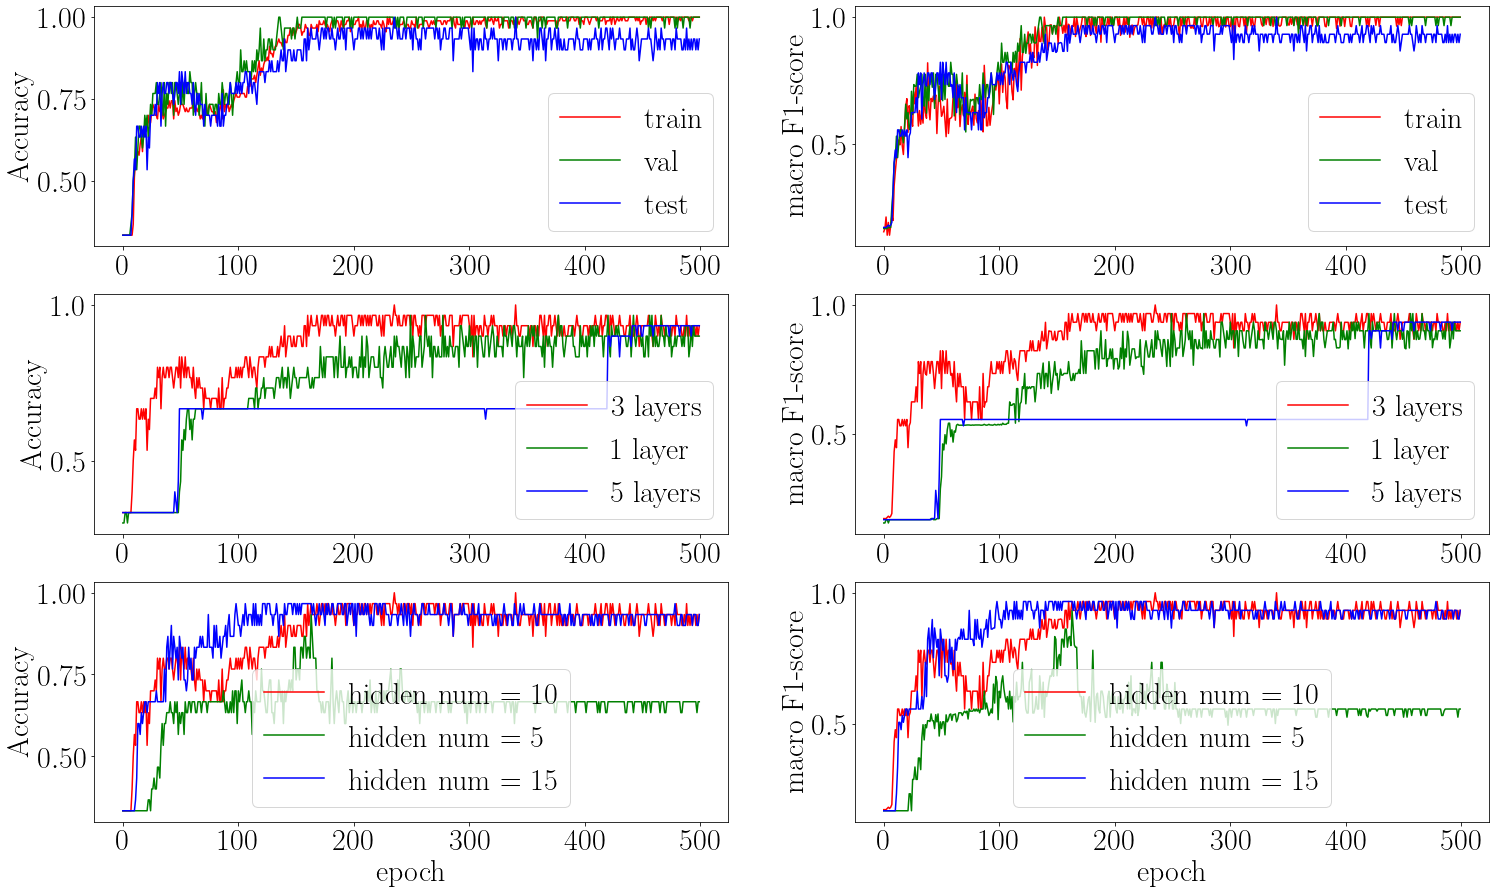

In [75]:
def draw3(hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315, num_epochs):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 15))

    plt.subplot(321)
    plt.plot(x, hist310['train'], 'r', label = 'train')
    plt.plot(x, hist310['val'], 'g', label = 'val')
    plt.plot(x, hist310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(322)
    plt.plot(x, f1_310['train'], 'r', label = 'train')
    plt.plot(x, f1_310['val'], 'g', label = 'val')
    plt.plot(x, f1_310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)

    plt.subplot(323)
    plt.plot(x, hist310['test'], 'r', label = '3 layers')
    plt.plot(x, hist110['test'], 'g', label = '1 layer')
    plt.plot(x, hist510['test'], 'b', label = '5 layers')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(324)
    plt.plot(x, f1_310['test'], 'r', label = '3 layers')
    plt.plot(x, f1_110['test'], 'g', label = '1 layer')
    plt.plot(x, f1_510['test'], 'b', label = '5 layers')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(325)
    plt.plot(x, hist310['test'], 'r', label = 'hidden num = 10')
    plt.plot(x, hist305['test'], 'g', label = 'hidden num = 5')
    plt.plot(x, hist315['test'], 'b', label = 'hidden num = 15')
    plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(326)
    plt.plot(x, f1_310['test'], 'r', label = 'hidden num = 10')
    plt.plot(x, f1_305['test'], 'g', label = 'hidden num = 5')
    plt.plot(x, f1_315['test'], 'b', label = 'hidden num = 15')
    plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)   
    
draw3(hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315, num_epochs)


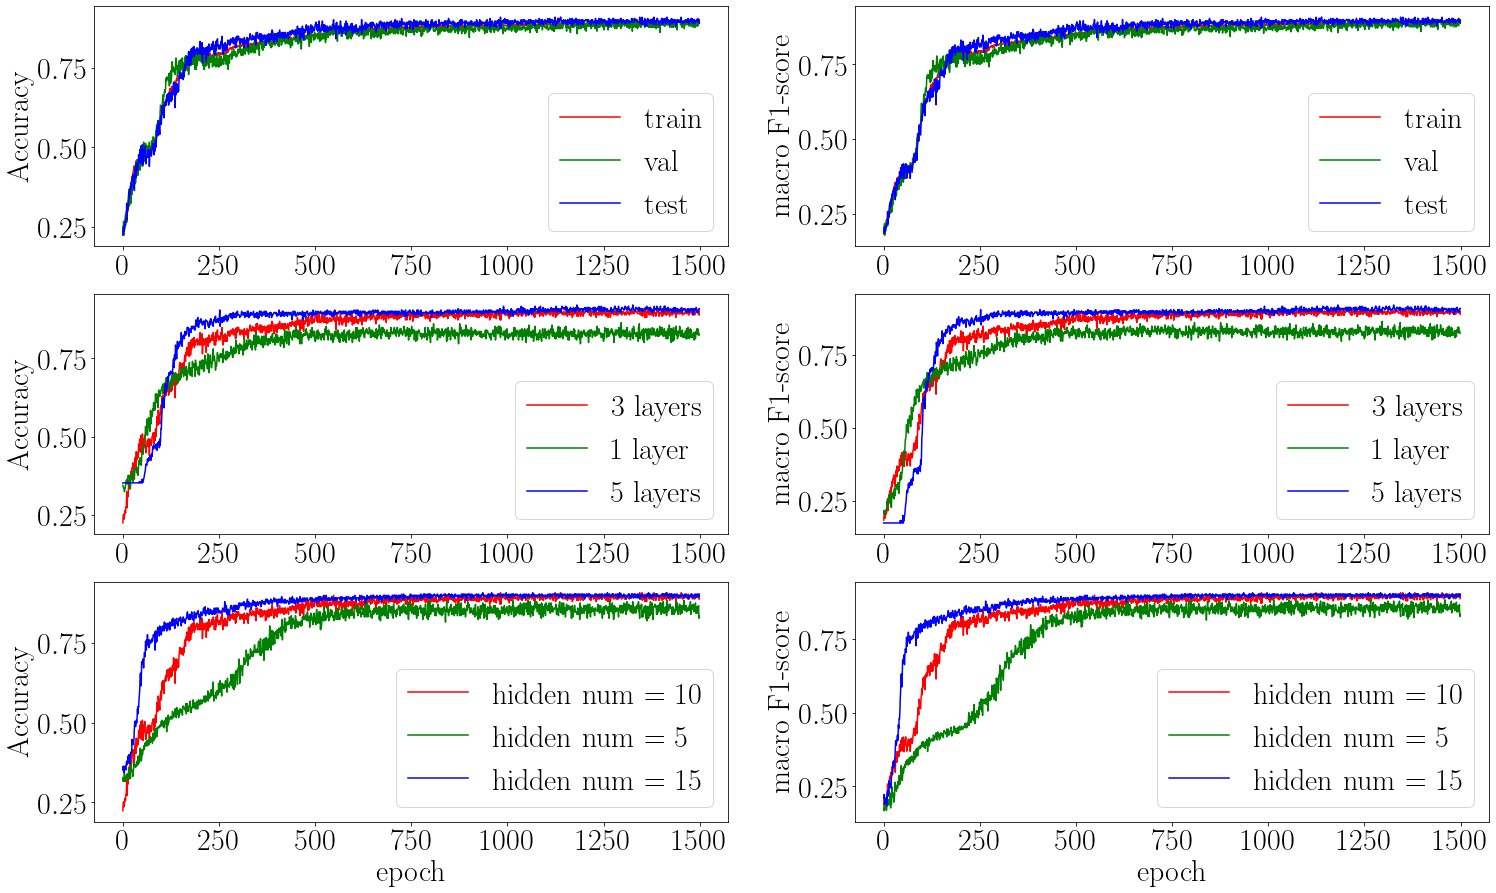

In [76]:
draw3(hist310r, hist110r, hist510r, hist305r, hist315r, f1_310r, f1_110r, f1_510r, f1_305r, f1_315r, num_epochs_random)

In [81]:
iris_list = [hist310, hist110, hist510, hist305, hist315, f1_310, f1_110, f1_510, f1_305, f1_315]
random_list = [hist310r, hist110r, hist510r, hist305r, hist315r, f1_310r, f1_110r, f1_510r, f1_305r, f1_315r]

def all_f1(data_list):
#     data_list.cpu()
    max_list = []
    for j,i in enumerate(data_list[5:]):
        f1_max = np.mean(i['test'][-10:])
#         print(np.array(data_list[j]['test'])[-5:])
        acc_max = np.mean(np.array(data_list[j]['test'])[-10:])
        max_list.append([f1_max, acc_max])
#         f1_max = np.max(i['test'])
#         loc = np.where(i['test'] == f1_max)
#         acc_max = np.max(np.array(data_list[j]['test'])[loc])
#         max_list.append([f1_max, acc_max])
    return np.array(max_list)

iris_best = all_f1(iris_list)
# random_best = all_f1(random_list)

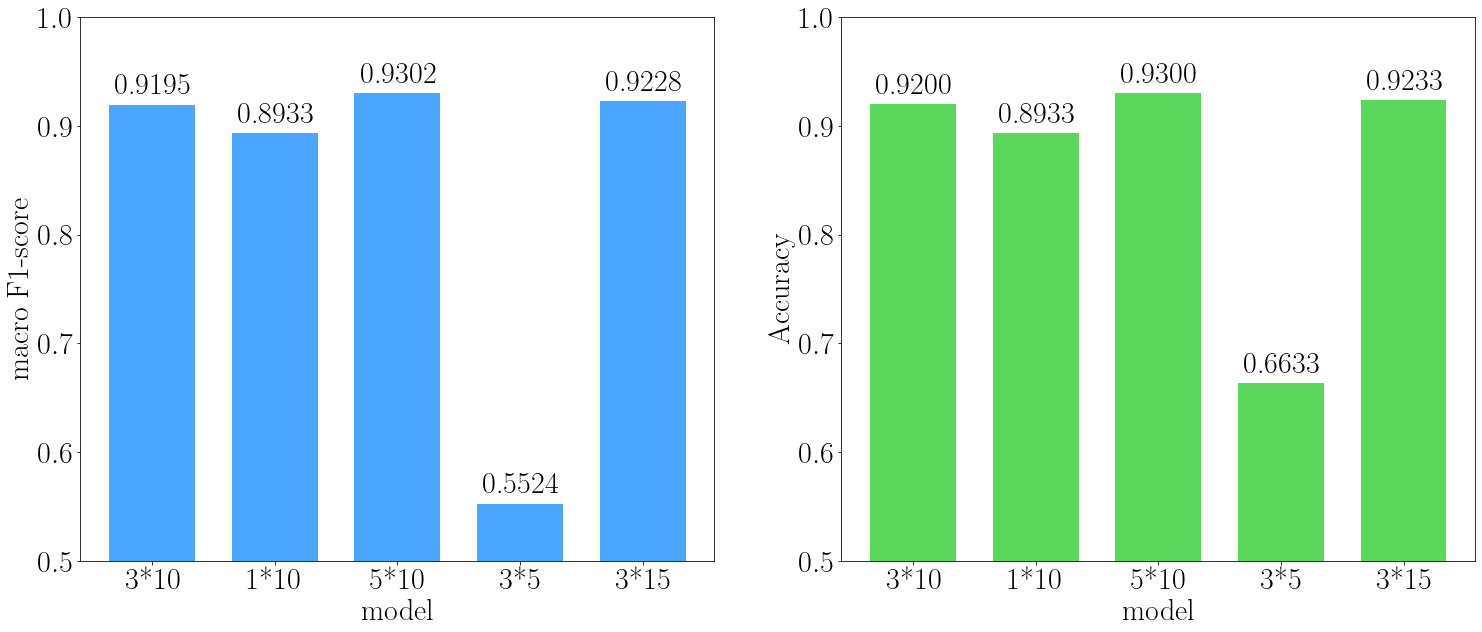

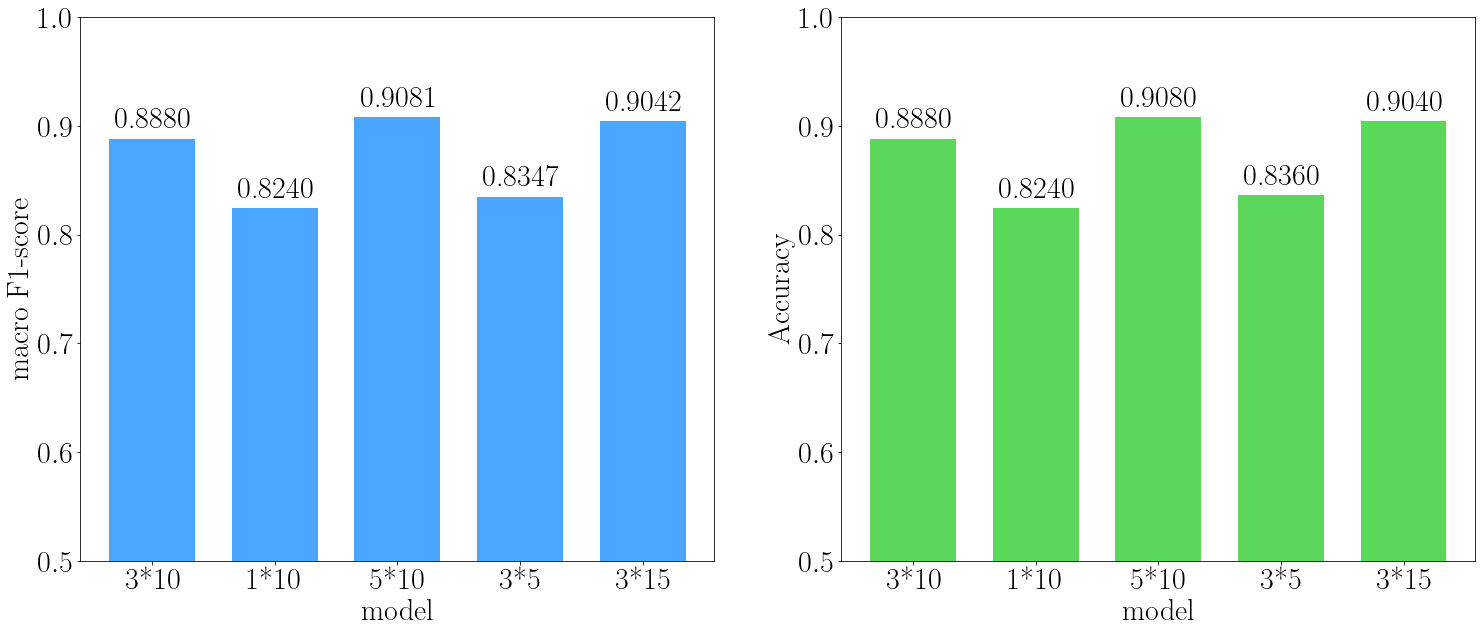

In [82]:
def draw_bar(data_list, num_epochs = 5):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 10))

    plt.subplot(121)
    plt.bar(range(5), data_list[:,0], width=0.7, color='dodgerblue', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("macro F1-score", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,0]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)

    
    plt.subplot(122)
    plt.bar(range(5), data_list[:,1], width=0.7, color='limegreen', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,1]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)

draw_bar(iris_best)
draw_bar(random_best)